This script performs the analysis of the proteomics data at 4 h.

In [1]:
import pandas, numpy, seaborn, matplotlib_venn

In [2]:
import sklearn, sklearn.preprocessing, sklearn.decomposition
import scipy, scipy.signal
import statsmodels, statsmodels.stats, statsmodels.stats.multitest

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.family':'sans-serif',
                            'font.size':20, 
                            'xtick.labelsize':30, 
                            'ytick.labelsize':30, 
                            'figure.figsize':(16, 9), 
                            'axes.labelsize':40})

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import mygene
mygenedb = mygene.MyGeneInfo()

### user-defined variables

In [6]:
fold_change_threshold = numpy.log2(1.5)

In [7]:
four_input_file = '/home/adrian/projects/vigur/data/proteomics/HPMVEC_Proteomics_September_2022/HPMVECs_september2022_4h_all_prts_Relative_Quantification.csv'
twentyfour_input_file = '/home/adrian/projects/vigur/data/proteomics/HPMVEC_Proteomics_September_2022/HPMVECs_september2022_24h_all_prts_Relative_Quantification.csv'

In [8]:
output_dir = '/home/adrian/projects/vigur/results/proteomics/'

In [9]:
four_input_file = '/Users/adrian/gd15/tmp/HPMVEC_Proteomics_September_2022/HPMVECs_september2022_4h_all_prts_Relative_Quantification.csv'
twentyfour_input_file = '/Users/adrian/gd15/tmp/HPMVEC_Proteomics_September_2022/HPMVECs_september2022_24h_all_prts_Relative_Quantification.csv'
output_dir = '/Users/adrian/scratch/'

In [10]:
# biomarkers
biomarkers = {
    'endothelin':'P05305',
    'PAI-1':'P05121',
    'uPA':'P00749',
    'VCAM-1':'P19320',
    'L-selectin':'P14151',
    'Ang2':'O15123',
    'VEGFr1':'P17948',
    'ICAM-2':'P13598',
    'tie2':'Q02763',
    'IL-6':'P05231',
    'E-selectin':'P16581',
    'ICAM-1':'P05362',
    'P-selectin':'P16109',
    'Ang1':'Q15389',
    'vWF':'P04275',
    'PDGF':'P01127',
    'endocan':'Q9NQ30',
    'TNFa':'P01375',
    'VEGFa':'P15692'
}

In [11]:
# Cohen's d values
cohen = {}
cohen['4x4'] = 2.380757
cohen['4x3'] = 2.683785
cohen['4x2'] = 3.257188

### define metadata

In [12]:
metadata = {}

metadata['4h control'] = ['20220905_ARNAR_010', '20220905_ARNAR_011', '20220905_ARNAR_035', '20220905_ARNAR_036', '20220905_ARNAR_058', '20220905_ARNAR_059']

metadata['4h epi'] = ['20220905_ARNAR_004', '20220905_ARNAR_005', '20220905_ARNAR_008', '20220905_ARNAR_009', '20220905_ARNAR_051', '20220905_ARNAR_052']


metadata['4h nor'] = ['20220905_ARNAR_013', '20220905_ARNAR_014', '20220905_ARNAR_019', '20220905_ARNAR_020', '20220905_ARNAR_044', '20220905_ARNAR_046']

metadata['4h epinor'] = ['20220905_ARNAR_024', '20220905_ARNAR_025', '20220905_ARNAR_026', '20220905_ARNAR_027']

metadata['4h TNFa'] = ['20220905_ARNAR_060', '20220905_ARNAR_065']

all_sample_names = [element for sublist in list(metadata.values()) for element in sublist]
print(len(all_sample_names))

24


### read data

In [13]:
df4 = pandas.read_csv(four_input_file, index_col=0, skiprows=2, sep=',')
df4.shape

(3183, 85)

In [14]:
df4.loc[['P05121', 'P13598', 'P05362'], ]

Peptide count  Unique peptides  Confidence score  Anova (p)  \
Accession                                                                
P05121                41               19          215.7082   0.075943   
P13598                13                4           73.0967   0.143520   
P05362                 7                2           38.8919   0.037111   

            q Value  Max fold change     Power Highest mean condition  \
Accession                                                               
P05121     0.024041         1.455217  0.602788              NorEPI 4h   
P13598     0.032430         1.399022  0.706830                TNFa 4h   
P05362     0.017843         2.982438  0.869784                TNFa 4h   

          Lowest mean condition        Mass  ... 20220905_ARNAR_044.2  \
Accession                                    ...                        
P05121                   Nor 4h  45117.1340  ...                    0   
P13598                NorEPI 4h  31167.6061  ...                    0   
P05362                  Ctrl 4h  58623.6603  ...                    0   

           20220905_ARNAR_046.2  20220905_ARNAR_024.2  20220905_ARNAR_025.2  \
Accession                                                                     
P05121                        0                    16                    14   
P13598                        0                     1                     0   
P05362                        0                     0                     0   

           20220905_ARNAR_026.2  20220905_ARNAR_027.2  20220905_ARNAR_060.2  \
Accession                                                                     
P05121                       12                     0                     0   
P13598                        0                     0                     0   
P05362                        0                     0                     0   

           20220905_ARNAR_065.2  no unique peptides  confidence<40  
Accession                                                           
P05121                        0                 NaN            NaN  
P13598                        0                 NaN            NaN  
P05362                        0                 NaN              x  

[3 rows x 85 columns]

In [15]:
df24 = pandas.read_csv(twentyfour_input_file, index_col=0, skiprows=2, sep=',')
df24.shape

(2686, 83)

In [16]:
rosetta = {}
for element in df4.index:
    description = df4.loc[element, 'Description'].split(' OS')[0]
    if element not in rosetta:
        rosetta[element] = description
print(df4.shape, len(rosetta))

for element in df24.index:
    description = df24.loc[element, 'Description'].split(' OS')[0]
    if element not in rosetta:
        rosetta[element] = description
print(df24.shape, len(rosetta))

(3183, 85) 3183
(2686, 83) 3760


### manipulate data

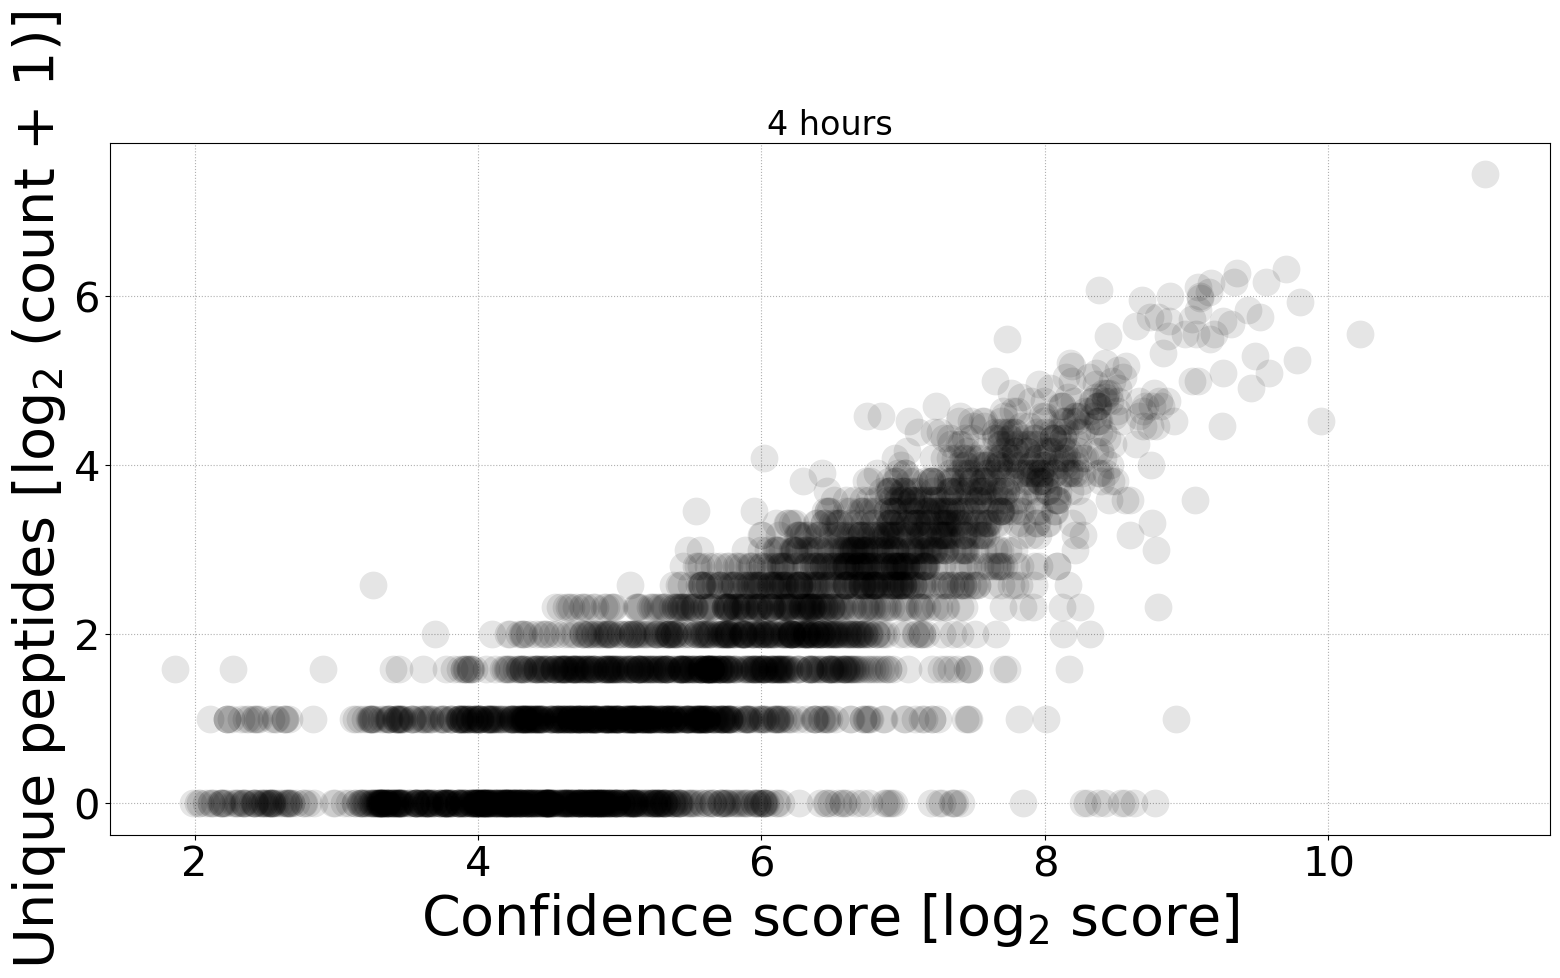

In [17]:
x = numpy.log2(df4['Confidence score'])
y = numpy.log2(df4['Unique peptides']+1)
               
matplotlib.pyplot.plot(x, y, 'o', color='black', alpha=1/10, markeredgecolor='None', ms=20)

matplotlib.pyplot.xlabel('Confidence score [log$_2$ score]')
matplotlib.pyplot.ylabel('Unique peptides [log$_2$ (count + 1)]')
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.title('4 hours')
matplotlib.pyplot.tight_layout()

Arbitrary thresholds for confident identifications:
- X-axis: log2 CS = 7 which represents a 2\**7 = 128 score.
- Y-axis: log2 unique peptides + 1 = 3 which represents a 2\**(3)-1 = 7 unique peptides.

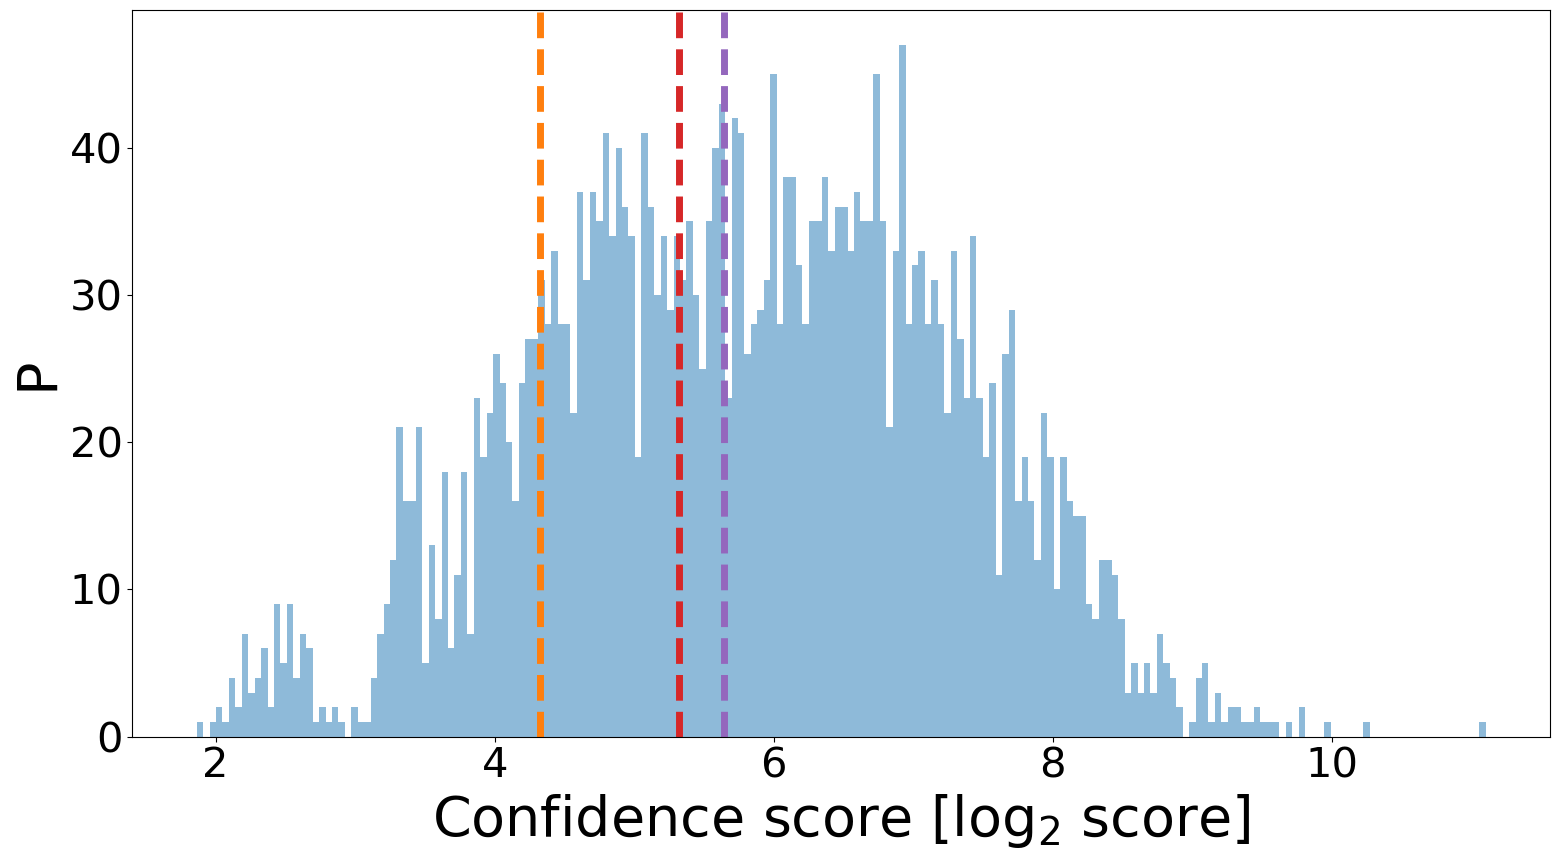

In [18]:
matplotlib.pyplot.hist(numpy.log2(df4['Confidence score']), bins=200, alpha=1/2)
matplotlib.pyplot.axvline(x=numpy.log2(20), lw=5, ls='--', color='tab:orange')
matplotlib.pyplot.axvline(x=numpy.log2(40), lw=5, ls='--', color='tab:red')
matplotlib.pyplot.axvline(x=numpy.log2(50), lw=5, ls='--', color='tab:purple')
matplotlib.pyplot.xlabel('Confidence score [log$_2$ score]')
matplotlib.pyplot.ylabel('P')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [19]:
new4 = df4[(df4['Unique peptides'] >= 1) & (df4['Confidence score'] >= 0)]
print(new4.shape)

working_labels = [label for label in new4.columns if label in all_sample_names]

new4 = numpy.log2(new4.loc[:, working_labels] + 1)
print(new4.shape)
new4

(2528, 85)
(2528, 24)


20220905_ARNAR_004  20220905_ARNAR_005  20220905_ARNAR_008  \
Accession                                                               
Q86Y97               7.568576            7.629861            7.466070   
P07996              16.045552           16.078366           16.161570   
Q9BYC5               9.957537            9.846812            9.972054   
P17612              11.366183           11.371677           11.502530   
Q9NVA2              12.240767           12.273150           12.230812   
...                       ...                 ...                 ...   
P11940              10.938910           10.909989           10.984745   
P16402               6.827489            6.782686            7.224241   
Q5T9S5              12.065849           12.090588           12.101302   
Q7RTR0              10.579977           10.566369           10.445765   
Q8ND04               9.098815            9.113469            9.169523   

           20220905_ARNAR_009  20220905_ARNAR_051  20220905_ARNAR_052  \
Accession                                                               
Q86Y97               7.704124            7.859829            7.503472   
P07996              16.156538           16.229749           16.211154   
Q9BYC5               9.924427            9.952922            9.961175   
P17612              11.458926           11.281645           11.490084   
Q9NVA2              12.246755           12.321591           12.283944   
...                       ...                 ...                 ...   
P11940              10.975925           10.923703           10.957724   
P16402               6.817968            6.326902            4.578377   
Q5T9S5              12.134545           12.465226           12.474968   
Q7RTR0              10.376712           11.070385           11.149609   
Q8ND04               9.210782            9.434898            9.428083   

           20220905_ARNAR_010  20220905_ARNAR_011  20220905_ARNAR_035  \
Accession                                                               
Q86Y97               7.846906            8.031127            7.912484   
P07996              15.643942           15.675235           15.817460   
Q9BYC5              10.160242           10.292097           10.272115   
P17612              10.982659           11.018419           11.036613   
Q9NVA2              12.229056           12.302041           12.452724   
...                       ...                 ...                 ...   
P11940              10.735809           10.728667           11.009232   
P16402               6.862030            6.535857            6.168747   
Q5T9S5              12.129535           12.233542           12.079865   
Q7RTR0              10.636911           10.667222           10.862307   
Q8ND04               9.071558            9.056359            9.175138   

           20220905_ARNAR_036  ...  20220905_ARNAR_019  20220905_ARNAR_020  \
Accession                      ...                                           
Q86Y97               8.080246  ...            7.746224            7.791791   
P07996              15.806405  ...           16.285414           16.314586   
Q9BYC5              10.290766  ...            9.578374            9.437409   
P17612              11.051132  ...           11.340180           11.419755   
Q9NVA2              12.257791  ...           12.362618           12.350376   
...                       ...  ...                 ...                 ...   
P11940              10.770036  ...           10.864331           10.930608   
P16402               6.519346  ...            6.697396            6.925505   
Q5T9S5              11.996127  ...           12.173067           12.192364   
Q7RTR0              10.759673  ...           11.029014           10.993737   
Q8ND04               9.098708  ...            9.367574            9.312484   

           20220905_ARNAR_044  20220905_ARNAR_046  20220905_ARNAR_024  \
Accession                                                               


### visualize data

200
19.492541086884188


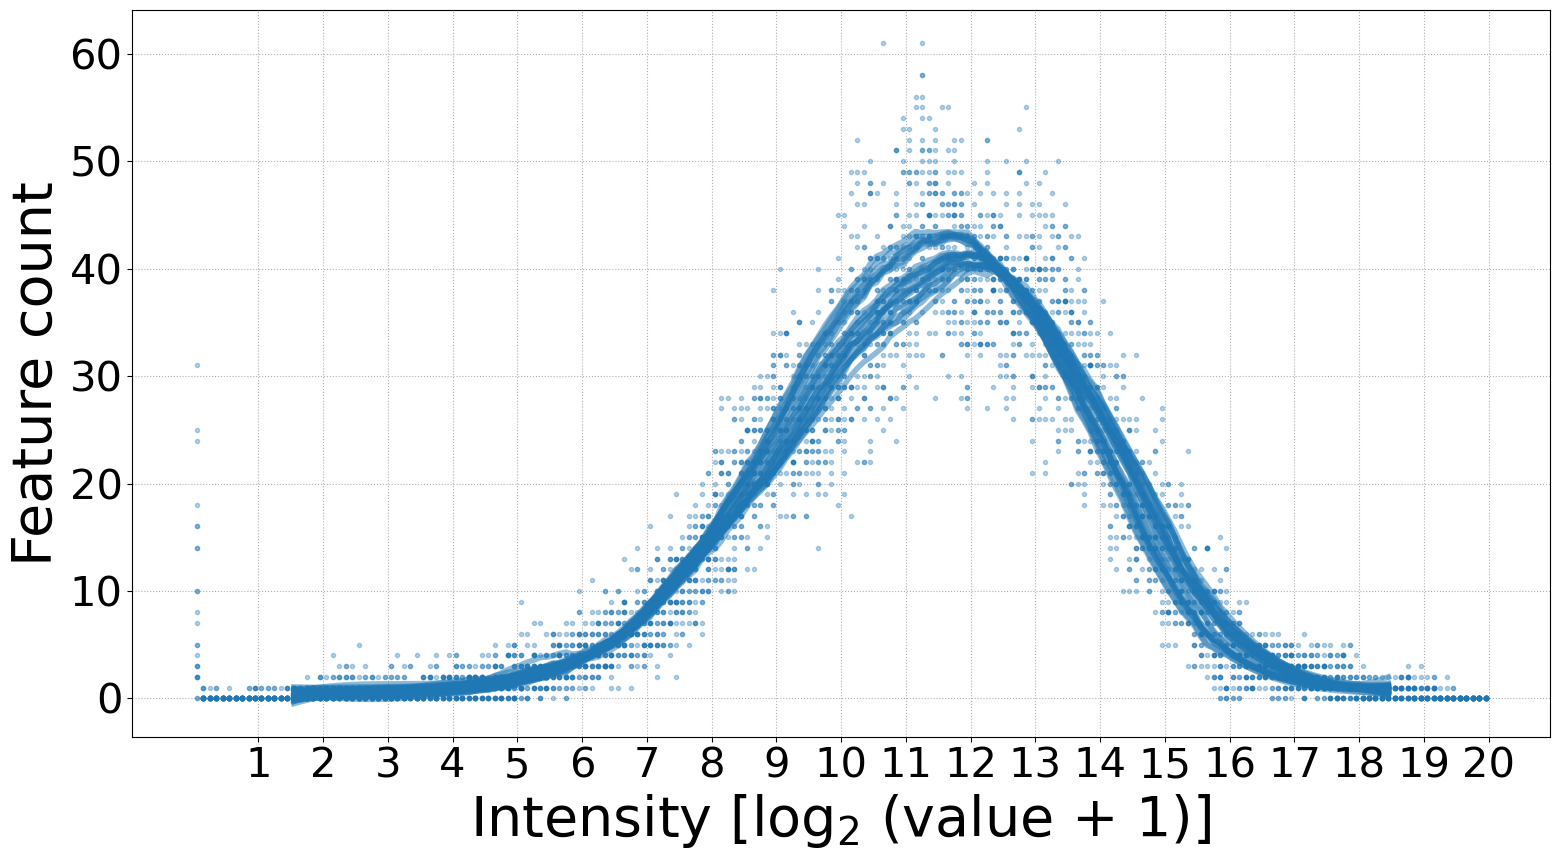

In [20]:
found_max = 20
number_of_bins = found_max * 10
margin = 15
print(number_of_bins)

absolute_max = 0
plotting_x = []; plotting_y = []
most_likely_early = []

for sample in new4.columns:
        
    intensities = new4.loc[:, sample]
    
    # histogram
    hist, bin_edges = numpy.histogram(intensities, bins=number_of_bins, range=(0, found_max))
    half_bin = (bin_edges[1] - bin_edges[0])/2
    x = bin_edges + half_bin
    x = x[:-1]
    
    # curve fitting
    plotting_x = x[margin:-margin]
    plotting_hist = hist[margin:-margin]
    yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
    
    # storing info to quantify bias
    most_likely_intensity = x[numpy.argmax(yhat)]
    most_likely_early.append(most_likely_intensity)
    
    
    # plotting
    the_color = 'tab:blue'
    matplotlib.pyplot.plot(x, hist, '.', alpha=1/3, color=the_color)
    matplotlib.pyplot.plot(plotting_x, yhat, '-', lw=4, alpha=1/2, color=the_color)
    
    # check
    if max(intensities) > absolute_max:
        absolute_max = max(intensities)

# check print
print(absolute_max)

matplotlib.pyplot.xticks(range(1, 21))
matplotlib.pyplot.xlabel('Intensity [log$_2$ (value + 1)]')
matplotlib.pyplot.ylabel('Feature count')
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()

### normalization

In [21]:
#
# quantile normalization 
# taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
#

# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(new4.values, axis=0), index=new4.index, columns=new4.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
qndf = new4.rank(method="min").stack().astype(int).map(df_mean).unstack()

### distributions after normalization

200
19.071343768957153


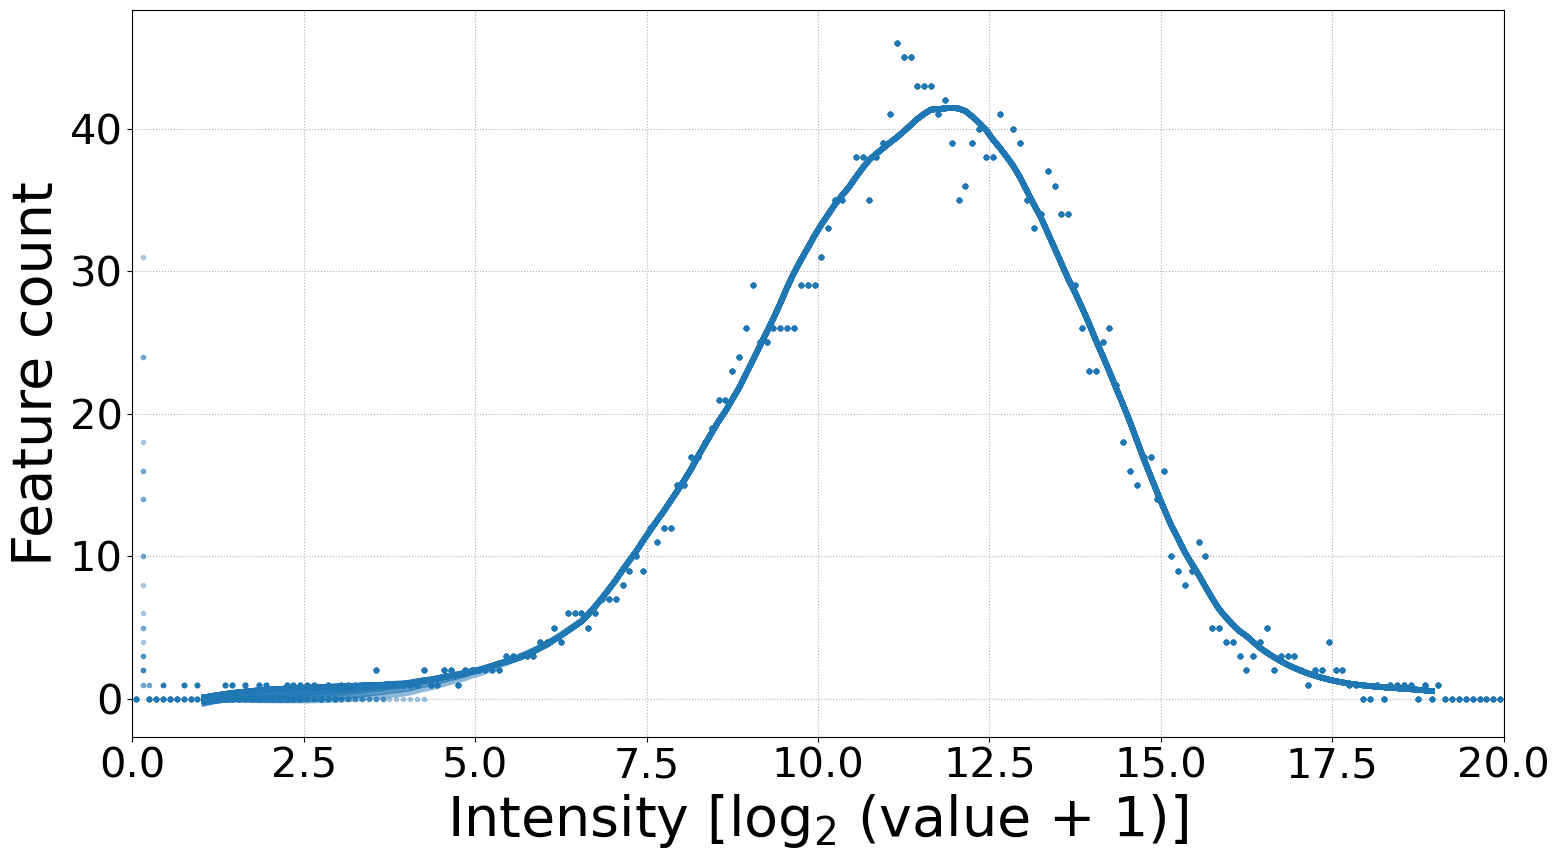

In [22]:
found_max = 20
number_of_bins = found_max * 10
margin = 10
print(number_of_bins)

absolute_max = 0
plotting_x = []; plotting_y = []
most_likely_early = []

for sample in qndf.columns:
        
    intensities = qndf.loc[:, sample]
    
    # histogram
    hist, bin_edges = numpy.histogram(intensities, bins=number_of_bins, range=(0, found_max))
    half_bin = (bin_edges[1] - bin_edges[0])/2
    x = bin_edges + half_bin
    x = x[:-1]
    
    # curve fitting
    plotting_x = x[margin:-margin]
    plotting_hist = hist[margin:-margin]
    yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
    
    # storing info to quantify bias
    most_likely_intensity = x[numpy.argmax(yhat)]
    most_likely_early.append(most_likely_intensity)
    
    
    # plotting
    the_color = 'tab:blue'
    matplotlib.pyplot.plot(x, hist, '.', alpha=1/3, color=the_color)
    matplotlib.pyplot.plot(plotting_x, yhat, '-', lw=4, alpha=1/2, color=the_color)
    
    # check
    if max(intensities) > absolute_max:
        absolute_max = max(intensities)

# check print
print(absolute_max)
matplotlib.pyplot.xlim(0,20)

matplotlib.pyplot.xlabel('Intensity [log$_2$ (value + 1)]')
matplotlib.pyplot.ylabel('Feature count')
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()

### biomarkers

In [23]:
df4

Peptide count  Unique peptides  Confidence score     Anova (p)  \
Accession                                                                   
Q86Y97                 4                1           19.9706  2.294162e-07   
P07996               100               68          540.9306  2.828252e-07   
Q9BYC5                12                3           58.5130  3.726699e-07   
P17612                17                3          111.8179  6.981399e-07   
Q9NVA2                28               10          132.4747  1.576348e-06   
...                  ...              ...               ...           ...   
Q92930                12                0          119.3084           NaN   
Q93045                 5                0           43.1622           NaN   
Q93086                 5                0           26.3792           NaN   
Q99418                 3                0           13.4528           NaN   
Q99456                 3                0           16.1307           NaN   

            q Value  Max fold change  Power Highest mean condition  \
Accession                                                            
Q86Y97     0.000040         1.857857    1.0                TNFa 4h   
P07996     0.000040         1.455024    1.0              NorEPI 4h   
Q9BYC5     0.000040         2.085111    1.0                Ctrl 4h   
P17612     0.000056         1.372203    1.0              NorEPI 4h   
Q9NVA2     0.000101         1.266081    1.0                TNFa 4h   
...             ...              ...    ...                    ...   
Q92930          NaN              NaN    NaN                    ---   
Q93045          NaN              NaN    NaN                    ---   
Q93086          NaN              NaN    NaN                    ---   
Q99418          NaN              NaN    NaN                    ---   
Q99456          NaN              NaN    NaN                    ---   

          Lowest mean condition         Mass  ... 20220905_ARNAR_044.2  \
Accession                                     ...                        
Q86Y97                NorEPI 4h   53025.4924  ...                    0   
P07996                  Ctrl 4h  133374.7259  ...                    0   
Q9BYC5                  TNFa 4h   66972.0815  ...                    0   
P17612                  TNFa 4h   40703.7821  ...                    0   
Q9NVA2                   Epi 4h   49683.4837  ...                    0   
...                         ...          ...  ...                  ...   
Q92930                      ---   23755.2297  ...                    0   
Q93045                      ---   20942.1591  ...                    0   
Q93086                      ---   48003.1742  ...                    0   
Q99418                      ---   46888.3582  ...                    0   
Q99456                      ---   53625.5628  ...                    0   

           20220905_ARNAR_046.2  20220905_ARNAR_024.2  20220905_ARNAR_025.2  \
Accession                                                                     
Q86Y97                        0                     0                     0   
P07996                        0                    37                    51   
Q9BYC5                        0                     0                     1   
P17612                        0                     0                     0   
Q9NVA2                        0                     1                     6   
...                         ...                   ...                   ...   
Q92930                        0                     0                     0   
Q93045                        0                     0                     0   
Q93086                        0                     0                     0   
Q99418                        0                     0                     0   
Q99456                        0                     0                     0   

           20220905_ARNAR_026.2  20220905_ARNAR_027.2  20220905_ARNAR_060.2  \
Accession                   

In [24]:
detected_biomarkers = {}
for biomarker in biomarkers.keys():
    uniprot_id = biomarkers[biomarker]
    print('working with biomarker {}, uniprot {}'.format(biomarker, uniprot_id))
    for element in df4.index:
        if uniprot_id in element:
            print('\t{}, peptide count {}, score {}'.format(element, df4.loc[element, 'Unique peptides'], df4.loc[element, 'Confidence score']))
            detected_biomarkers[element] = biomarker

detected_biomarkers.keys()

working with biomarker endothelin, uniprot P05305
working with biomarker PAI-1, uniprot P05121
	P05121, peptide count 19, score 215.7082
working with biomarker uPA, uniprot P00749
working with biomarker VCAM-1, uniprot P19320
working with biomarker L-selectin, uniprot P14151
working with biomarker Ang2, uniprot O15123
working with biomarker VEGFr1, uniprot P17948
working with biomarker ICAM-2, uniprot P13598
	P13598, peptide count 4, score 73.0967
working with biomarker tie2, uniprot Q02763
working with biomarker IL-6, uniprot P05231
working with biomarker E-selectin, uniprot P16581
working with biomarker ICAM-1, uniprot P05362
	P05362, peptide count 2, score 38.8919
working with biomarker P-selectin, uniprot P16109
working with biomarker Ang1, uniprot Q15389
working with biomarker vWF, uniprot P04275
working with biomarker PDGF, uniprot P01127
working with biomarker endocan, uniprot Q9NQ30
working with biomarker TNFa, uniprot P01375
working with biomarker VEGFa, uniprot P15692


dict_keys(['P05121', 'P13598', 'P05362'])

P05121 4h control
P05121 4h epi
P05121 4h nor
P05121 4h epinor
P05121 4h TNFa
PAI-1 [16.3832417056705, 16.25073217723727, 16.05110504365731, 16.559361035322947, 15.911607289679079]
P13598 4h control
P13598 4h epi
P13598 4h nor
P13598 4h epinor
P13598 4h TNFa
ICAM-2 [11.314049386676263, 11.172175485531238, 11.272471413390722, 11.030145299158619, 11.402497174542678]
P05362 4h control
P05362 4h epi
P05362 4h nor
P05362 4h epinor
P05362 4h TNFa
ICAM-1 [8.921226585247059, 9.809193729719926, 9.890215322121211, 9.400373928110387, 10.322439311392213]
{'PAI-1': [0.0, -0.1325095284332285, -0.33213666201319114, 0.17611932965244748, -0.47163441599142075], 'ICAM-2': [0.0, -0.14187390114502563, -0.04157797328554125, -0.2839040875176444, 0.08844778786641427], 'ICAM-1': [0.0, 0.8879671444728672, 0.9689887368741523, 0.47914734286332816, 1.401212726145154]}


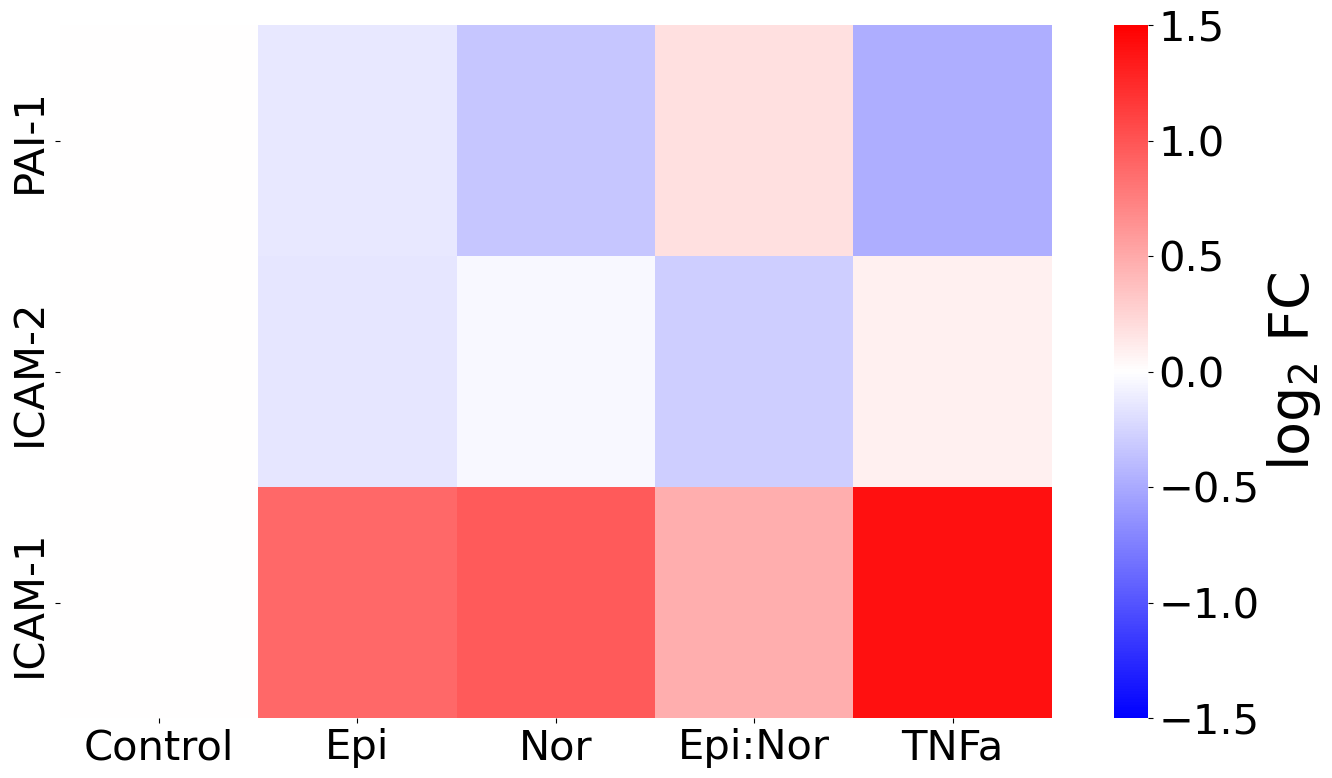

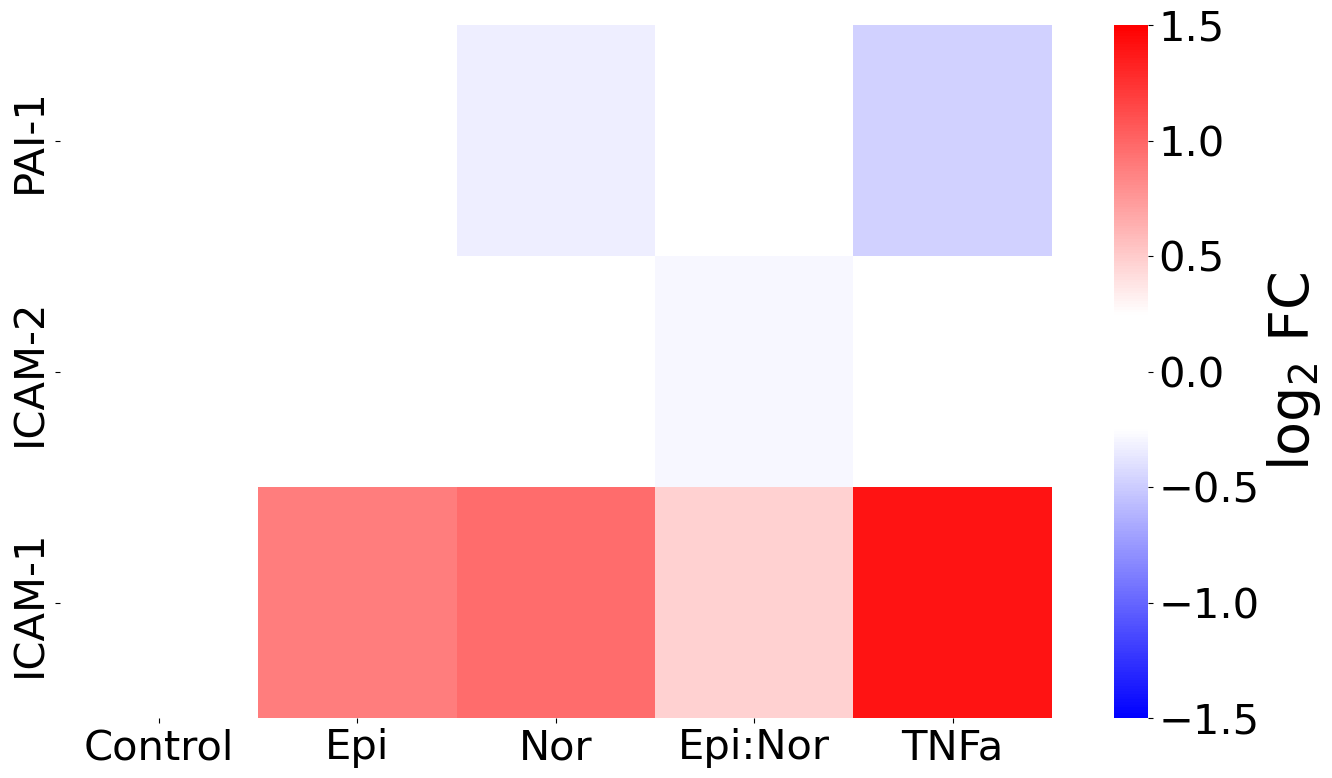

In [25]:
# gererate data for heatmap
heatmap_data = {}
for marker in detected_biomarkers.keys():
    heatmap_data[detected_biomarkers[marker]] = []
    for treatment in metadata.keys():
        print(marker, treatment)
        log2_intensity = numpy.median(qndf.loc[marker, metadata[treatment]].values)
        heatmap_data[detected_biomarkers[marker]].append(log2_intensity)
    print(detected_biomarkers[marker], heatmap_data[detected_biomarkers[marker]])

for biomarker in heatmap_data:
    reference = heatmap_data[biomarker][0]
    for i in range(len(heatmap_data[biomarker])):
        heatmap_data[biomarker][i] = heatmap_data[biomarker][i] - reference
print(heatmap_data)
heatmap_df = pandas.DataFrame.from_dict(heatmap_data).transpose()
heatmap_df.columns = ['Control', 'Epi', 'Nor', 'Epi:Nor', 'TNFa']

colors = [(0, "blue"), (0.5-(1/12), "white"), (0.5+(1/12), "white"), (1, "red")]
bwwr = matplotlib.colors.LinearSegmentedColormap.from_list("bwwr", colors)

seaborn.heatmap(data=heatmap_df, cmap='bwr', vmin=-1.5, vmax=1.5, cbar_kws={'label':'log$_2$ FC'})
matplotlib.pyplot.show()

seaborn.heatmap(data=heatmap_df, cmap=bwwr, vmin=-1.5, vmax=1.5, cbar_kws={'label':'log$_2$ FC'})
matplotlib.pyplot.show()

### PCA

[0.32620718 0.15122761]


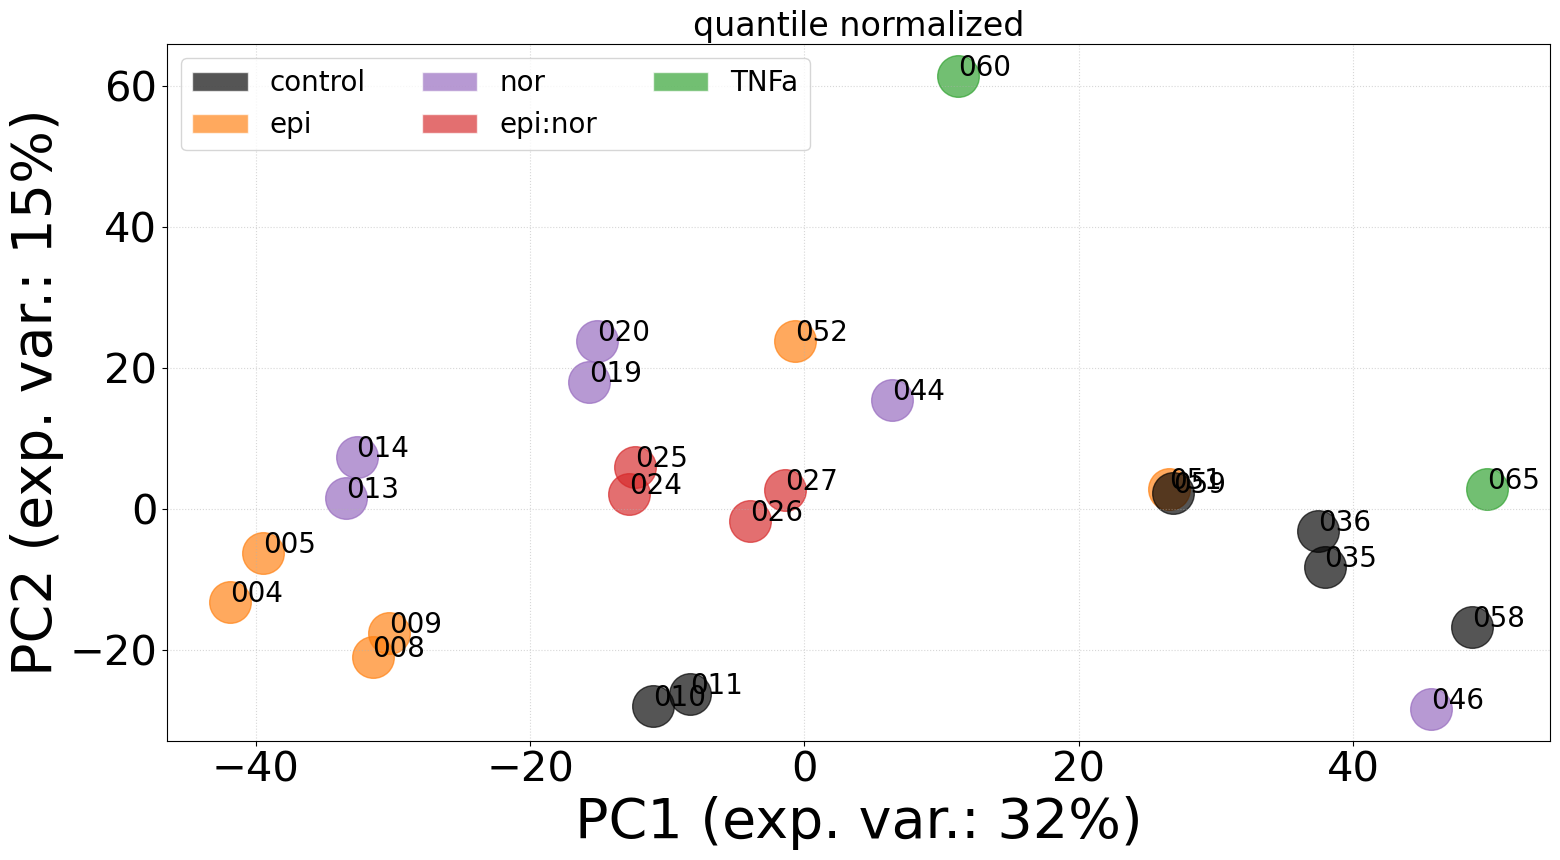

In [26]:
# quantile normalized all
transpose = qndf.transpose()
scaled_data = sklearn.preprocessing.StandardScaler().fit_transform(transpose)
model = sklearn.decomposition.PCA(n_components=2)
locations = model.fit_transform(scaled_data)
explained = model.explained_variance_ratio_
print(explained)

for i in range(len(locations)):
    
    the_marker = 'o'
        
    if qndf.columns[i] in metadata['4h control']:
        the_color = 'black'
    elif qndf.columns[i] in metadata['4h epi']:
        the_color = 'tab:orange'
    elif qndf.columns[i] in metadata['4h nor']:
        the_color = 'tab:purple'
    elif qndf.columns[i] in metadata['4h epinor']:
        the_color = 'tab:red'
    elif qndf.columns[i] in metadata['4h TNFa']:
        the_color = 'tab:green'
    else:
        raise ValueError('sample not classified')
    
    matplotlib.pyplot.scatter(locations[i,0], locations[i,1], s=900, c=the_color, marker=the_marker, alpha=2/3)
    
    the_label = qndf.columns[i].split('_')[-1]
    matplotlib.pyplot.text(locations[i, 0], locations[i, 1], the_label)
    
legend_elements = [ 
    matplotlib.patches.Patch(facecolor='black', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:orange', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:purple', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:red', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:green', edgecolor='white', alpha=2/3)
]
matplotlib.pyplot.legend(legend_elements, ['control', 'epi', 'nor', 'epi:nor', 'TNFa'], ncol=3)

matplotlib.pyplot.xlabel('PC1 (exp. var.: {}%)'.format(int(explained[0]*100)))
matplotlib.pyplot.ylabel('PC2 (exp. var.: {}%)'.format(int(explained[1]*100)))
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.title('quantile normalized')
matplotlib.pyplot.tight_layout()

[0.46998353 0.13362752]


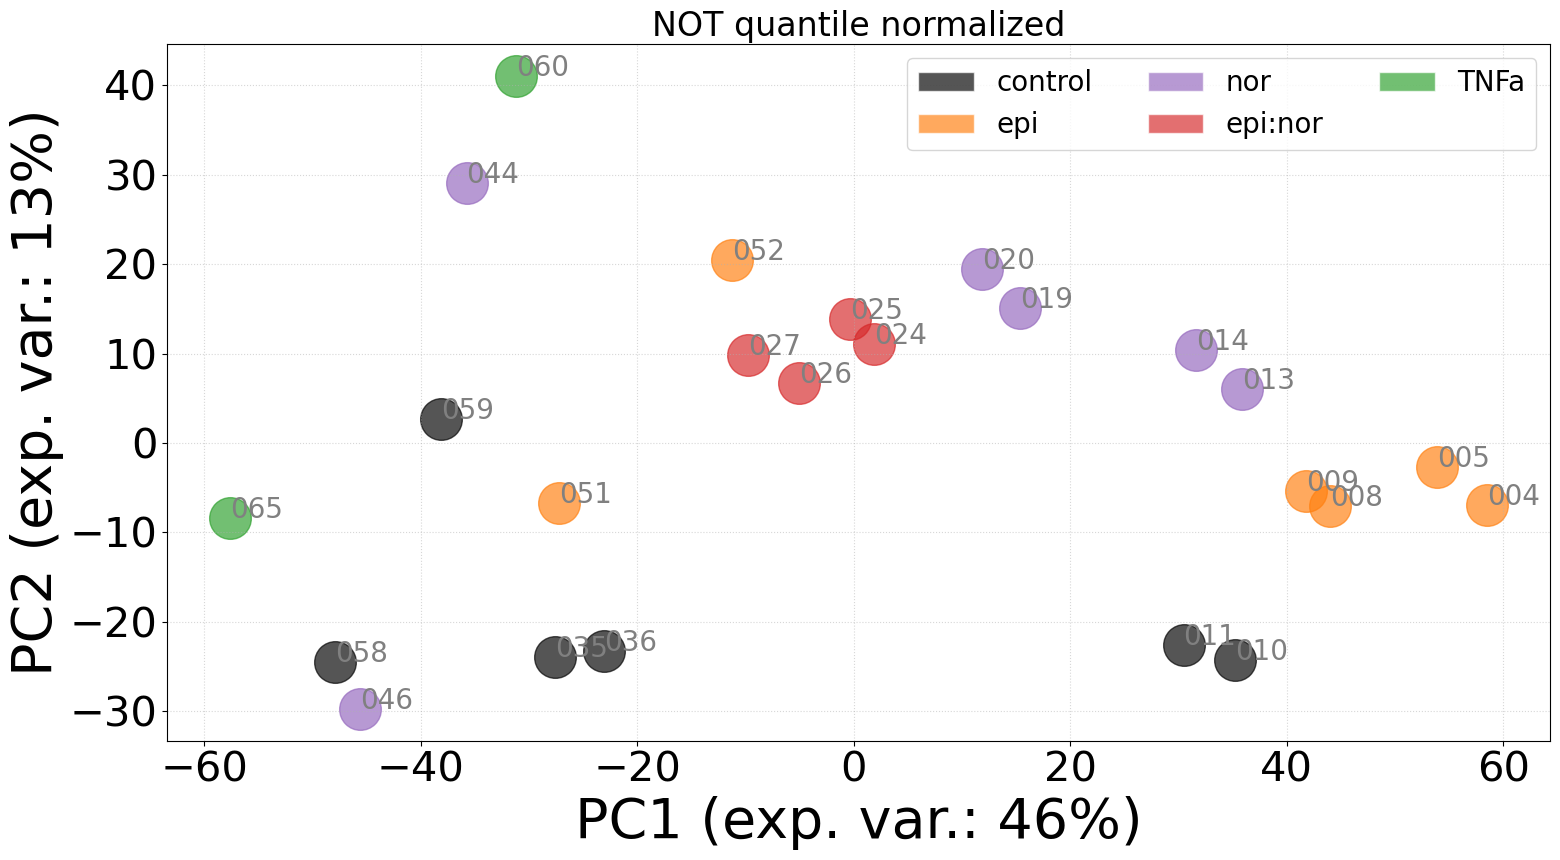

In [27]:
# non-quantile normalized all
transpose = new4.transpose()
scaled_data = sklearn.preprocessing.StandardScaler().fit_transform(transpose)
model = sklearn.decomposition.PCA(n_components=2)
locations = model.fit_transform(scaled_data)
explained = model.explained_variance_ratio_
print(explained)

for i in range(len(locations)):
    
    the_marker = 'o'
        
    if qndf.columns[i] in metadata['4h control']:
        the_color = 'black'
    elif qndf.columns[i] in metadata['4h epi']:
        the_color = 'tab:orange'
    elif qndf.columns[i] in metadata['4h nor']:
        the_color = 'tab:purple'
    elif qndf.columns[i] in metadata['4h epinor']:
        the_color = 'tab:red'
    elif qndf.columns[i] in metadata['4h TNFa']:
        the_color = 'tab:green'
    else:
        raise ValueError('sample not classified')
        
    matplotlib.pyplot.scatter(locations[i,0], locations[i,1], s=900, c=the_color, marker=the_marker, alpha=2/3)
    
    the_label = new4.columns[i].split('_')[-1]
    matplotlib.pyplot.text(locations[i, 0], locations[i, 1], the_label, color='gray')
    
legend_elements = [
    matplotlib.patches.Patch(facecolor='black', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:orange', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:purple', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:red', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:green', edgecolor='white', alpha=2/3)
]
matplotlib.pyplot.legend(legend_elements, ['control', 'epi', 'nor', 'epi:nor', 'TNFa'], ncol=3)

matplotlib.pyplot.xlabel('PC1 (exp. var.: {}%)'.format(int(explained[0]*100)))
matplotlib.pyplot.ylabel('PC2 (exp. var.: {}%)'.format(int(explained[1]*100)))
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.title('NOT quantile normalized')

matplotlib.pyplot.tight_layout()

10
['20220905_ARNAR_060', '20220905_ARNAR_065', '20220905_ARNAR_052', '20220905_ARNAR_044', '20220905_ARNAR_051', '20220905_ARNAR_059', '20220905_ARNAR_036', '20220905_ARNAR_035', '20220905_ARNAR_058', '20220905_ARNAR_046']
[0.29065869 0.22573567]


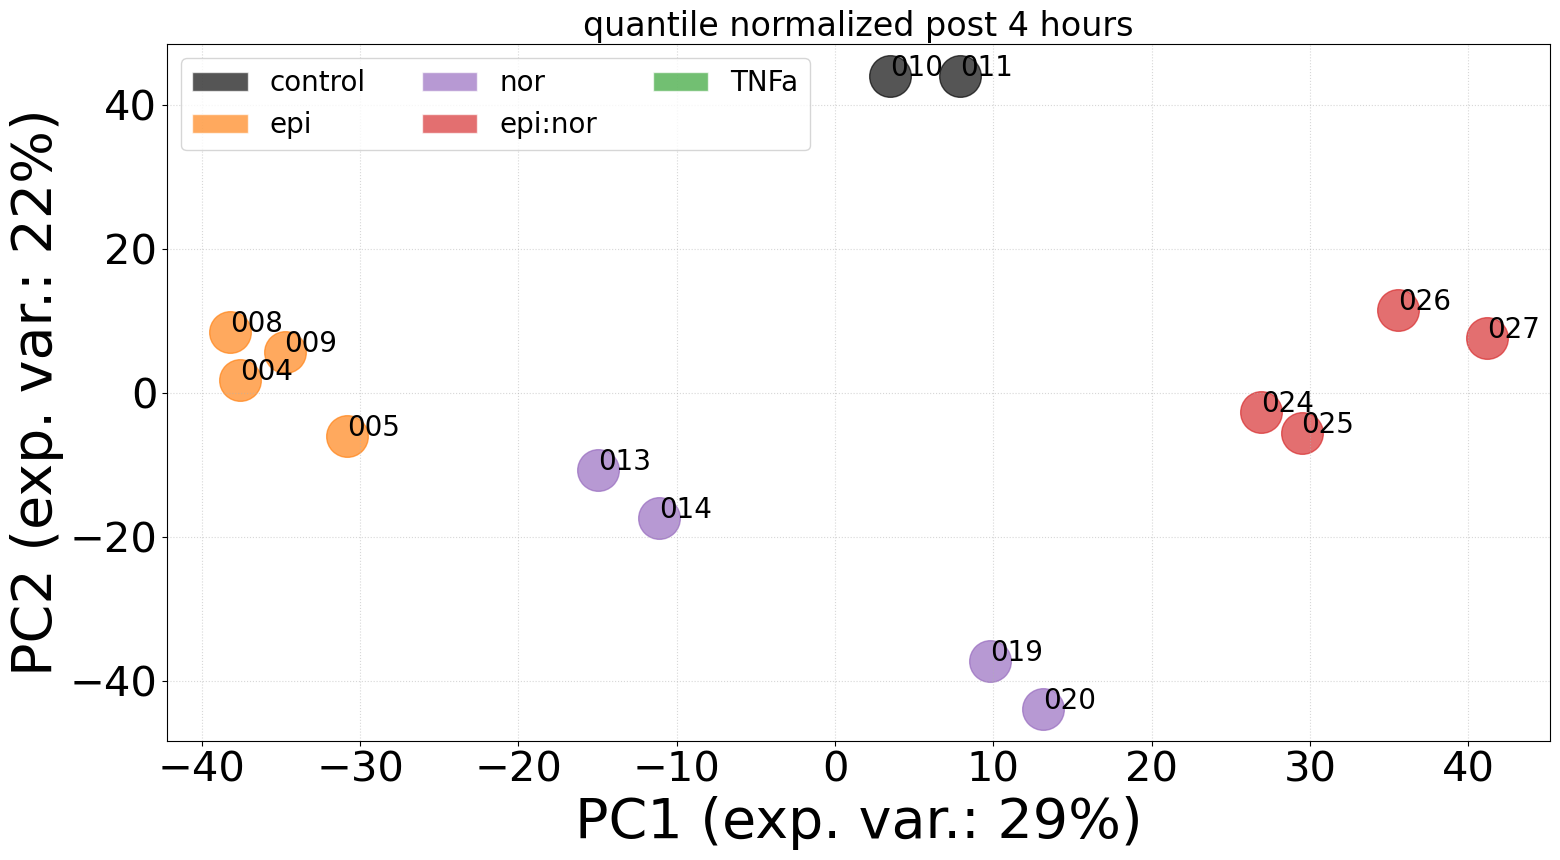

In [28]:
# excluding arbitrary samples
excluded_sample_tags = ['060', '065', '052', '044', '051', '059', '036', '035', '058', '046']
print(len(excluded_sample_tags)) # should be 10
excluded_samples = ['20220905_ARNAR_' + element for element in excluded_sample_tags]
print(excluded_samples)
simplified_df = new4.drop(excluded_samples, axis=1)

# normalization
# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(simplified_df.values, axis=0), index=simplified_df.index, columns=simplified_df.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
qndf = simplified_df.rank(method="min").stack().astype(int).map(df_mean).unstack()

# PCA
transpose = qndf.transpose()
scaled_data = sklearn.preprocessing.StandardScaler().fit_transform(transpose)
model = sklearn.decomposition.PCA(n_components=2)
locations = model.fit_transform(scaled_data)
explained = model.explained_variance_ratio_
print(explained)

for i in range(len(locations)):
    
    the_marker = 'o'
    the_label = qndf.columns[i].split('_')[-1]
        
    if simplified_df.columns[i] in metadata['4h control']:
        the_color = 'black'
    elif simplified_df.columns[i] in metadata['4h epi']:
        the_color = 'tab:orange'
    elif simplified_df.columns[i] in metadata['4h nor']:
        the_color = 'tab:purple'
    elif simplified_df.columns[i] in metadata['4h epinor']:
        the_color = 'tab:red'
    elif simplified_df.columns[i] in metadata['4h TNFa']:
        the_color = 'tab:green'
    else:
        raise ValueError('sample not classified')
    
    matplotlib.pyplot.scatter(locations[i,0], locations[i,1], s=900, c=the_color, marker=the_marker, alpha=2/3)
    matplotlib.pyplot.text(locations[i, 0], locations[i, 1], the_label)
    
    
legend_elements = [ 
    matplotlib.patches.Patch(facecolor='black', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:orange', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:purple', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:red', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:green', edgecolor='white', alpha=2/3)
]
matplotlib.pyplot.legend(legend_elements, ['control', 'epi', 'nor', 'epi:nor', 'TNFa'], ncol=3)

matplotlib.pyplot.xlabel('PC1 (exp. var.: {}%)'.format(int(explained[0]*100)))
matplotlib.pyplot.ylabel('PC2 (exp. var.: {}%)'.format(int(explained[1]*100)))
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.title('quantile normalized post 4 hours')
matplotlib.pyplot.tight_layout()

### make comparisons

In [29]:
sample1 = [6, 6, 7, 8, 8, 10, 11, 13, 15, 15, 16, 17, 19, 19, 21]
numpy.var(sample1)

24.328888888888887

In [30]:
def cohen_d_calculator(sample1, sample2):    

    a = (len(sample1)-1) * numpy.var(sample1, ddof=1)
    b = (len(sample2)-1) * numpy.var(sample2, ddof=1)
    num = a + b
    denom = len(sample1) + len(sample2) - 2
    pooled = numpy.sqrt(num / denom)
    d = numpy.abs((numpy.mean(sample1) - numpy.mean(sample2))) / pooled
        
    return d # should be 1.151497 for the example

sample1 = [6, 6, 7, 8, 8, 10, 11, 13, 15, 15, 16, 17, 19, 19, 21]
sample2 = [10, 11, 13, 13, 15, 17, 17, 19, 20, 22, 24, 25, 27, 29, 29]
value = cohen_d_calculator(sample1, sample2)

print(value) # should be 1.151497 for the example

1.1514972515592619


In [31]:
def comparison_function(time_label, detected_biomarkers, qndf, treatment_label, treatment_color, control_samples, treated_samples):
    
    world_size = len(control_samples) + len(treated_samples)
    if world_size == 6:
        cohen_threshold = cohen['4x2']
    elif world_size == 7:
        cohen_threshold = cohen['4x3']
    elif world_size == 8:
        cohen_threshold = cohen['4x4']
    else:
        raise ValueError('not expected world size')
    print("Cohen's d for this case of {} samples is {}".format(world_size, cohen_threshold))
    
    # f.1. determine log2FC, P values and effect sizes for each protein
    fold_changes = []; pvalues = []; effect_sizes = []

    for protein in qndf.index:
        control_values = qndf.loc[protein, control_samples].values
        treated_values = qndf.loc[protein, treated_samples].values

        log2FC = numpy.median(treated_values) - numpy.median(control_values)
        statistic, pvalue = scipy.stats.ttest_ind(control_values, treated_values)
        # dealing with exact same values on two samples
        if numpy.isnan(pvalue):
            pvalue = 1
        fold_changes.append(log2FC); pvalues.append(pvalue)
        
        # dealing with effect size
        d = cohen_d_calculator(treated_values, control_values)
        effect_sizes.append(d)

    print('P before correction', numpy.min(pvalues), numpy.max(pvalues))
    
    # f.2. determine the relationship between Cohen's d and FC
    xlimits = numpy.max(numpy.abs([numpy.min(fold_changes), numpy.max(fold_changes)]))+0.1
    matplotlib.pyplot.plot(fold_changes, effect_sizes, 'o', color='skyblue', alpha=1/3, mec='None', ms=15)
    matplotlib.pyplot.xlim([-xlimits, xlimits])
    matplotlib.pyplot.xlabel('log$_2$FC')
    matplotlib.pyplot.ylabel("Cohen's d")
    matplotlib.pyplot.grid(alpha=0.5, ls=':')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()
    
    # f.3. Benjamini-Hochberg correction
    print('Benjamini-Hochberg correction')
    
    message = 'entrez_id\tuniprot\tdescription\tlog2FC\t-log10Q\n'
    up_file = '{}{}.{}.up.txt'.format(output_dir, time_label, treatment_label)
    fup = open(up_file, 'w')
    fup.write(message)
    down_file = '{}{}.{}.down.txt'.format(output_dir, time_label, treatment_label)
    fdown = open(down_file, 'w')
    fdown.write(message)
    
    color_container = {}
    
    correction_model = statsmodels.stats.multitest.multipletests(pvalues, method='fdr_bh', alpha=0.1)
    a = numpy.array(correction_model[1])
    epsilon = -numpy.log10(numpy.min(a[a.nonzero()])/2)
    print('epsilon: {}'.format(epsilon))

    responding_proteins = []
    plot_q_values = []; plot_es_values = []
    for i in range(len(correction_model[0])):

        # dealing with numerical value
        if correction_model[1][i] == 0:
            plotting_p = epsilon
        else:
            plotting_p = -numpy.log10(correction_model[1][i])

        # dealing with color
        if correction_model[0][i] == True and numpy.abs(fold_changes[i]) >= fold_change_threshold and effect_sizes[i] >= cohen_threshold:
        #if correction_model[0][i] == True:
            plotting_color = treatment_color
            protein_id = qndf.index[i]
            description = rosetta[protein_id]
            responding_proteins.append(protein_id)
            
            # dealing with effect size
            #if effect_sizes[i] < cohen_threshold:
            #    plotting_color = 'gold'
            
            # store in file
            entrezid = None
            if ';' in protein_id:
                search_id = protein_id.split(';')[0]
            else:
                search_id = protein_id
                
            info = mygenedb.query(search_id)
            if len(info['hits']) >= 1:
                entrezid = info['hits'][0]['entrezgene']
            message = '{}\t{}\t{}\t{}\t{}\n'.format(entrezid, protein_id, description, fold_changes[i], plotting_p)
            if fold_changes[i] > 0:
                fup.write(message)
            elif fold_changes[i] < 0:
                fdown.write(message)
            else:
                raise ValueError('fold change detected of exactly zero')
                
            # store for selected boxplots
            goodness = numpy.sqrt(fold_changes[i]**2 + plotting_p**2)
            color_container[protein_id] = goodness
                
        # otherwise black color, not a responding protein    
        else:
            plotting_color = 'black'

        # plot
        recalc = fold_changes[i]
        if recalc > 1.4:
            recalc = 1.4
        if recalc < -1.4:
            recalc = -1.4
    
        matplotlib.pyplot.plot(recalc, plotting_p, 'o', color=plotting_color, alpha=1/3, mec='None', ms=15)
        #matplotlib.pyplot.plot(plotting_p, effect_sizes[i], 'o', color=plotting_color, alpha=1/3, mec='None', ms=15)
        plot_q_values.append(plotting_p); plot_es_values.append(effect_sizes[i]) 
        
        # dealing with biomarkers
        if qndf.index[i] in detected_biomarkers.keys():
            print('\nBIOMAKER\n', qndf.index[i], detected_biomarkers[qndf.index[i]], int(((2**recalc)*100)-100), plotting_p, plotting_color, '\n')

    matplotlib.pyplot.ylabel('-log$_{10}$ adj. P')
    matplotlib.pyplot.xlabel('log$_2$ FC')
    matplotlib.pyplot.grid(alpha=0.5, ls=':')
    matplotlib.pyplot.title('{} Benjamini-Hochberg'.format(treatment_label))
    #matplotlib.pyplot.xlim([-1.5, 1.5])
    matplotlib.pyplot.show()
    
    fup.close()
    fdown.close()
    
    # plot Q values against effect size
    matplotlib.pyplot.plot(plot_es_values, plot_q_values, 'o', color='gold', alpha=1/3, mec='None', ms=15)
    matplotlib.pyplot.axvline(x=cohen_threshold, lw=5, ls='--', color='black')
    matplotlib.pyplot.ylabel('-log$_{10}$ adj. P')
    matplotlib.pyplot.xlabel("Cohen's d")
    matplotlib.pyplot.grid(alpha=0.5, ls=':')
    matplotlib.pyplot.show()

    print('{} proteins respond to treatment'.format(len(responding_proteins)))
    
    # plot three random responding proteins
    sorted_response = sorted(color_container.items(), key=lambda x:x[1])
    least_responders = [element[0] for element in sorted_response[:5]]
    most_responders = [element[0] for element in sorted_response[-6:-1]]    
    
#     for protein in most_responders:
#         control_values = qndf.loc[protein, control_samples].values
#         treated_values = qndf.loc[protein, treated_samples].values

#         d = {'Control':control_values, treatment_label:treated_values}
#         container = pandas.DataFrame(dict([(k, pandas.Series(v)) for k, v in d.items()]))

#         my_colors = ["white", treatment_color]
#         seaborn.set_palette(my_colors)
#         seaborn.boxplot(data=container)

#         matplotlib.pyplot.title('most {} {}'.format(protein, rosetta[protein]))
#         matplotlib.pyplot.ylabel('log$_2$ Intensity')
#         matplotlib.pyplot.grid(alpha=0.5, ls=':')
#         matplotlib.pyplot.show()
        
#     for protein in least_responders:
#         control_values = qndf.loc[protein, control_samples].values
#         treated_values = qndf.loc[protein, treated_samples].values

#         d = {'Control':control_values, treatment_label:treated_values}
#         container = pandas.DataFrame(dict([(k, pandas.Series(v)) for k, v in d.items()]))

#         my_colors = ["white", treatment_color]
#         seaborn.set_palette(my_colors)
#         seaborn.boxplot(data=container)

#         matplotlib.pyplot.title('least {} {}'.format(protein, rosetta[protein]))
#         matplotlib.pyplot.ylabel('log$_2$ Intensity')
#         matplotlib.pyplot.grid(alpha=0.5, ls=':')
#         matplotlib.pyplot.show()
    
    return responding_proteins

Cohen's d for this case of 6 samples is 3.257188
P before correction 0.0 1.0


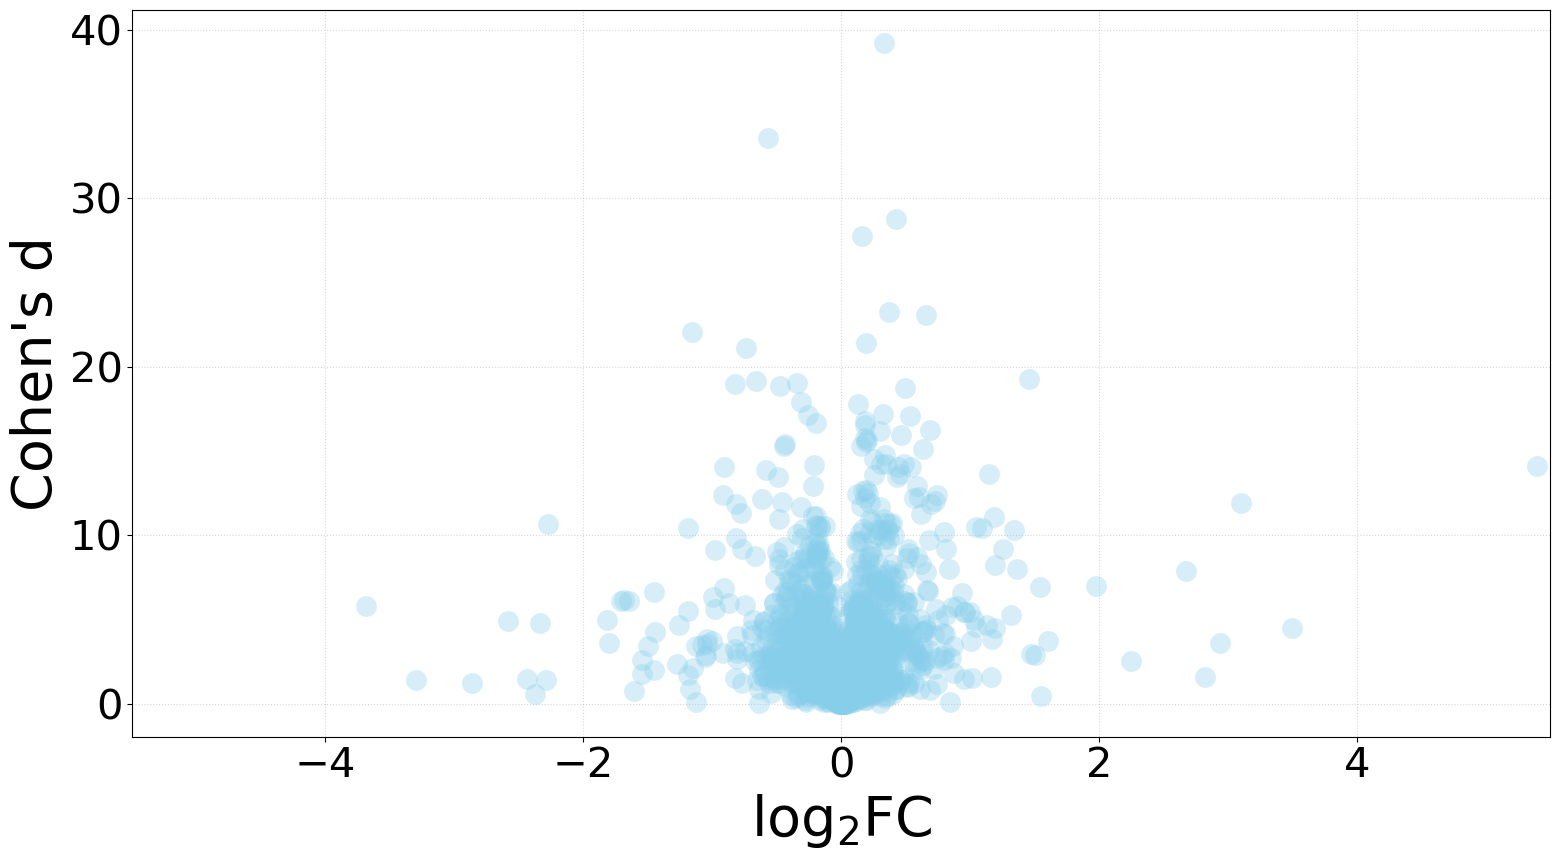

Benjamini-Hochberg correction
epsilon: 3.2221090692643823

BIOMAKER
 P05362 ICAM-1 39 1.688214447750836 black 


BIOMAKER
 P05121 PAI-1 -13 1.054393675809898 black 


BIOMAKER
 P13598 ICAM-2 5 0.7604462823081779 black 



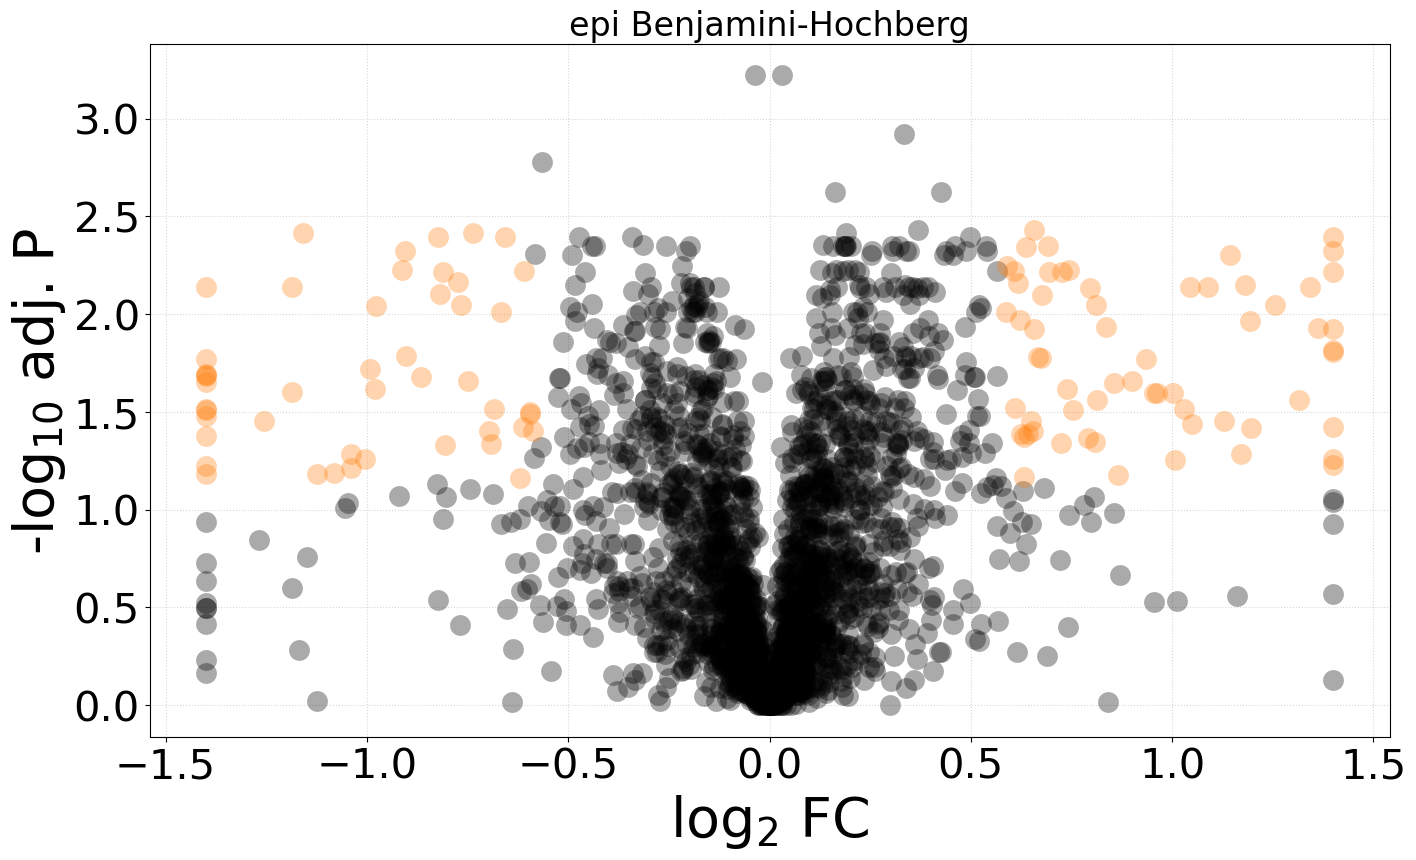

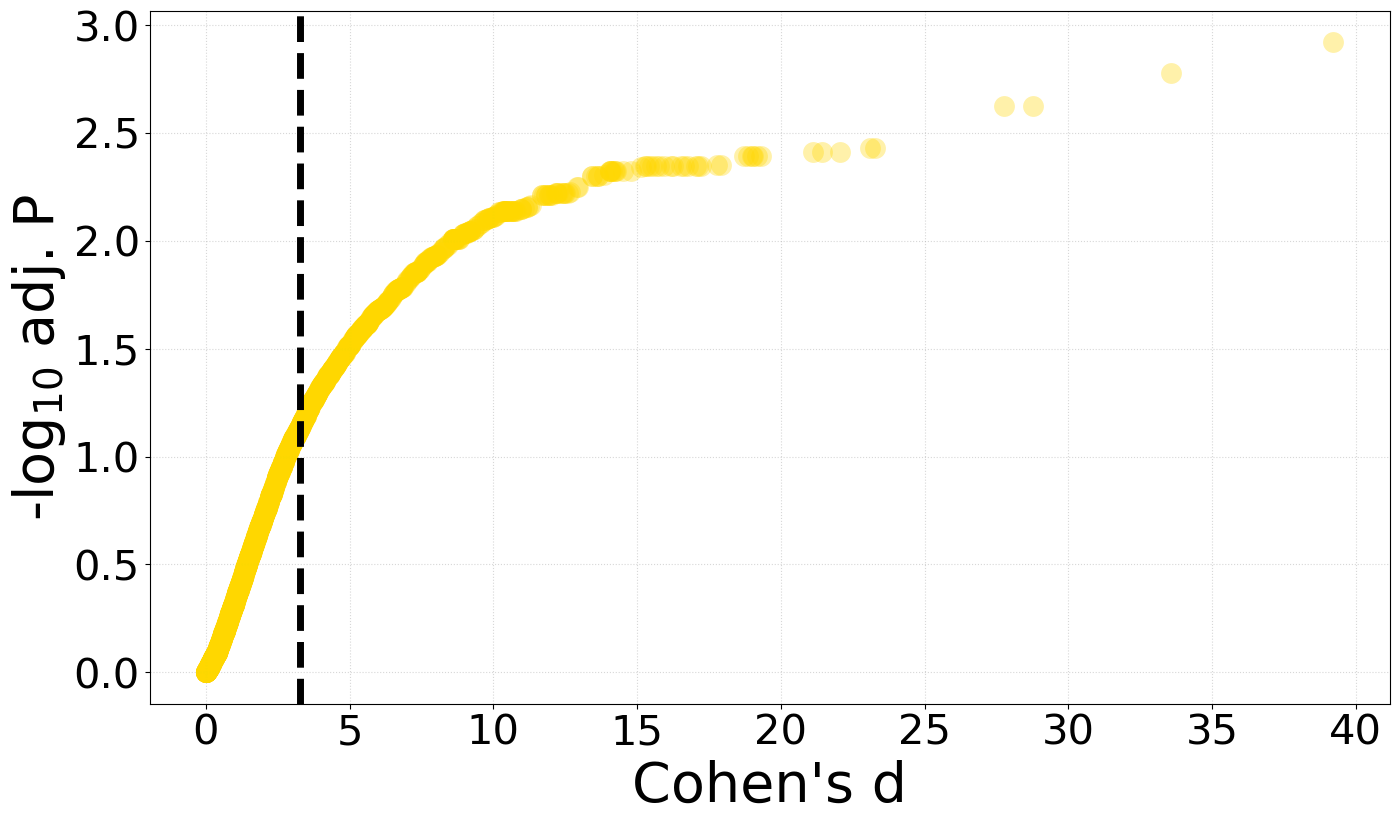

109 proteins respond to treatment


In [32]:
#%%time
treatment_label = 'epi'
treatment_color = 'tab:orange'
control_samples = ['20220905_ARNAR_' + element for element in ['010', '011']]
treated_samples = ['20220905_ARNAR_' + element for element in ['005', '004', '009', '008']]
epi_response = comparison_function('4h', detected_biomarkers, qndf, treatment_label, treatment_color, control_samples, treated_samples)

In [33]:
four_input_file = '/Users/adrian/gd15/tmp/HPMVEC_Proteomics_September_2022/HPMVECs_september2022_4h_all_prts_Relative_Quantification.csv'
# twentyfour_input_file = '/Users/adrian/gd15/tmp/HPMVEC_Proteomics_September_2022/HPMVECs_september2022_24h_all_prts_Relative_Quantification.csv'

Cohen's d for this case of 6 samples is 3.257188
P before correction 0.0 1.0


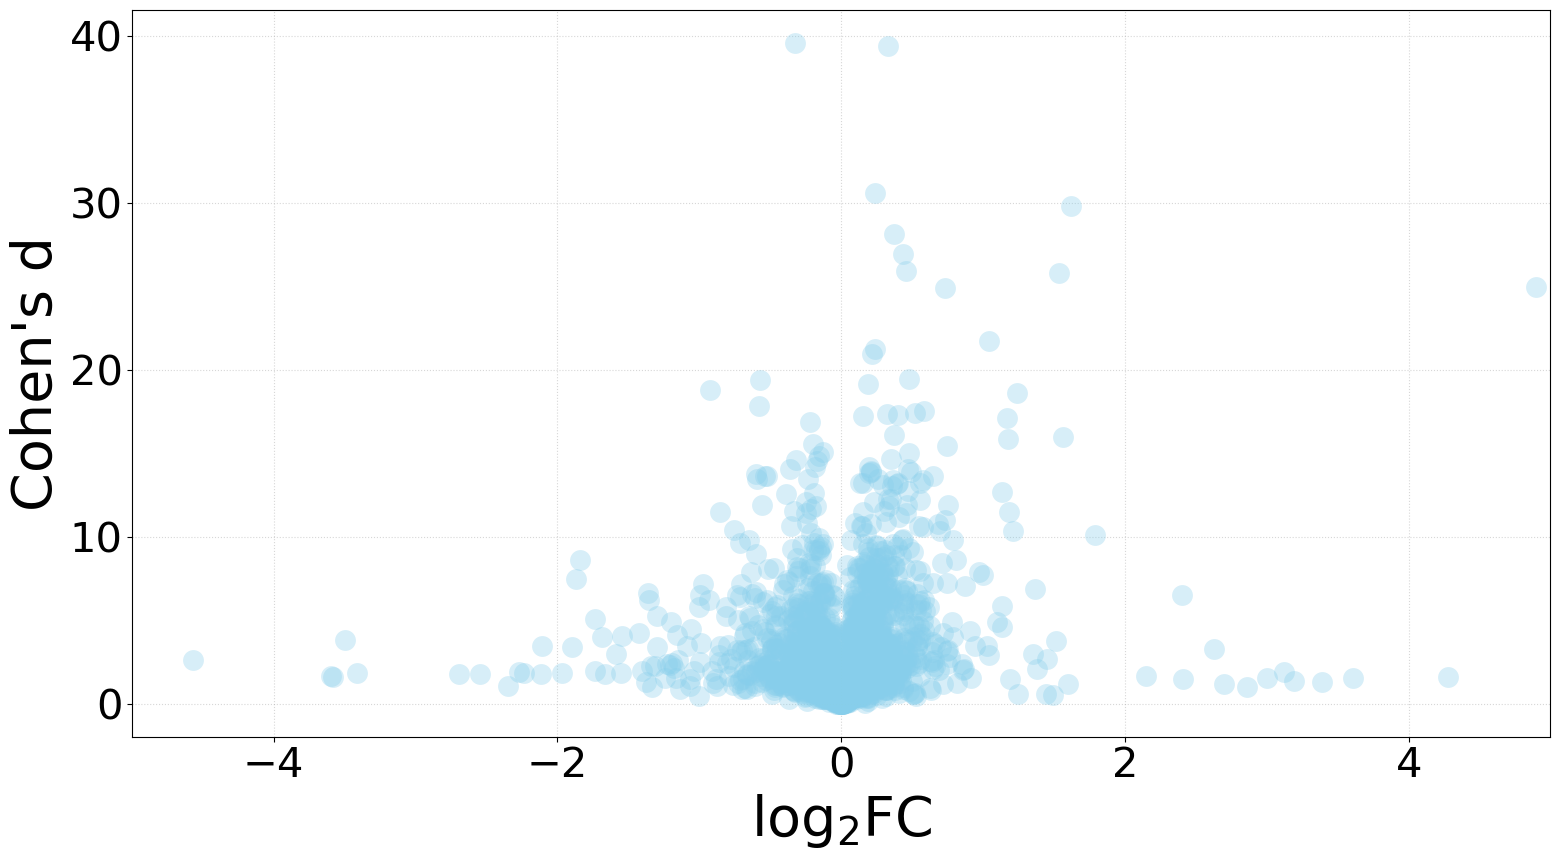

Benjamini-Hochberg correction
epsilon: 3.355813050767687

BIOMAKER
 P05362 ICAM-1 44 1.9462340959178608 black 


BIOMAKER
 P05121 PAI-1 -23 1.271436224366908 black 


BIOMAKER
 P13598 ICAM-2 15 0.7672743844557803 black 



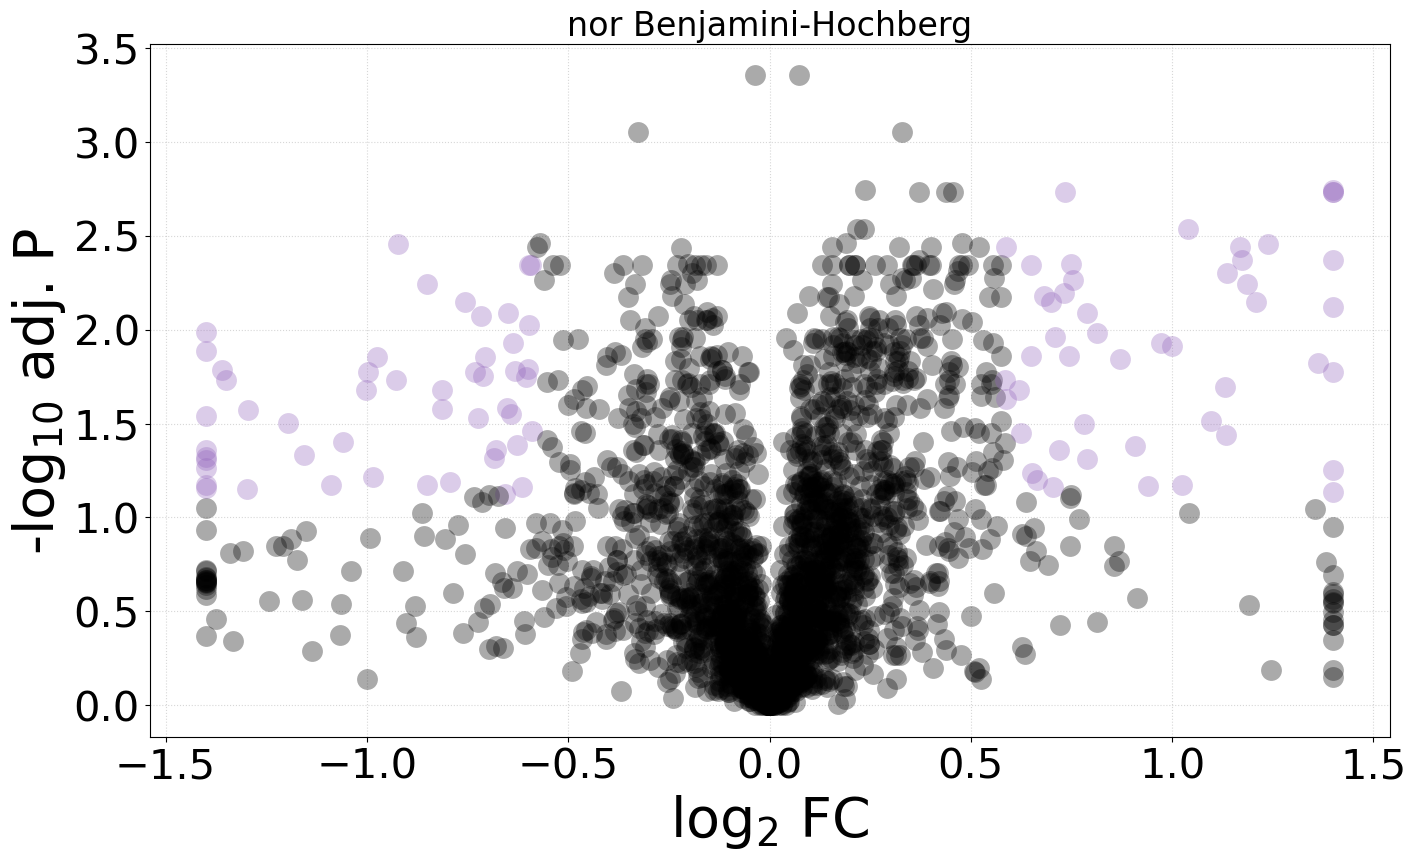

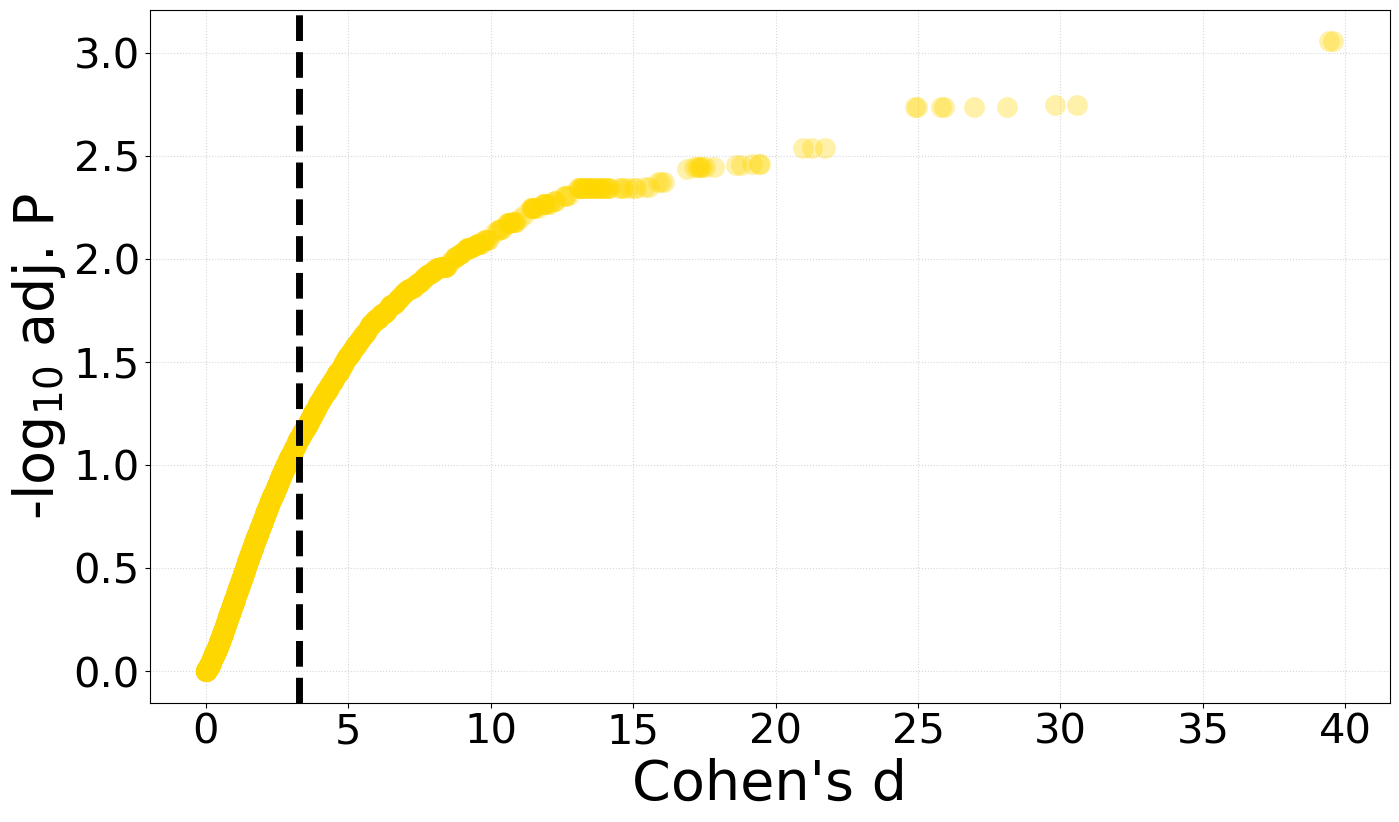

98 proteins respond to treatment


In [34]:
treatment_label = 'nor'
treatment_color = 'tab:purple'
control_samples = ['20220905_ARNAR_' + element for element in ['010', '011']]
treated_samples = ['20220905_ARNAR_' + element for element in ['020', '019', '014', '013']]
nor_response = comparison_function('4h', detected_biomarkers, qndf, treatment_label, treatment_color, control_samples, treated_samples)

Cohen's d for this case of 6 samples is 3.257188
P before correction 0.0 1.0


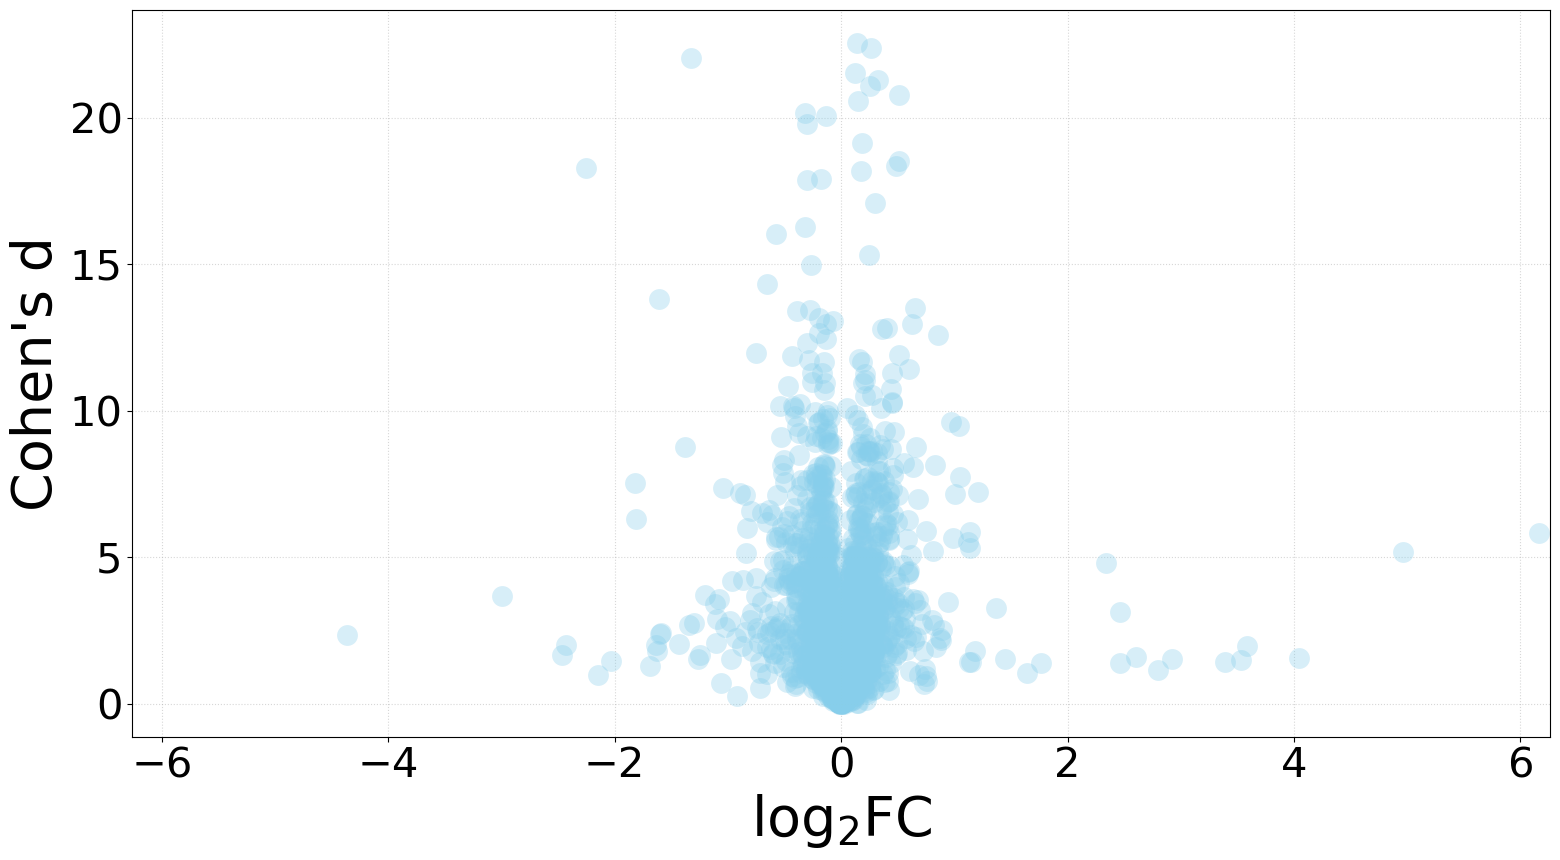

Benjamini-Hochberg correction
epsilon: 2.663842310444469

BIOMAKER
 P05362 ICAM-1 2 0.17287886407309852 black 


BIOMAKER
 P05121 PAI-1 10 0.9886223163115369 black 


BIOMAKER
 P13598 ICAM-2 -2 0.13143182562320813 black 



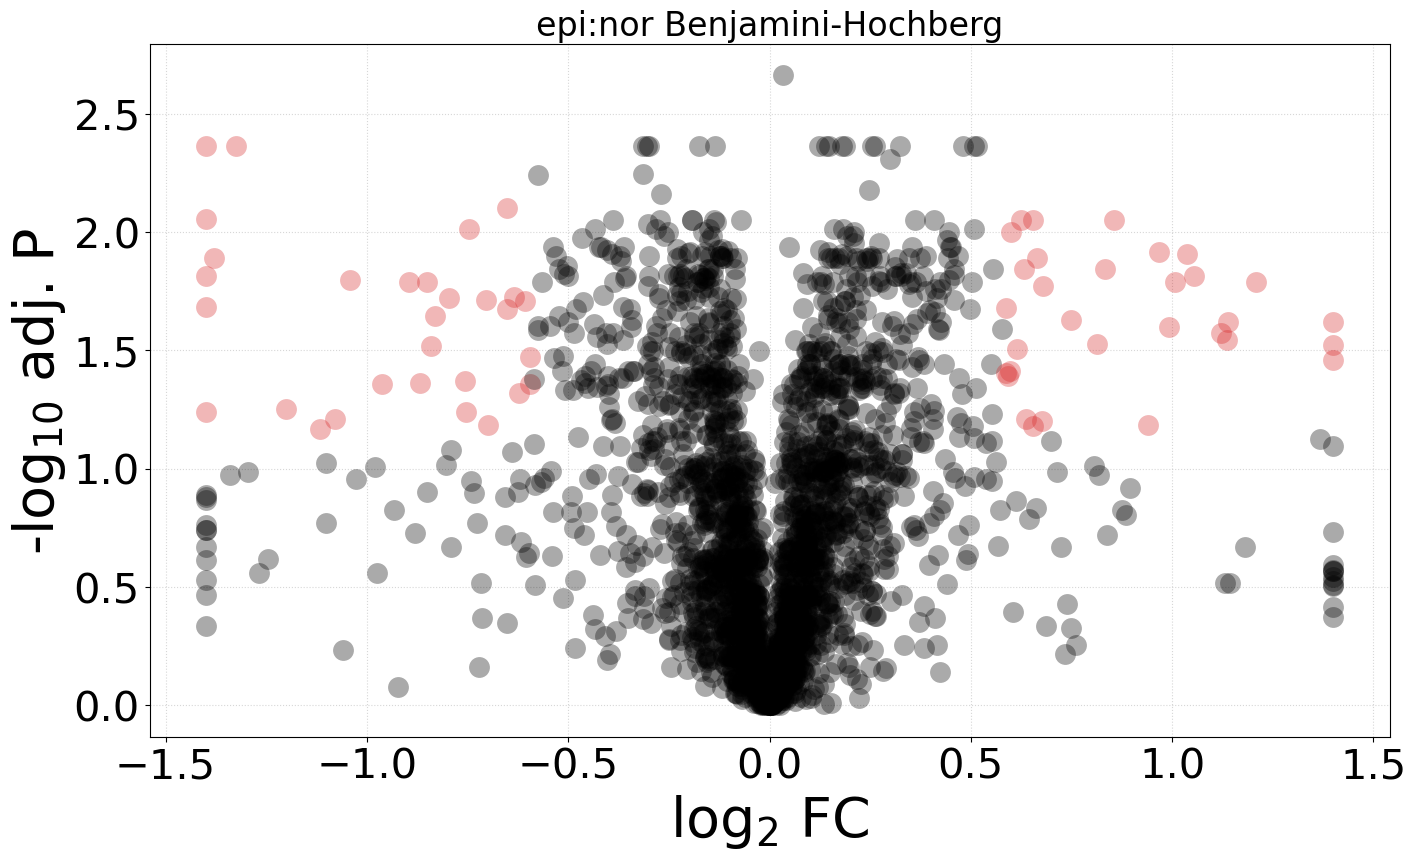

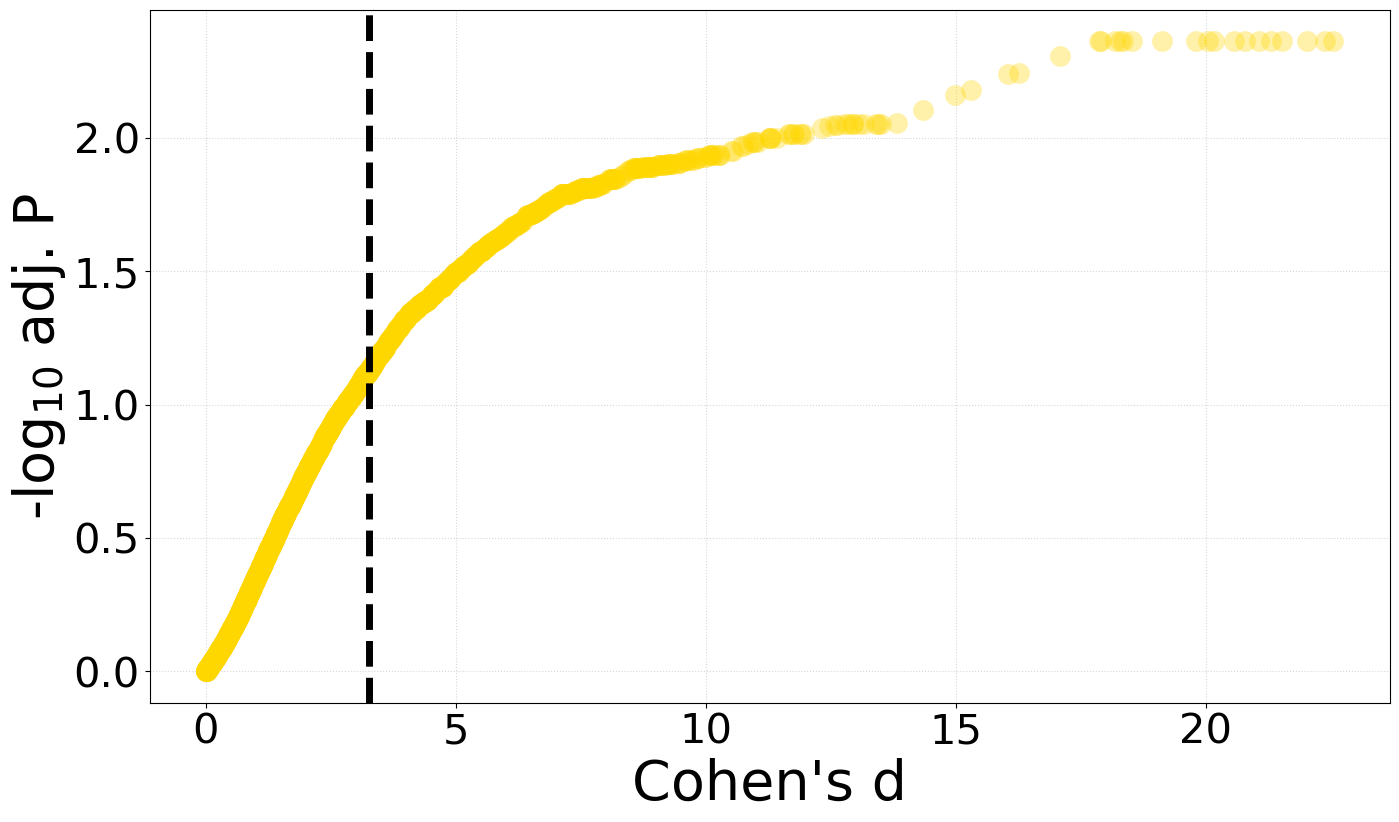

61 proteins respond to treatment


In [35]:
treatment_label = 'epi:nor'
treatment_color = 'tab:red'
control_samples = ['20220905_ARNAR_' + element for element in ['010', '011']]
treated_samples = ['20220905_ARNAR_' + element for element in ['025', '024', '026', '027']]
epinor_response = comparison_function('4h', detected_biomarkers, qndf, treatment_label, treatment_color, control_samples, treated_samples)

### Venn diagram of treatmens

In [36]:
epi_set = set(epi_response)
nor_set = set(nor_response)
epinor_set = set(epinor_response)

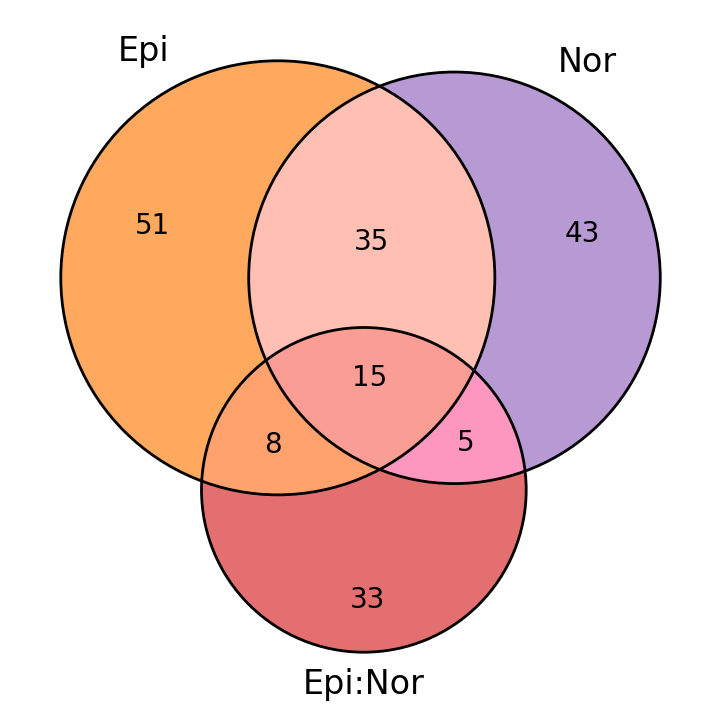

In [37]:
matplotlib_venn.venn3(
    [epi_set, nor_set, epinor_set], 
    set_labels=('Epi', 'Nor', 'Epi:Nor'),
    set_colors=('tab:orange', 'tab:purple', 'tab:red'),
    alpha=2/3
)
matplotlib_venn.venn3_circles(
    [epi_set, nor_set, epinor_set],
    linewidth=2
)
matplotlib.pyplot.show()

In [38]:
epi_only = epi_set - nor_set - epinor_set
nor_only = nor_set - epi_set - epinor_set
epinor_only = epinor_set - epi_set - nor_set

epi_and_nor = epi_set & nor_set - epinor_set
epi_and_epinor = epi_set & epinor_set - nor_set
nor_and_epinor = nor_set & epinor_set - epi_set

intersect = epi_set & nor_set & epinor_set

print(len(epi_only), len(nor_only), len(epinor_only))
print(len(epi_and_nor), len(epi_and_epinor), len(nor_and_epinor))
print(len(intersect))
print()

# build a list and create files
labels = ['epi_only', 'nor_only', 'epinor_only', 'epi_and_nor', 'epi_and_epinor', 'nor_and_epinor', 'intersect']
lists = [epi_only, nor_only, epinor_only, epi_and_nor, epi_and_epinor, nor_and_epinor, intersect]
for i in range(len(labels)):
    f = open(output_dir + labels[i] + '.4h..tsv', 'w')
    f.write('Uniprot\tDescription\n')
    for protein in lists[i]:
        content = f'{protein}\t{rosetta[protein]}\n'
        f.write(content)
    f.close()
    print(f'closing {labels[i]}')

51 43 33
35 8 5
15

closing epi_only
closing nor_only
closing epinor_only
closing epi_and_nor
closing epi_and_epinor
closing nor_and_epinor
closing intersect


# LATE samples

### define metadata

In [39]:
metadata = {}

metadata['24h control'] = ['20220905_ARNAR_022', '20220905_ARNAR_023', '20220905_ARNAR_037', '20220905_ARNAR_038', '20220905_ARNAR_067', '20220905_ARNAR_068']

metadata['24h epi'] = ['20220905_ARNAR_031', '20220905_ARNAR_040']

metadata['24h nor'] = ['20220905_ARNAR_028', '20220905_ARNAR_053', '20220905_ARNAR_054', '20220905_ARNAR_062']

metadata['24h epinor'] = ['20220905_ARNAR_006', '20220905_ARNAR_007', '20220905_ARNAR_033', '20220905_ARNAR_034', '20220905_ARNAR_055']

metadata['24h TNFa'] = ['20220905_ARNAR_015', '20220905_ARNAR_016', '20220905_ARNAR_017', '20220905_ARNAR_018', '20220905_ARNAR_042', '20220905_ARNAR_043']

all_sample_names = [element for sublist in list(metadata.values()) for element in sublist]
print(len(all_sample_names))

23


### manipulate data

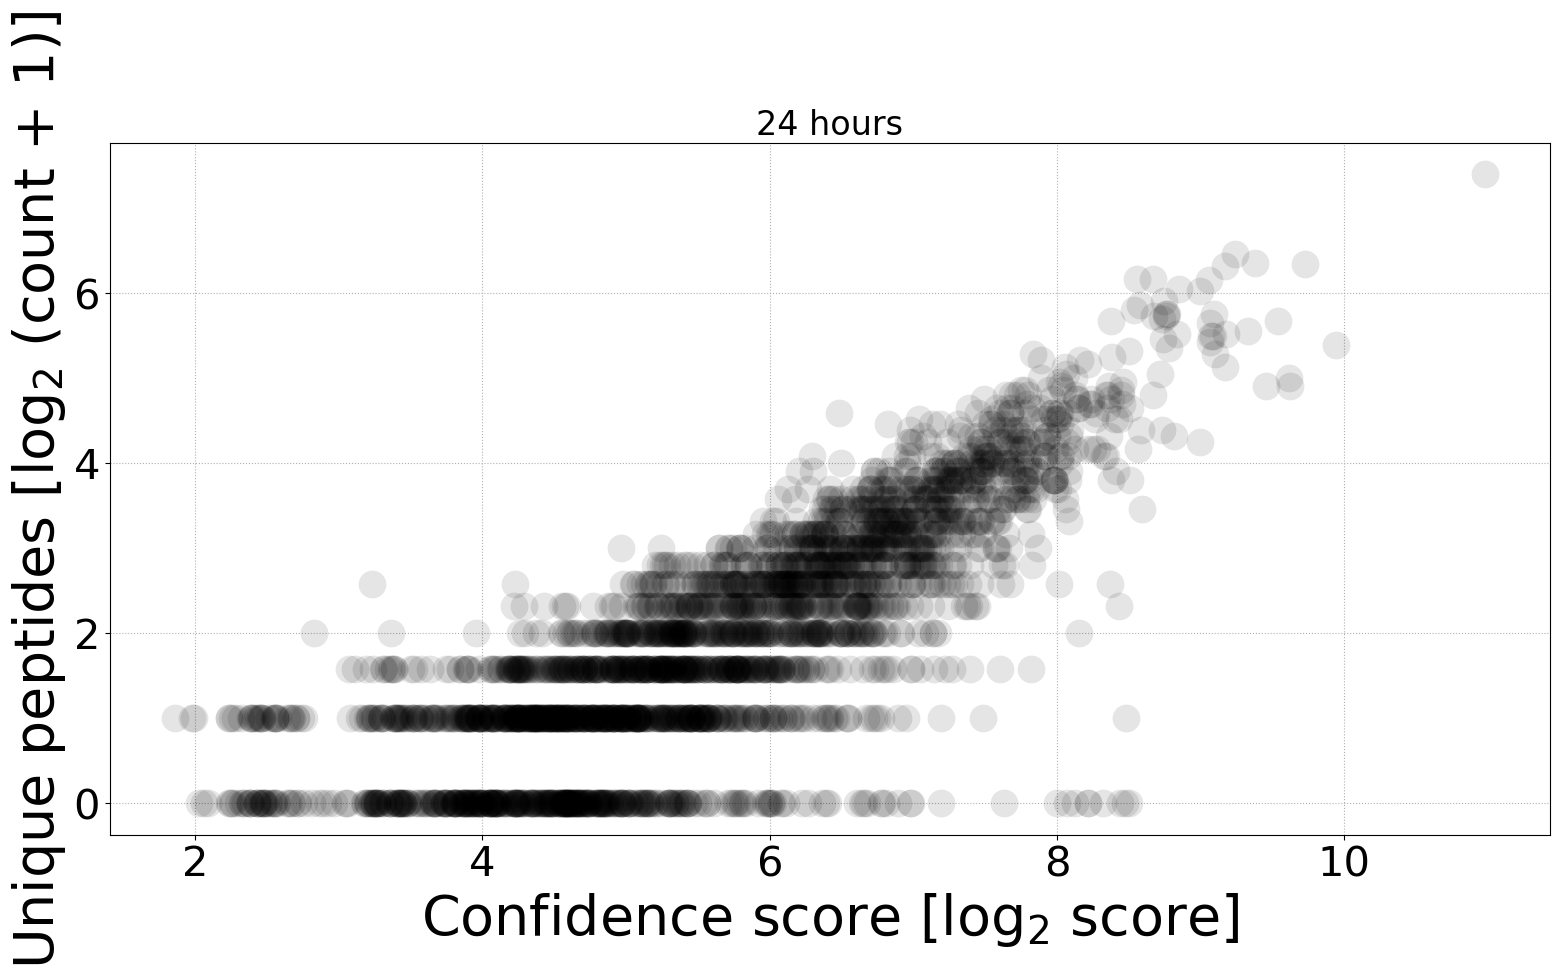

In [40]:
x = numpy.log2(df24['Confidence score'])
y = numpy.log2(df24['Unique peptides']+1)
               
matplotlib.pyplot.plot(x, y, 'o', color='black', alpha=1/10, markeredgecolor='None', ms=20)

matplotlib.pyplot.xlabel('Confidence score [log$_2$ score]')
matplotlib.pyplot.ylabel('Unique peptides [log$_2$ (count + 1)]')
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.title('24 hours')
matplotlib.pyplot.tight_layout()

Arbitrary thresholds for minimal identifications:
- X-axis: a score of >= 50.
- Y-axis: at least three unique peptides.

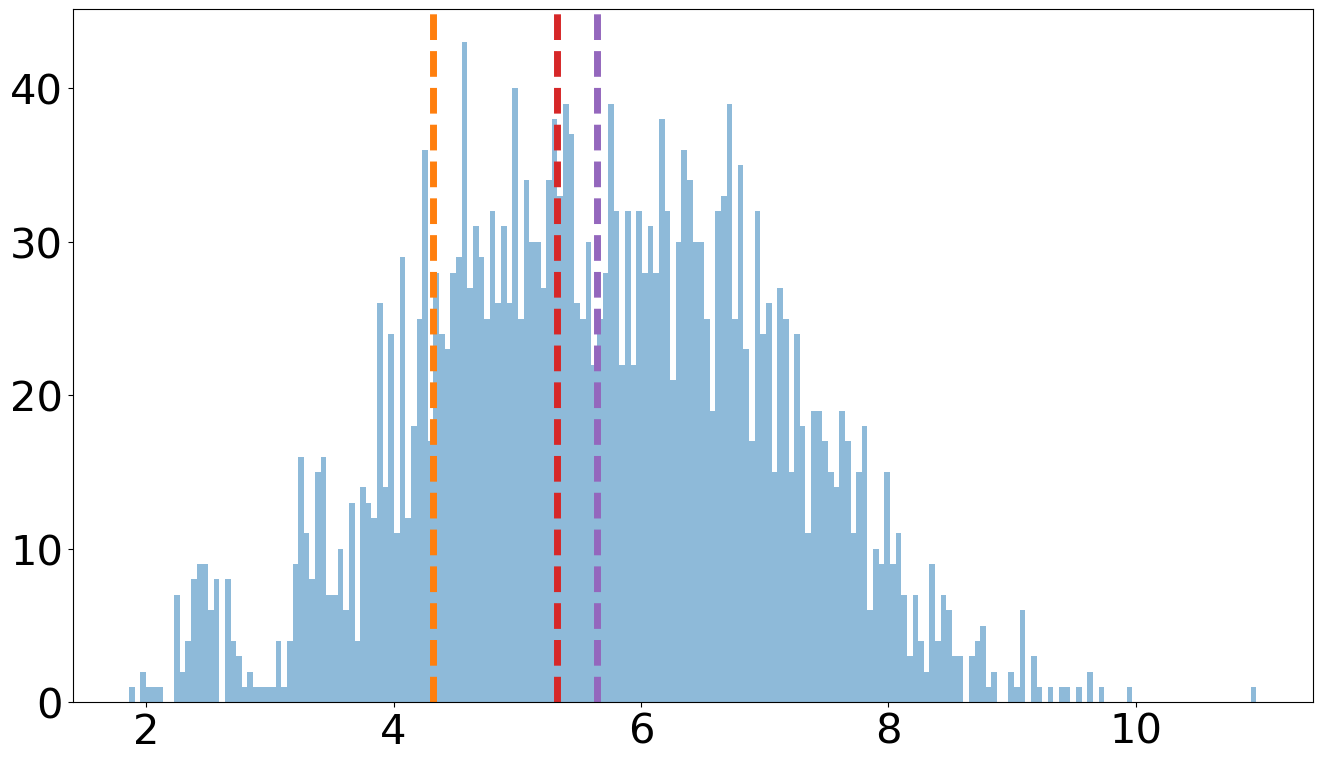

In [41]:
matplotlib.pyplot.hist(numpy.log2(df24['Confidence score']), bins=200, alpha=1/2, color='tab:blue')
matplotlib.pyplot.axvline(x=numpy.log2(20), lw=5, ls='--', color='tab:orange')
matplotlib.pyplot.axvline(x=numpy.log2(40), lw=5, ls='--', color='tab:red')
matplotlib.pyplot.axvline(x=numpy.log2(50), lw=5, ls='--', color='tab:purple')
matplotlib.pyplot.show()

In [42]:
new24 = df24[(df24['Unique peptides'] >= 1) & (df24['Confidence score'] >= 0)]
print(new24.shape)

working_labels = [label for label in new24.columns if label in all_sample_names]

new24 = numpy.log2(new24.loc[:, working_labels] + 1)
print(new24.shape)
new24

(2241, 83)
(2241, 23)


20220905_ARNAR_022  20220905_ARNAR_023  \
Accession                                                                    
P05362                                       12.136222           12.096396   
P00918                                        3.269640            3.958573   
Q00005                                        9.832451            9.948856   
P07093                                        9.780167            9.588543   
Q8N0U7                                        9.572838            9.332522   
...                                                ...                 ...   
Q9NTJ4                                       12.825811           12.821668   
P60981                                       12.949406           12.950136   
Q8TBY8                                       10.843945           10.750298   
Q9HCF6                                       12.937486           12.919516   
O94851;A6NMT0;O43151;P50897;Q8N865           13.992718           14.006149   

                                    20220905_ARNAR_037  20220905_ARNAR_038  \
Accession                                                                    
P05362                                       12.003133           12.087096   
P00918                                        4.044389            2.560914   
Q00005                                        9.968576            9.886719   
P07093                                        9.737447            9.707263   
Q8N0U7                                        9.741558            9.213716   
...                                                ...                 ...   
Q9NTJ4                                       12.951944           13.074719   
P60981                                       12.855742           12.883994   
Q8TBY8                                       10.496738           10.660448   
Q9HCF6                                       12.849802           12.934045   
O94851;A6NMT0;O43151;P50897;Q8N865           13.955995           14.146705   

                                    20220905_ARNAR_067  20220905_ARNAR_068  \
Accession                                                                    
P05362                                       12.063444           11.987530   
P00918                                        2.581108            2.400893   
Q00005                                       10.013001            9.969310   
P07093                                        9.999880            9.655704   
Q8N0U7                                        9.017280            9.037082   
...                                                ...                 ...   
Q9NTJ4                                       13.008411           12.993811   
P60981                                       13.061916           12.963713   
Q8TBY8                                       10.633689           10.464231   
Q9HCF6                                       13.055863           12.955092   
O94851;A6NMT0;O43151;P50897;Q8N865           14.152282           14.107456   

                                    20220905_ARNAR_015  20220905_ARNAR_016  \
Accession                                                                    
P05362                                       15.026937           15.053167   
P00918                                        3.383701            2.577989   
Q00005                                        9.883095            9.763771   
P07093                                        9.096160            9.124853   
Q8N0U7                                        9.007429            9.010905   
...                                                ...                 ...   
Q9NTJ4                                       12.781201           12.802997   
P60981                                       12.877931           12.710013   
Q8TBY8                                       10.523887           10.402698   
Q9HCF6                                       12.668605           12.674253   
O94851;A6NMT0;O43151;P50897;Q8N865           13.974448 

### visualize data

210
20220905_ARNAR_006
20220905_ARNAR_007
20.44118100653228


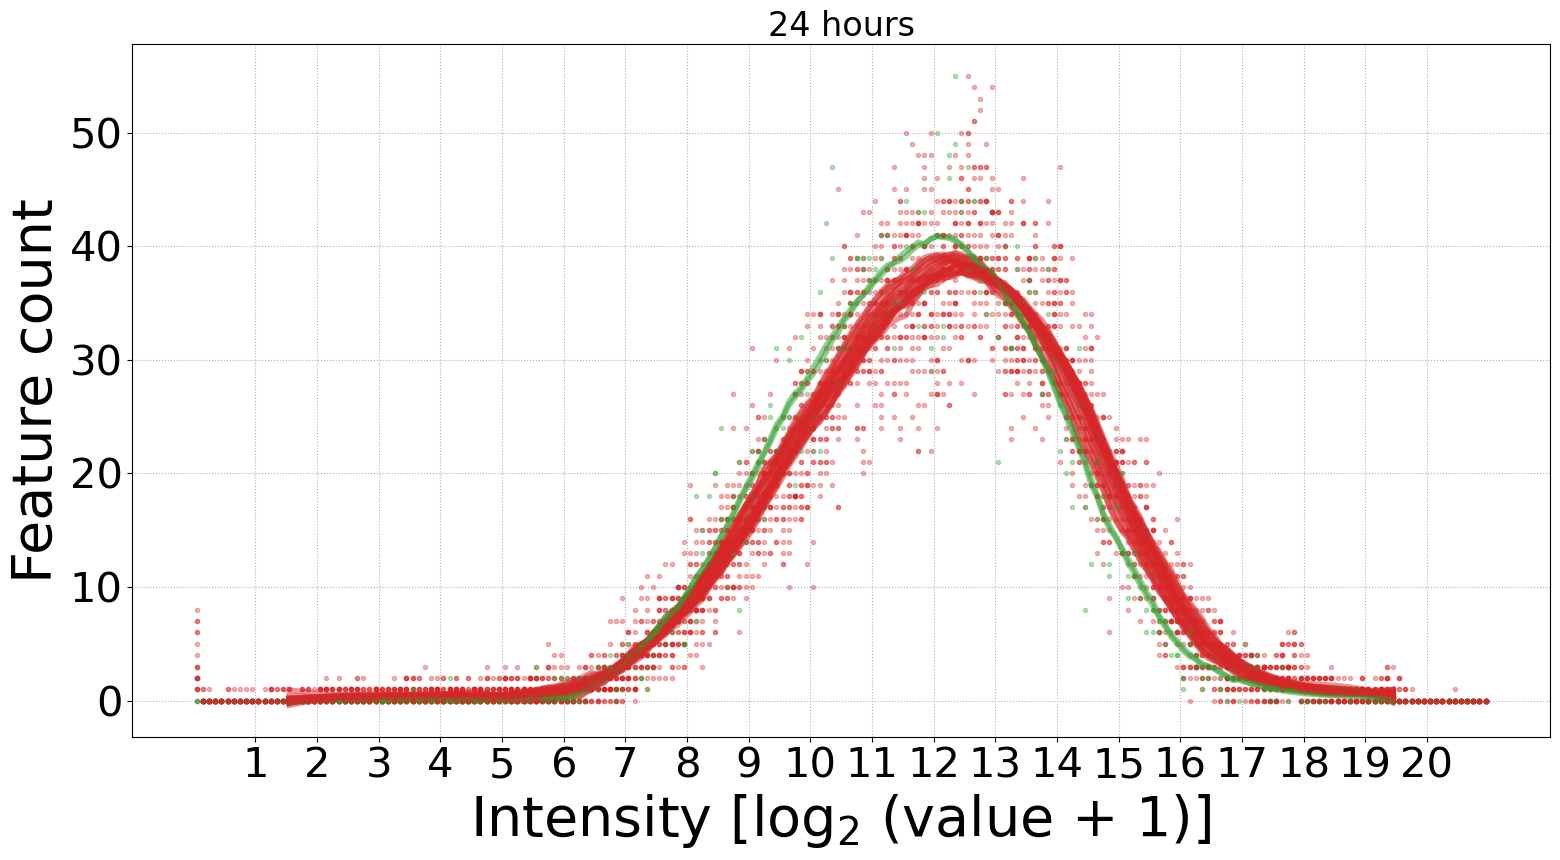

In [43]:
found_max = 21
number_of_bins = found_max * 10
margin = 15
print(number_of_bins)

absolute_max = 0
plotting_x = []; plotting_y = []
most_likely_early = []

for sample in new24.columns:
        
    intensities = new24.loc[:, sample]
    
    # histogram
    hist, bin_edges = numpy.histogram(intensities, bins=number_of_bins, range=(0, found_max))
    half_bin = (bin_edges[1] - bin_edges[0])/2
    x = bin_edges + half_bin
    x = x[:-1]
    
    # curve fitting
    plotting_x = x[margin:-margin]
    plotting_hist = hist[margin:-margin]
    yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
    
    # storing info to quantify bias
    most_likely_intensity = x[numpy.argmax(yhat)]
    most_likely_early.append(most_likely_intensity)
    
    
    # plotting
    the_color = 'tab:red'
    if '006' in sample or '007' in sample:
        the_color = 'tab:green'
        print(sample)
    matplotlib.pyplot.plot(x, hist, '.', alpha=1/3, color=the_color)
    matplotlib.pyplot.plot(plotting_x, yhat, '-', lw=4, alpha=1/2, color=the_color)
    
    # check
    if max(intensities) > absolute_max:
        absolute_max = max(intensities)

# check print
print(absolute_max)

matplotlib.pyplot.xticks(range(1, 21))
matplotlib.pyplot.xlabel('Intensity [log$_2$ (value + 1)]')
matplotlib.pyplot.ylabel('Feature count')
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.title('24 hours')
matplotlib.pyplot.tight_layout()

### normalization

In [44]:
#
# quantile normalization 
# taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
#

# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(new24.values, axis=0), index=new24.index, columns=new24.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
qndf = new24.rank(method="min").stack().astype(int).map(df_mean).unstack()

### distributions after normalization

210
19.408569280865084


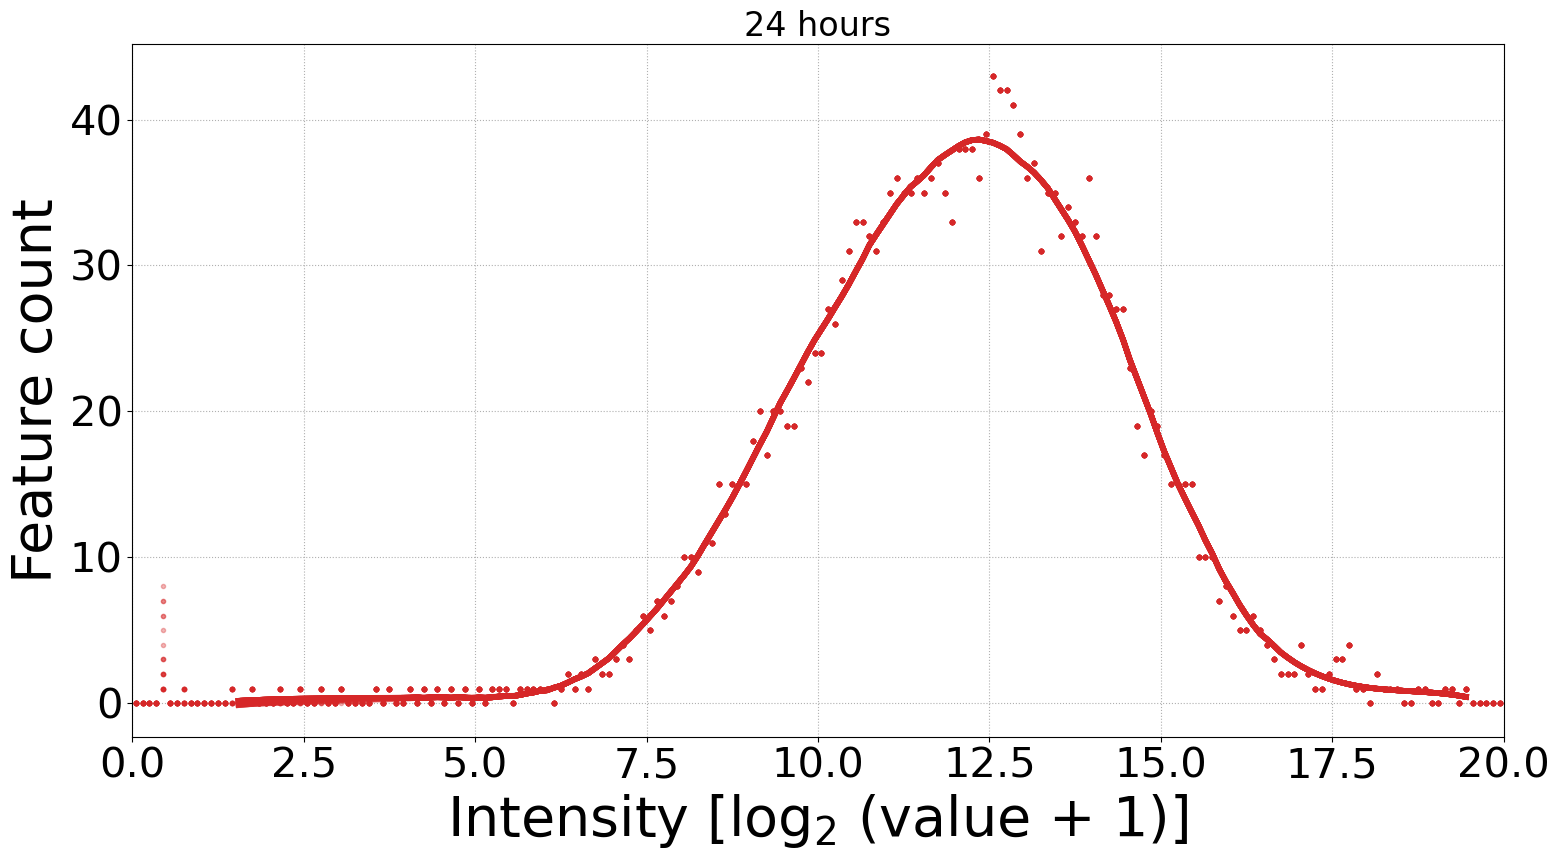

In [45]:
found_max = 21
number_of_bins = found_max * 10
margin = 15
print(number_of_bins)

absolute_max = 0
plotting_x = []; plotting_y = []
most_likely_early = []

for sample in qndf.columns:
        
    intensities = qndf.loc[:, sample]
    
    # histogram
    hist, bin_edges = numpy.histogram(intensities, bins=number_of_bins, range=(0, found_max))
    half_bin = (bin_edges[1] - bin_edges[0])/2
    x = bin_edges + half_bin
    x = x[:-1]
    
    # curve fitting
    plotting_x = x[margin:-margin]
    plotting_hist = hist[margin:-margin]
    yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
    
    # storing info to quantify bias
    most_likely_intensity = x[numpy.argmax(yhat)]
    most_likely_early.append(most_likely_intensity)
    
    
    # plotting
    the_color = 'tab:red'
    matplotlib.pyplot.plot(x, hist, '.', alpha=1/3, color=the_color)
    matplotlib.pyplot.plot(plotting_x, yhat, '-', lw=4, alpha=1/2, color=the_color)
    
    # check
    if max(intensities) > absolute_max:
        absolute_max = max(intensities)

# check print
print(absolute_max)

matplotlib.pyplot.xlim(0,20)
matplotlib.pyplot.xlabel('Intensity [log$_2$ (value + 1)]')
matplotlib.pyplot.ylabel('Feature count')
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.title('24 hours')
matplotlib.pyplot.tight_layout()

In [46]:
### biomarker analysis

In [47]:
detected_biomarkers = {}
for biomarker in biomarkers.keys():
    uniprot_id = biomarkers[biomarker]
    print('working with biomarker {}, uniprot {}'.format(biomarker, uniprot_id))
    for element in df24.index:
        if uniprot_id in element:
            print('\t{}, peptide count {}, score {}'.format(element, df24.loc[element, 'Unique peptides'], df24.loc[element, 'Confidence score']))
            detected_biomarkers[element] = biomarker

detected_biomarkers.keys()

working with biomarker endothelin, uniprot P05305
working with biomarker PAI-1, uniprot P05121
	P05121, peptide count 19, score 160.2717
working with biomarker uPA, uniprot P00749
working with biomarker VCAM-1, uniprot P19320
working with biomarker L-selectin, uniprot P14151
working with biomarker Ang2, uniprot O15123
working with biomarker VEGFr1, uniprot P17948
working with biomarker ICAM-2, uniprot P13598
	P13598, peptide count 3, score 61.8311
working with biomarker tie2, uniprot Q02763
working with biomarker IL-6, uniprot P05231
working with biomarker E-selectin, uniprot P16581
working with biomarker ICAM-1, uniprot P05362
	P05362, peptide count 14, score 73.6527
working with biomarker P-selectin, uniprot P16109
working with biomarker Ang1, uniprot Q15389
working with biomarker vWF, uniprot P04275
working with biomarker PDGF, uniprot P01127
working with biomarker endocan, uniprot Q9NQ30
working with biomarker TNFa, uniprot P01375
working with biomarker VEGFa, uniprot P15692


dict_keys(['P05121', 'P13598', 'P05362'])

P05121 24h control
P05121 24h epi
P05121 24h nor
P05121 24h epinor
P05121 24h TNFa
PAI-1 [15.77791873779686, 16.506018652668043, 16.182219676588296, 16.073347514233873, 15.851509838137147]
P13598 24h control
P13598 24h epi
P13598 24h nor
P13598 24h epinor
P13598 24h TNFa
ICAM-2 [11.13755320726791, 11.456592417263156, 11.206232688507658, 11.139009390716408, 11.12209357215333]
P05362 24h control
P05362 24h epi
P05362 24h nor
P05362 24h epinor
P05362 24h TNFa
ICAM-1 [12.000707581568099, 12.146372944033718, 12.038355926843032, 12.05953126791627, 15.043300359444467]
{'PAI-1': [0.0, 0.7280999148711835, 0.4043009387914367, 0.2954287764370136, 0.0735911003402876], 'ICAM-2': [0.0, 0.31903920999524615, 0.06867948123974799, 0.0014561834484982938, -0.015459635114579484], 'ICAM-1': [0.0, 0.14566536246561945, 0.03764834527493299, 0.05882368634817148, 3.0425927778763686]}


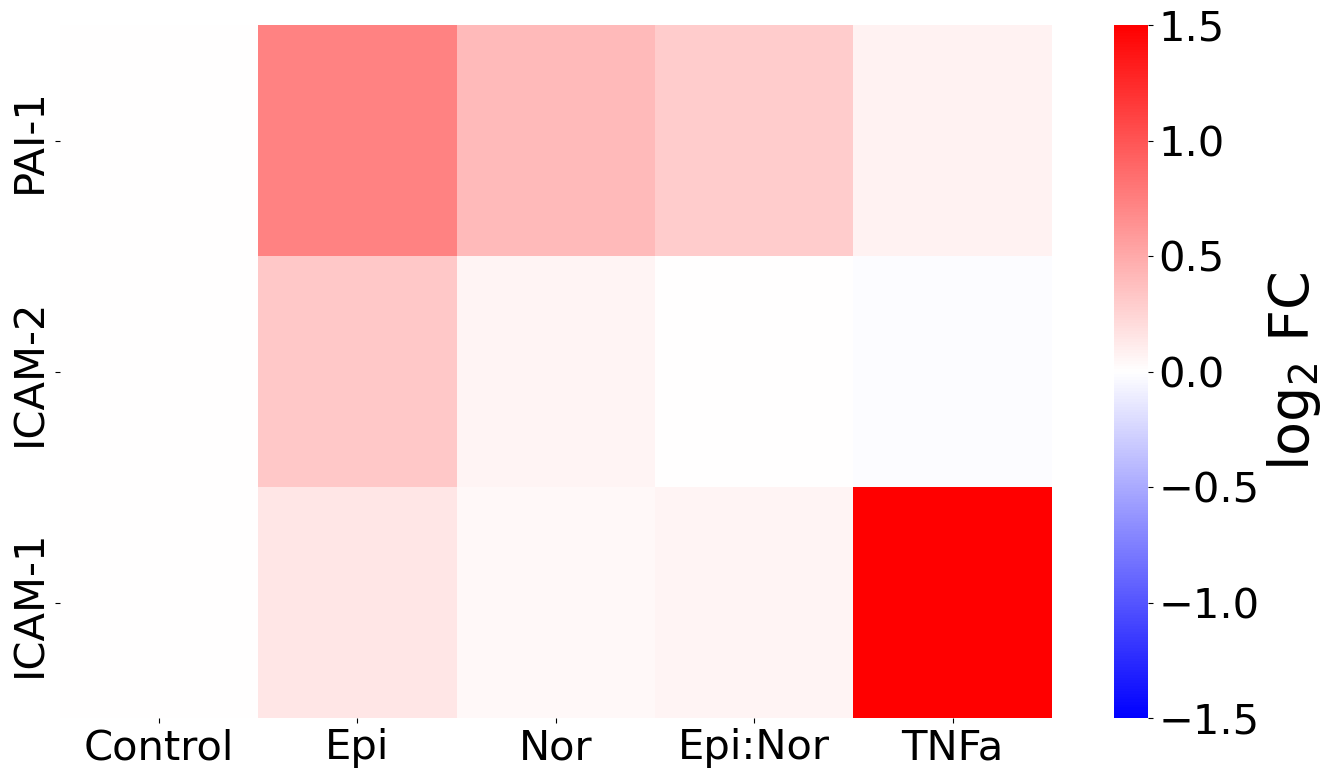

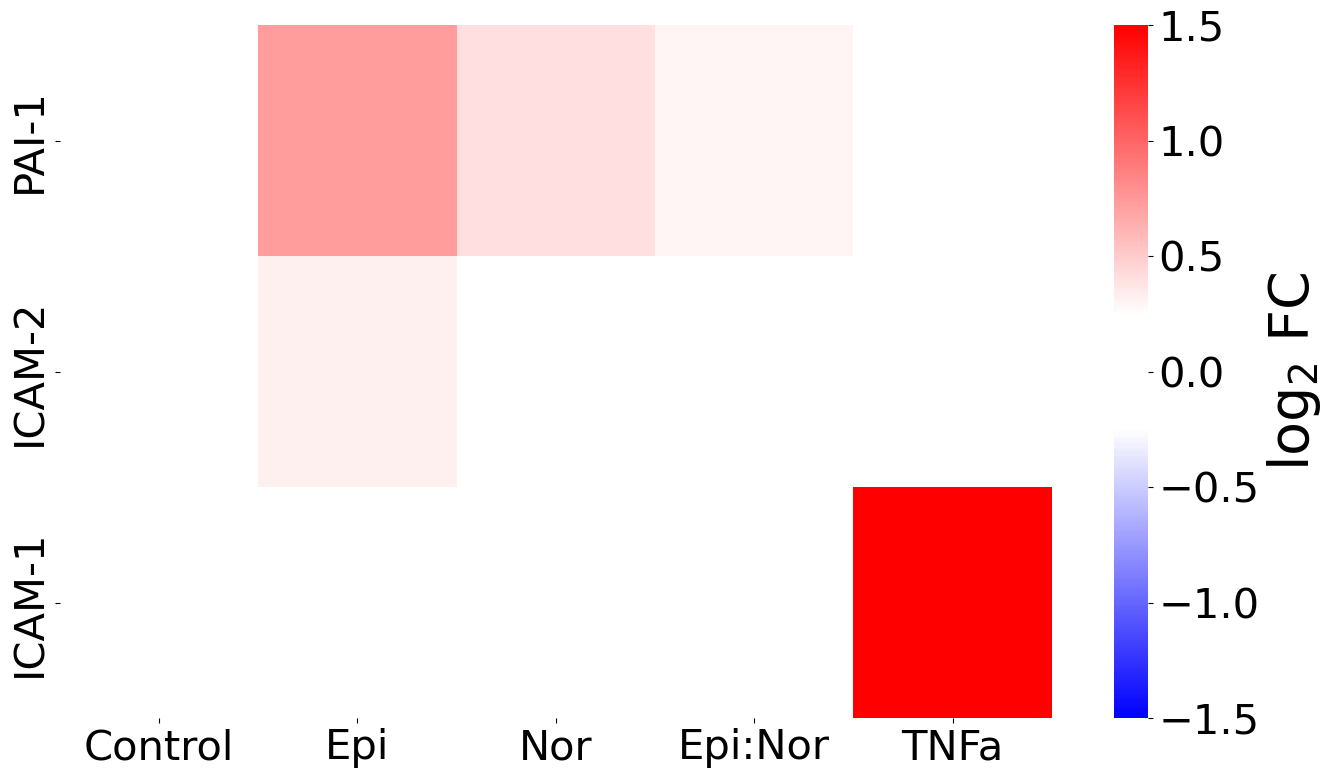

In [48]:
# gererate data for heatmap
heatmap_data = {}
for marker in detected_biomarkers.keys():
    heatmap_data[detected_biomarkers[marker]] = []
    for treatment in metadata.keys():
        print(marker, treatment)
        log2_intensity = numpy.median(qndf.loc[marker, metadata[treatment]].values)
        heatmap_data[detected_biomarkers[marker]].append(log2_intensity)
    print(detected_biomarkers[marker], heatmap_data[detected_biomarkers[marker]])

for biomarker in heatmap_data:
    reference = heatmap_data[biomarker][0]
    for i in range(len(heatmap_data[biomarker])):
        heatmap_data[biomarker][i] = heatmap_data[biomarker][i] - reference
print(heatmap_data)
heatmap_df = pandas.DataFrame.from_dict(heatmap_data).transpose()
heatmap_df.columns = ['Control', 'Epi', 'Nor', 'Epi:Nor', 'TNFa']

colors = [(0, "blue"), (0.5-(1/12), "white"), (0.5+(1/12), "white"), (1, "red")]
bwwr = matplotlib.colors.LinearSegmentedColormap.from_list("bwwr", colors)

seaborn.heatmap(data=heatmap_df, cmap='bwr', vmin=-1.5, vmax=1.5, cbar_kws={'label':'log$_2$ FC'})
matplotlib.pyplot.show()

seaborn.heatmap(data=heatmap_df, cmap=bwwr, vmin=-1.5, vmax=1.5, cbar_kws={'label':'log$_2$ FC'})
matplotlib.pyplot.show()

### PCA

[0.31572255 0.16064776]


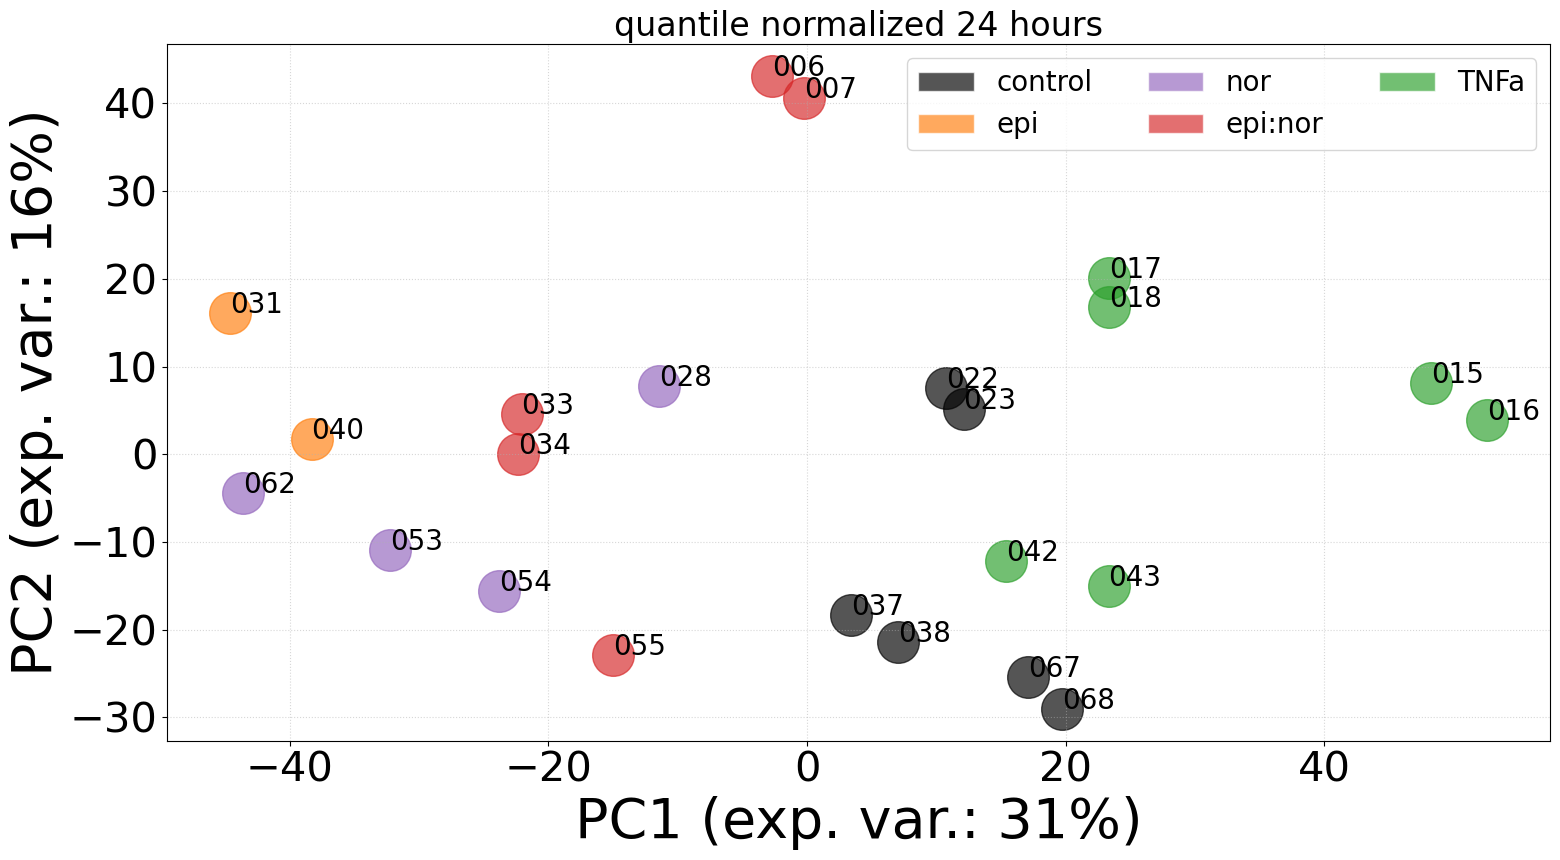

In [49]:
# quantile normalized all
transpose = qndf.transpose()
scaled_data = sklearn.preprocessing.StandardScaler().fit_transform(transpose)
model = sklearn.decomposition.PCA(n_components=2)
locations = model.fit_transform(scaled_data)
explained = model.explained_variance_ratio_
print(explained)

for i in range(len(locations)):
    
    the_marker = 'o'
    the_label = qndf.columns[i].split('_')[-1]
        
    if qndf.columns[i] in metadata['24h control']:
        the_color = 'black'
    elif qndf.columns[i] in metadata['24h epi']:
        the_color = 'tab:orange'
    elif qndf.columns[i] in metadata['24h nor']:
        the_color = 'tab:purple'
    elif qndf.columns[i] in metadata['24h epinor']:
        the_color = 'tab:red'
    elif qndf.columns[i] in metadata['24h TNFa']:
        the_color = 'tab:green'
    else:
        raise ValueError('sample not classified')
    
    matplotlib.pyplot.scatter(locations[i,0], locations[i,1], s=900, c=the_color, marker=the_marker, alpha=2/3)
    matplotlib.pyplot.text(locations[i, 0], locations[i, 1], the_label)
    
legend_elements = [ 
    matplotlib.patches.Patch(facecolor='black', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:orange', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:purple', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:red', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:green', edgecolor='white', alpha=2/3)
]
matplotlib.pyplot.legend(legend_elements, ['control', 'epi', 'nor', 'epi:nor', 'TNFa'], ncol=3)

matplotlib.pyplot.xlabel('PC1 (exp. var.: {}%)'.format(int(explained[0]*100)))
matplotlib.pyplot.ylabel('PC2 (exp. var.: {}%)'.format(int(explained[1]*100)))
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.title('quantile normalized 24 hours')
matplotlib.pyplot.tight_layout()

[0.40669762 0.21982371]


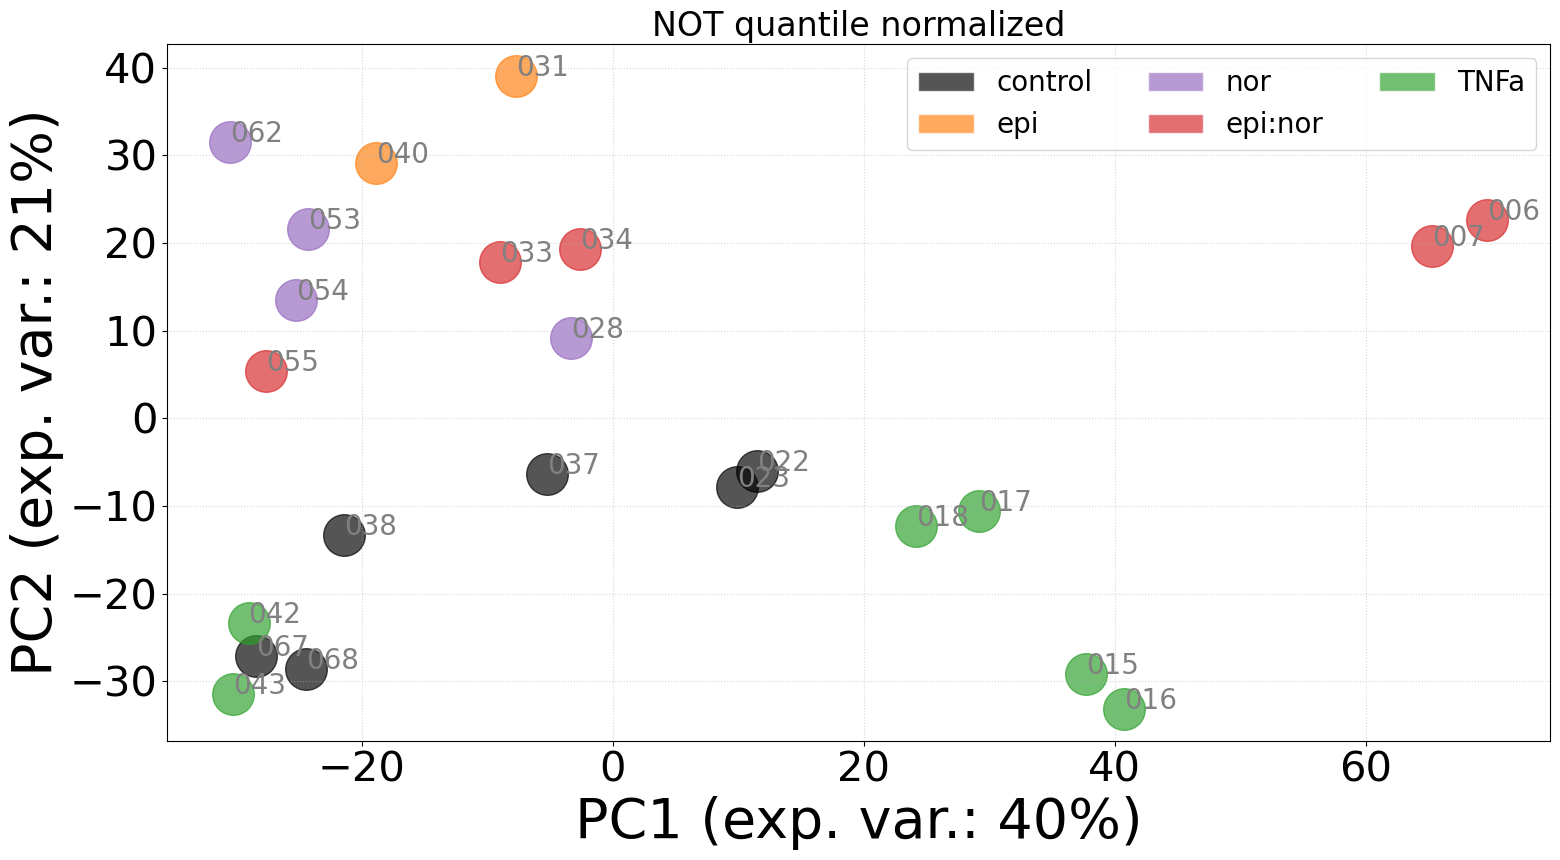

In [50]:
# non-quantile normalized all
transpose = new24.transpose()
scaled_data = sklearn.preprocessing.StandardScaler().fit_transform(transpose)
model = sklearn.decomposition.PCA(n_components=2)
locations = model.fit_transform(scaled_data)
explained = model.explained_variance_ratio_
print(explained)

for i in range(len(locations)):
    
    the_marker = 'o'
        
    if qndf.columns[i] in metadata['24h control']:
        the_color = 'black'
    elif qndf.columns[i] in metadata['24h epi']:
        the_color = 'tab:orange'
    elif qndf.columns[i] in metadata['24h nor']:
        the_color = 'tab:purple'
    elif qndf.columns[i] in metadata['24h epinor']:
        the_color = 'tab:red'
    elif qndf.columns[i] in metadata['24h TNFa']:
        the_color = 'tab:green'
    else:
        raise ValueError('sample not classified')
        
    matplotlib.pyplot.scatter(locations[i,0], locations[i,1], s=900, c=the_color, marker=the_marker, alpha=2/3)
    
    the_label = new24.columns[i].split('_')[-1]
    matplotlib.pyplot.text(locations[i, 0], locations[i, 1], the_label, color='gray')

    
legend_elements = [
    matplotlib.patches.Patch(facecolor='black', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:orange', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:purple', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:red', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:green', edgecolor='white', alpha=2/3)
]
matplotlib.pyplot.legend(legend_elements, ['control', 'epi', 'nor', 'epi:nor', 'TNFa'], ncol=3)

matplotlib.pyplot.xlabel('PC1 (exp. var.: {}%)'.format(int(explained[0]*100)))
matplotlib.pyplot.ylabel('PC2 (exp. var.: {}%)'.format(int(explained[1]*100)))
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.title('NOT quantile normalized')

matplotlib.pyplot.tight_layout()

7
['20220905_ARNAR_022', '20220905_ARNAR_023', '20220905_ARNAR_042', '20220905_ARNAR_043', '20220905_ARNAR_006', '20220905_ARNAR_007', '20220905_ARNAR_028']
(2241, 16)
[0.37897234 0.17605134]


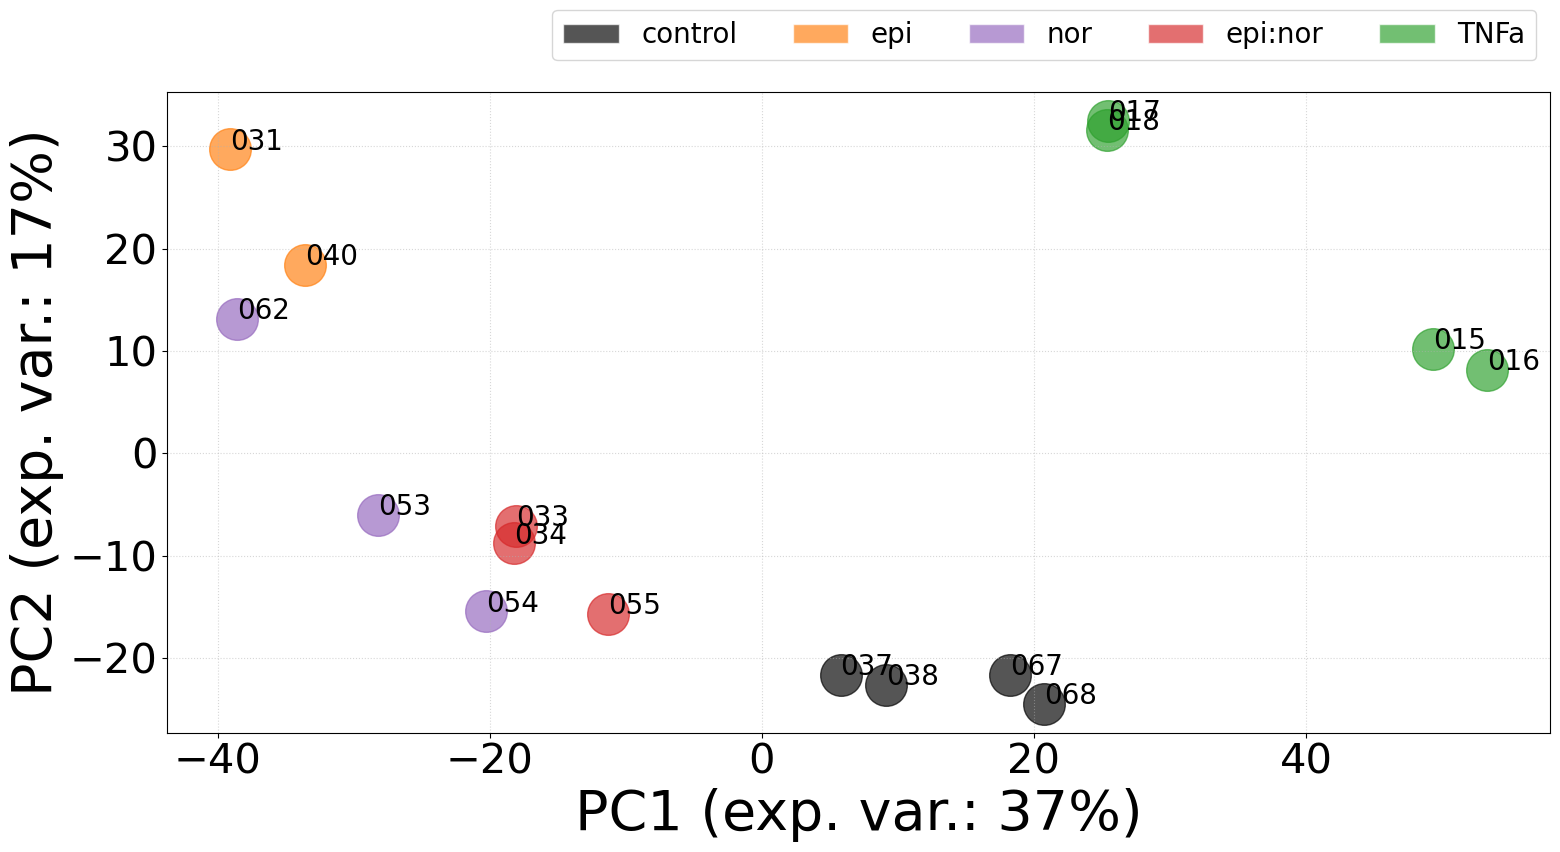

In [51]:
# excluding arbitrary samples
excluded_sample_tags = ['022', '023', '042', '043', '006', '007', '028']
print(len(excluded_sample_tags)) # should be 7
excluded_samples = ['20220905_ARNAR_' + element for element in excluded_sample_tags]
print(excluded_samples)
simplified_df = new24.drop(excluded_samples, axis=1)
print(simplified_df.shape)

# normalization
# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(simplified_df.values, axis=0), index=simplified_df.index, columns=simplified_df.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
qndf = simplified_df.rank(method="min").stack().astype(int).map(df_mean).unstack()

# PCA
transpose = qndf.transpose()
scaled_data = sklearn.preprocessing.StandardScaler().fit_transform(transpose)
model = sklearn.decomposition.PCA(n_components=2)
locations = model.fit_transform(scaled_data)
explained = model.explained_variance_ratio_
print(explained)

for i in range(len(locations)):
    
    the_marker = 'o'
    the_label = qndf.columns[i].split('_')[-1]
        
    if simplified_df.columns[i] in metadata['24h control']:
        the_color = 'black'
    elif simplified_df.columns[i] in metadata['24h epi']:
        the_color = 'tab:orange'
    elif simplified_df.columns[i] in metadata['24h nor']:
        the_color = 'tab:purple'
    elif simplified_df.columns[i] in metadata['24h epinor']:
        the_color = 'tab:red'
    elif simplified_df.columns[i] in metadata['24h TNFa']:
        the_color = 'tab:green'
    else:
        raise ValueError('sample not classified')
    
    matplotlib.pyplot.scatter(locations[i,0], locations[i,1], s=900, c=the_color, marker=the_marker, alpha=2/3)
    matplotlib.pyplot.text(locations[i, 0], locations[i, 1], the_label)
    
    
legend_elements = [ 
    matplotlib.patches.Patch(facecolor='black', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:orange', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:purple', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:red', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:green', edgecolor='white', alpha=2/3)
]
matplotlib.pyplot.legend(legend_elements, ['control', 'epi', 'nor', 'epi:nor', 'TNFa'], ncol=5, bbox_to_anchor=(1, 1.15))

matplotlib.pyplot.xlabel('PC1 (exp. var.: {}%)'.format(int(explained[0]*100)))
matplotlib.pyplot.ylabel('PC2 (exp. var.: {}%)'.format(int(explained[1]*100)))
matplotlib.pyplot.grid(alpha=0.5, ls=':')
#matplotlib.pyplot.title('quantile normalized post 24 hours')
matplotlib.pyplot.tight_layout()

There is more intra distance within TNFa than across epi:nor and control.
The grouping of different treatmens does not align.

### make comparisons

Cohen's d for this case of 6 samples is 3.257188
P before correction 0.0 1.0


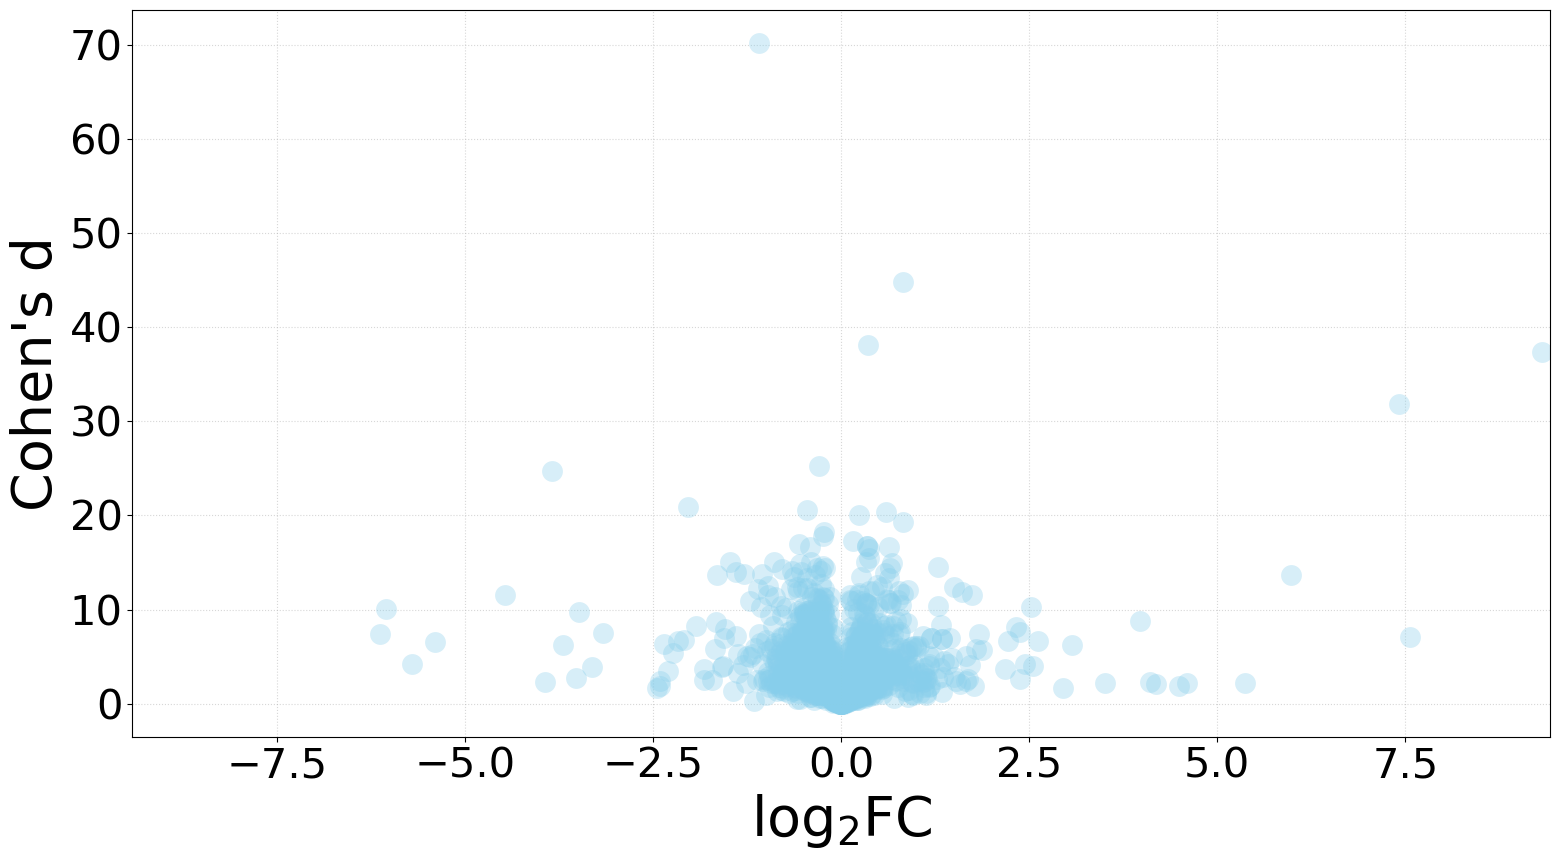

Benjamini-Hochberg correction
epsilon: 4.506744085204559

BIOMAKER
 P05362 ICAM-1 12 1.2545099213581876 black 


BIOMAKER
 P05121 PAI-1 70 2.275731289155514 tab:orange 


BIOMAKER
 P13598 ICAM-2 27 1.2425416188898422 black 



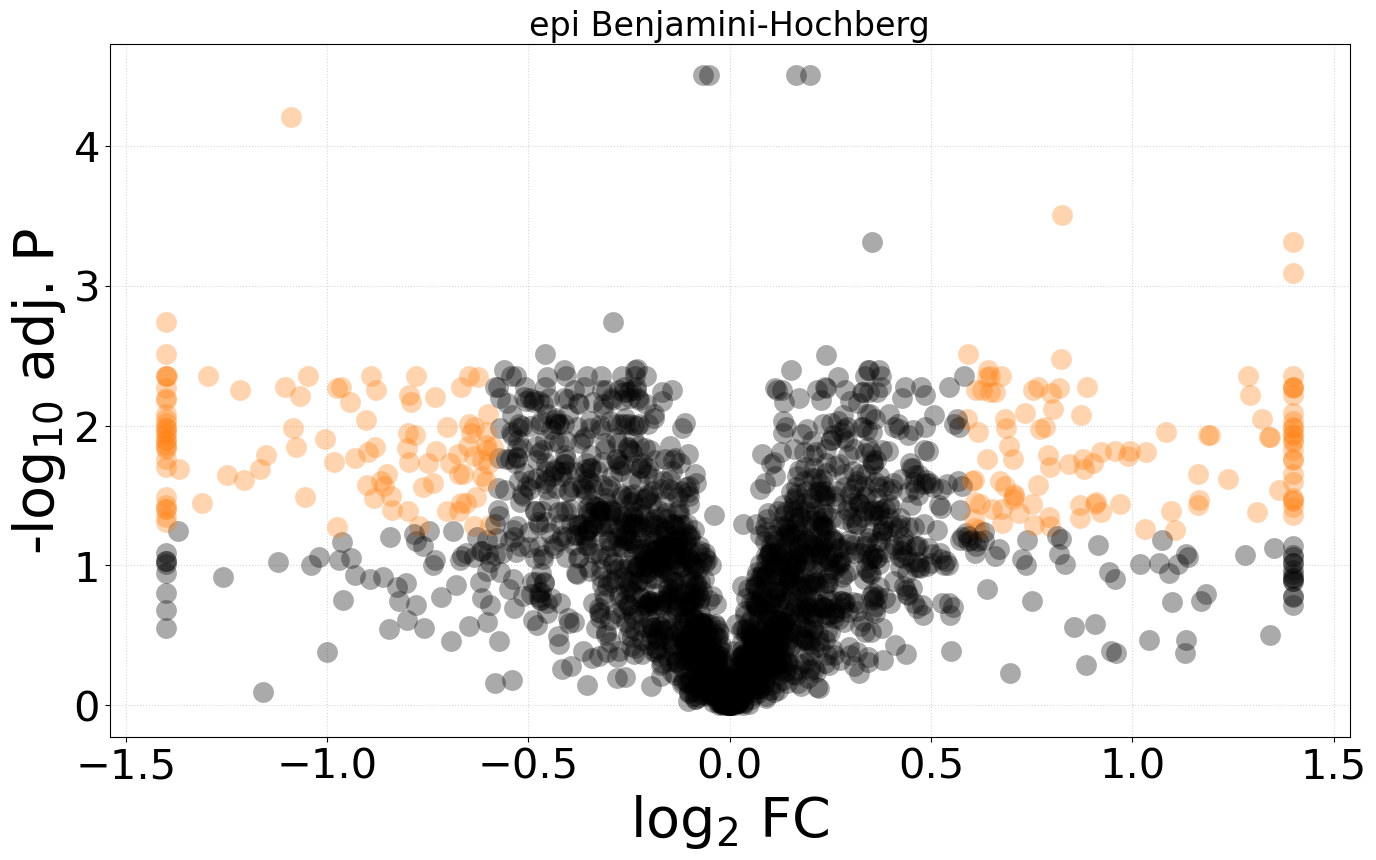

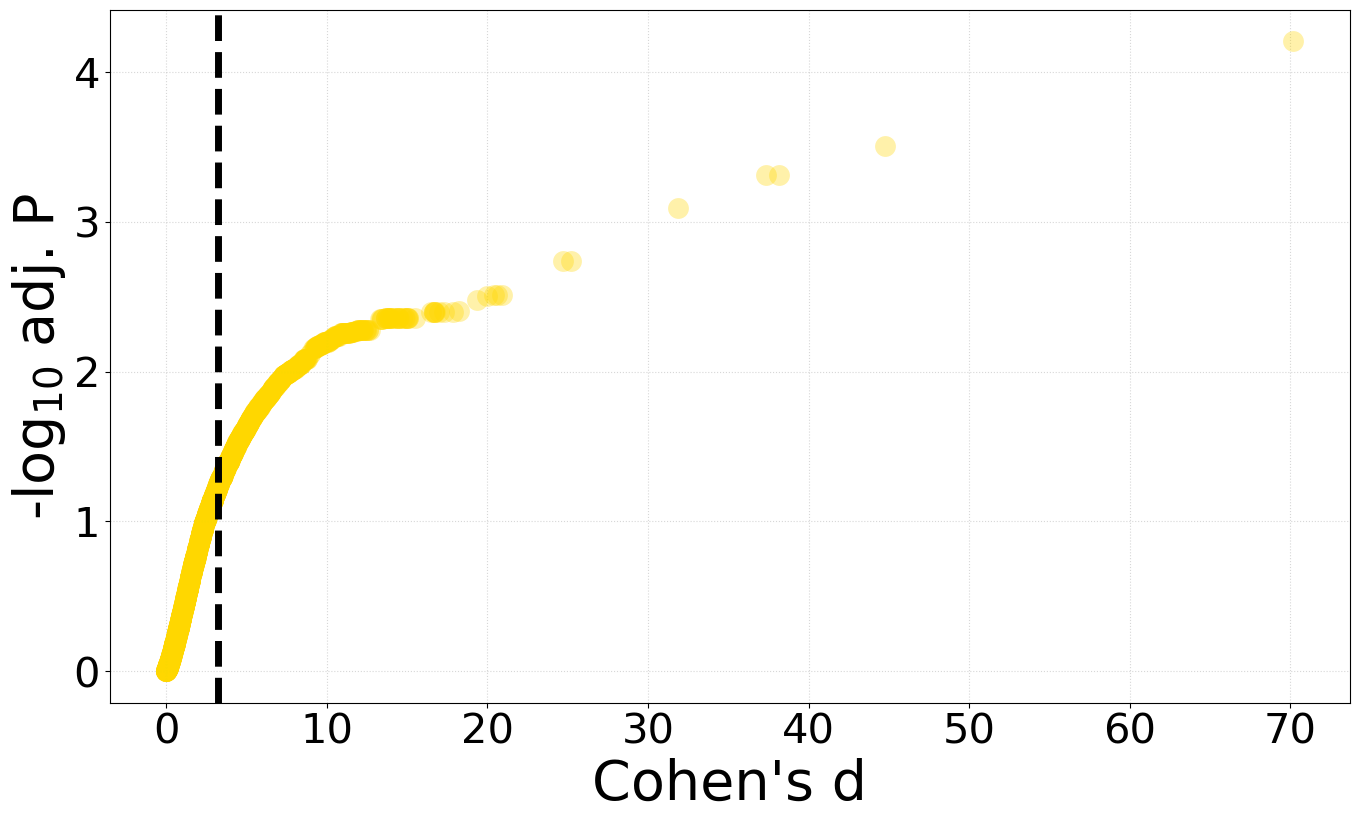

213 proteins respond to treatment


In [52]:
treatment_label = 'epi'
treatment_color = 'tab:orange'
control_samples = ['20220905_ARNAR_' + element for element in ['037', '038', '067', '068']]
treated_samples = ['20220905_ARNAR_' + element for element in ['031', '040']]
epi_response = comparison_function('24h', detected_biomarkers, qndf, treatment_label, treatment_color, control_samples, treated_samples)

Cohen's d for this case of 7 samples is 2.683785
P before correction 7.7382539794449e-08 1.0


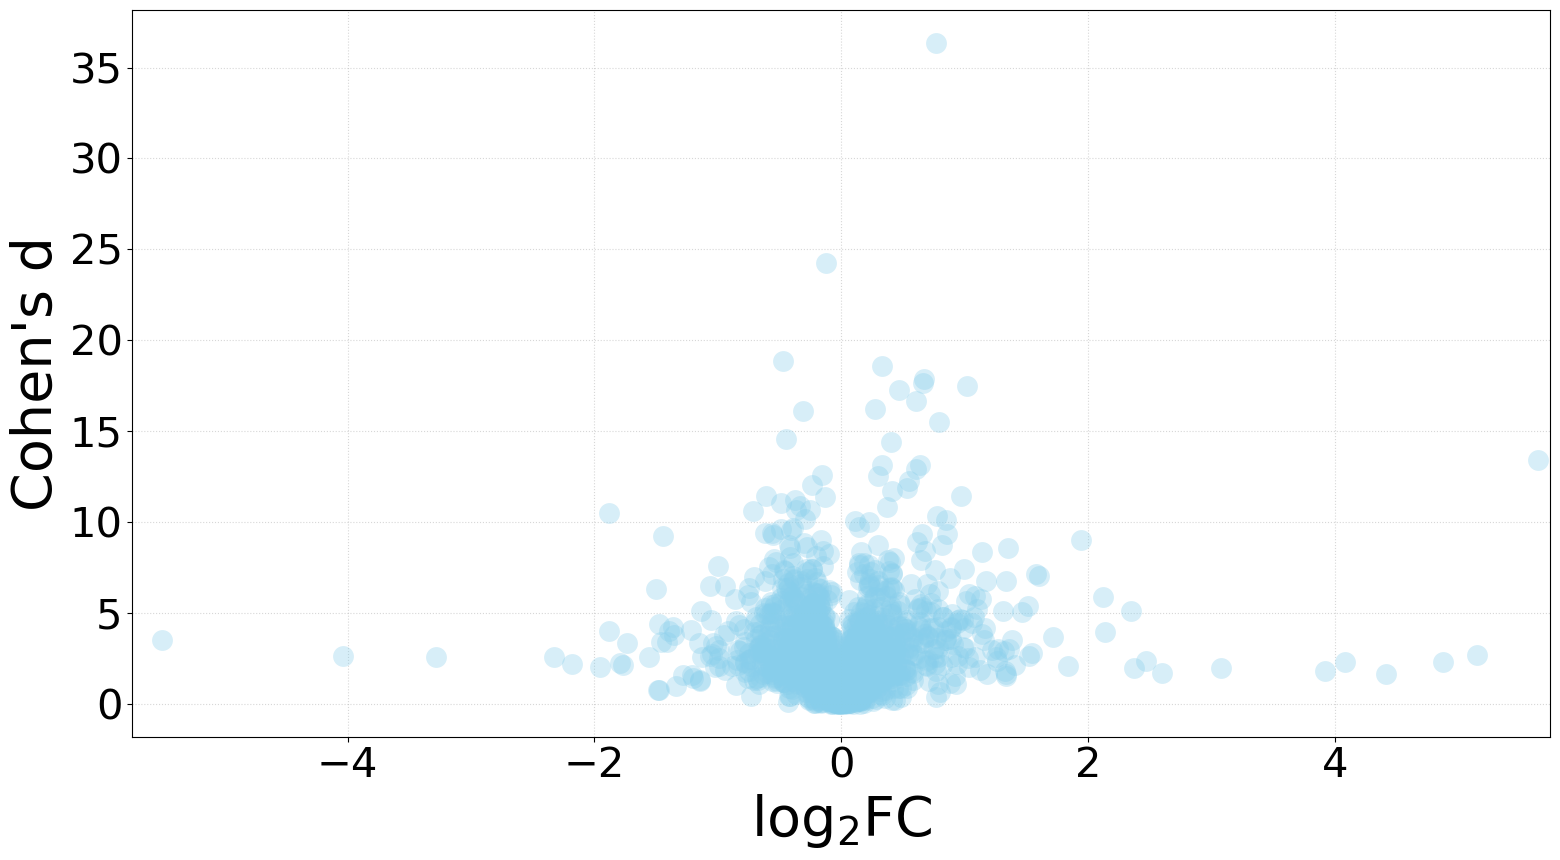

Benjamini-Hochberg correction
epsilon: 4.061945159406489

BIOMAKER
 P05362 ICAM-1 4 1.046210849757752 black 


BIOMAKER
 P05121 PAI-1 25 1.5736136269815324 black 


BIOMAKER
 P13598 ICAM-2 8 0.49312970824977986 black 



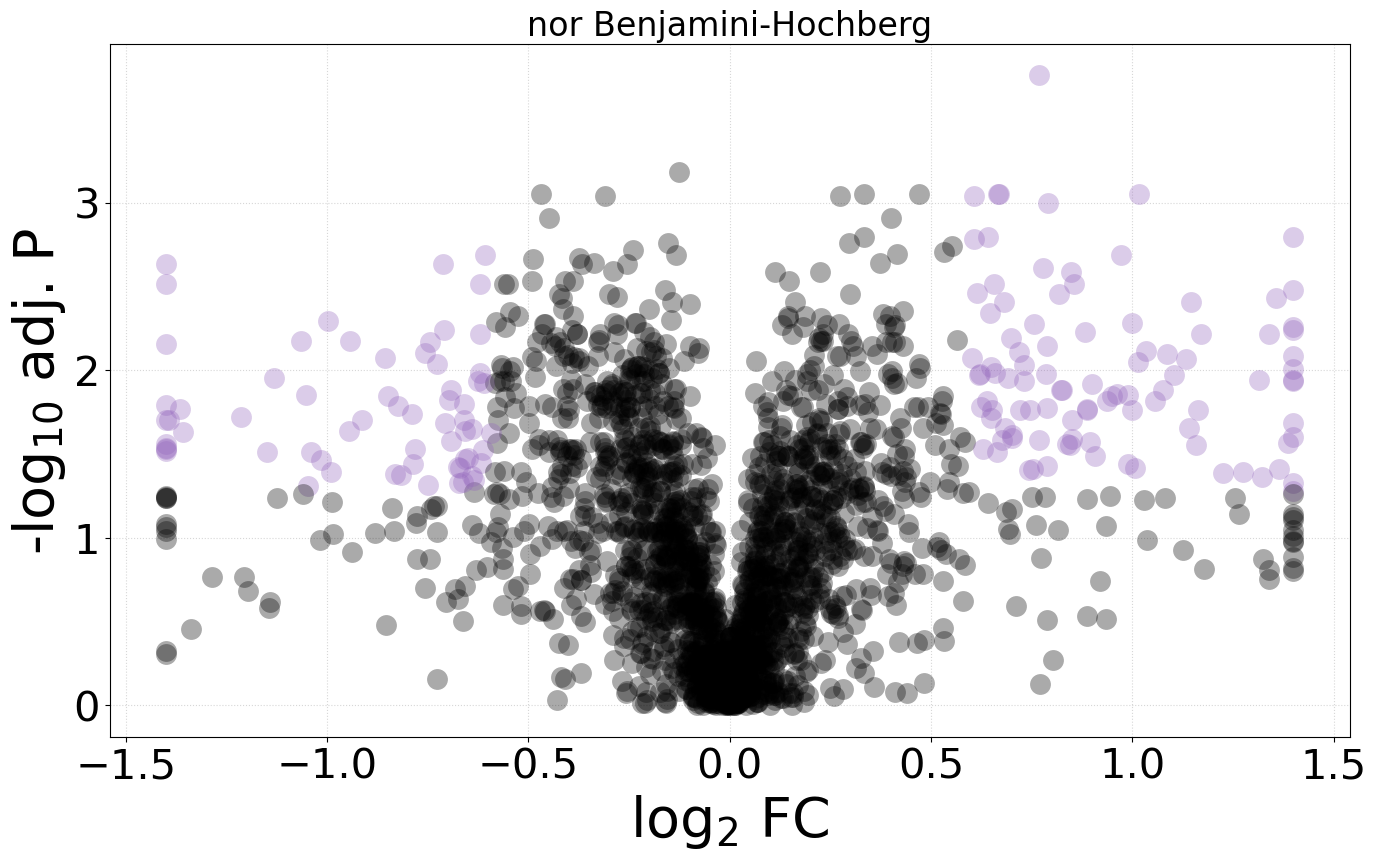

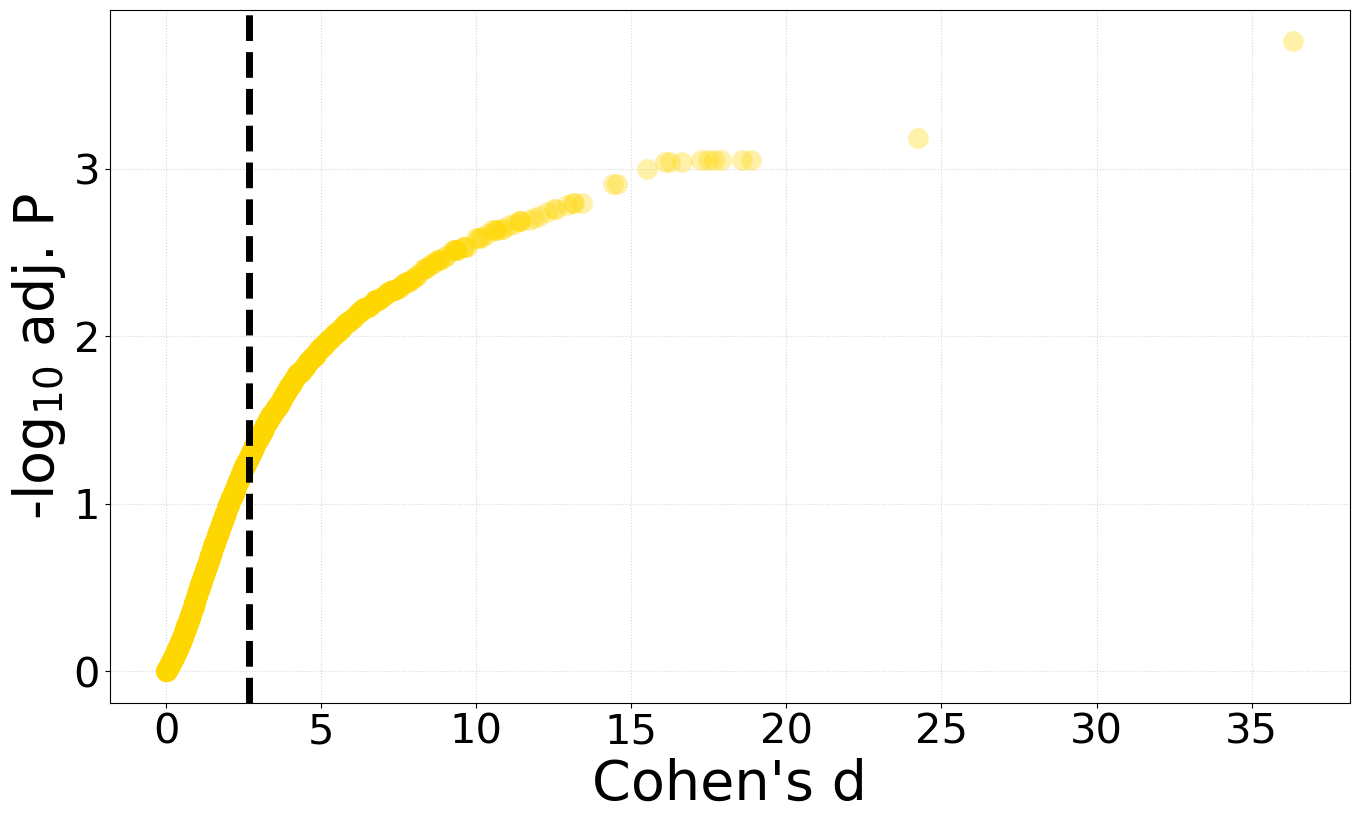

163 proteins respond to treatment


In [53]:
treatment_label = 'nor'
treatment_color = 'tab:purple'
control_samples = ['20220905_ARNAR_' + element for element in ['037', '038', '067', '068']]
treated_samples = ['20220905_ARNAR_' + element for element in ['062', '053', '054']]
nor_response = comparison_function('24h', detected_biomarkers, qndf, treatment_label, treatment_color, control_samples, treated_samples)

Cohen's d for this case of 7 samples is 2.683785
P before correction 0.0 1.0


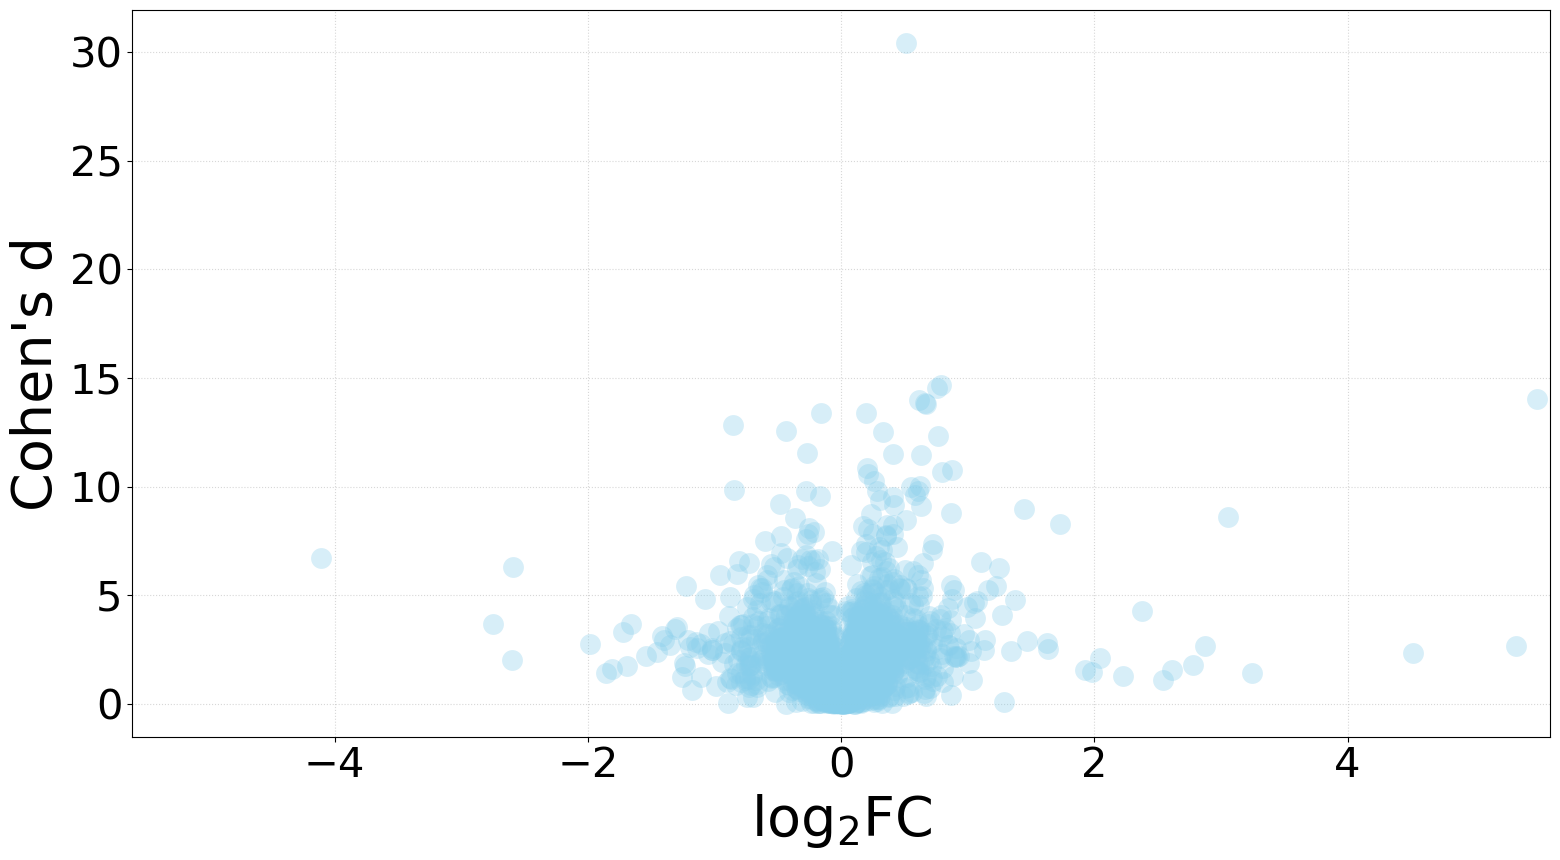

Benjamini-Hochberg correction
epsilon: 4.153411295050821

BIOMAKER
 P05362 ICAM-1 5 0.8873766460886164 black 


BIOMAKER
 P05121 PAI-1 4 0.34943329844675 black 


BIOMAKER
 P13598 ICAM-2 8 0.18694954180440845 black 



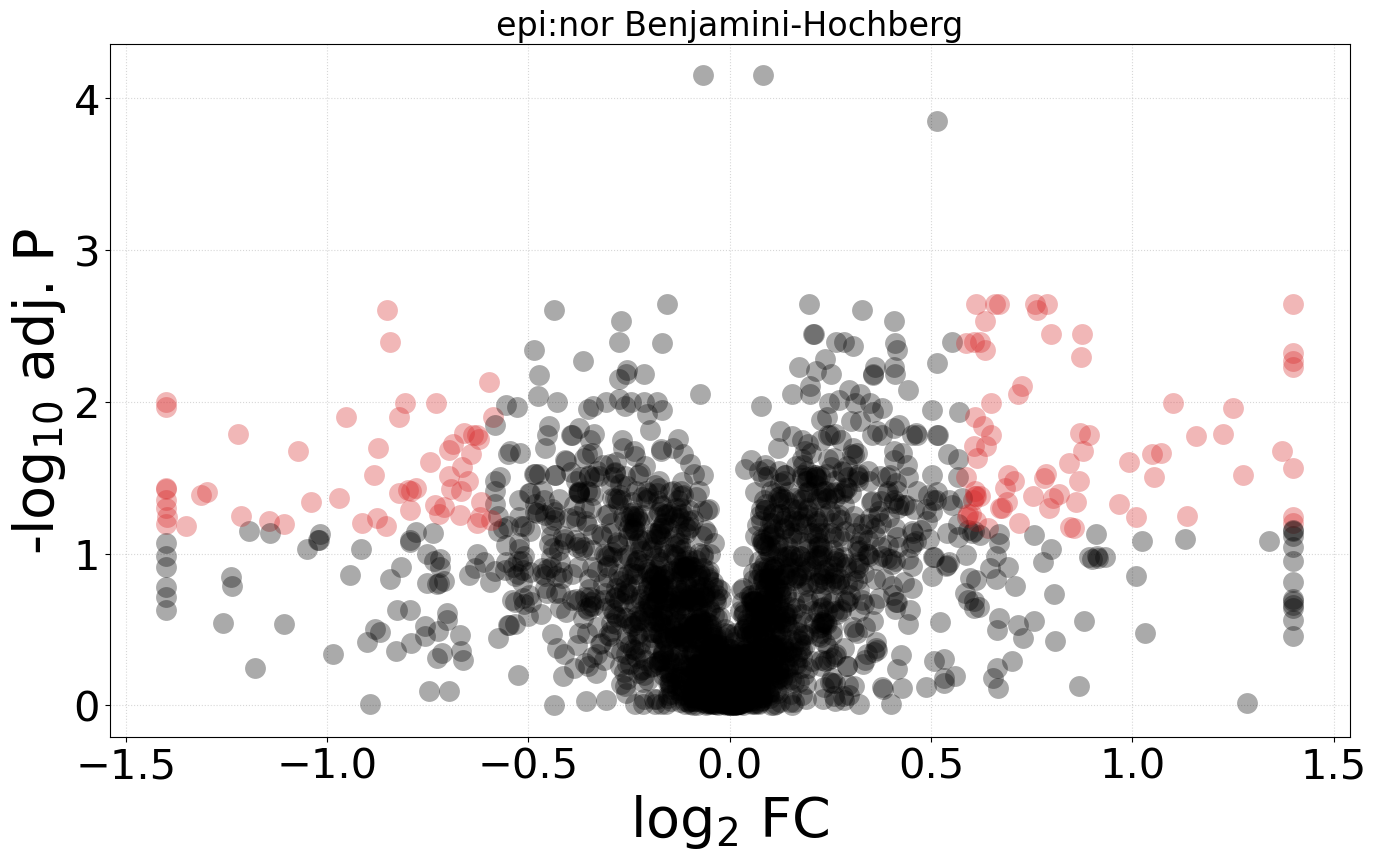

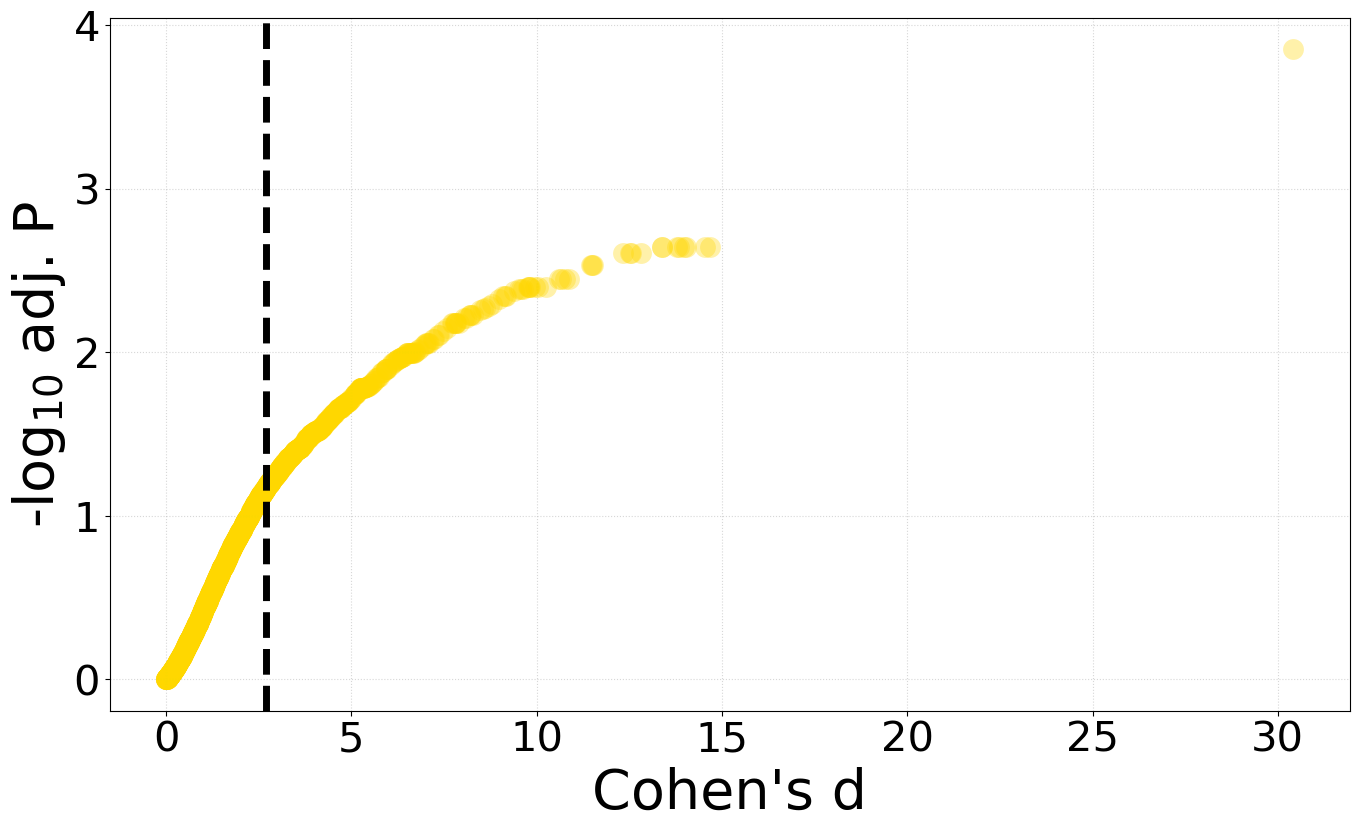

132 proteins respond to treatment


In [54]:
treatment_label = 'epi:nor'
treatment_color = 'tab:red'
control_samples = ['20220905_ARNAR_' + element for element in ['037', '038', '067', '068']]
treated_samples = ['20220905_ARNAR_' + element for element in ['033', '034', '055']]
epinor_response = comparison_function('24h', detected_biomarkers, qndf, treatment_label, treatment_color, control_samples, treated_samples)

Cohen's d for this case of 8 samples is 2.380757
P before correction 0.0 1.0


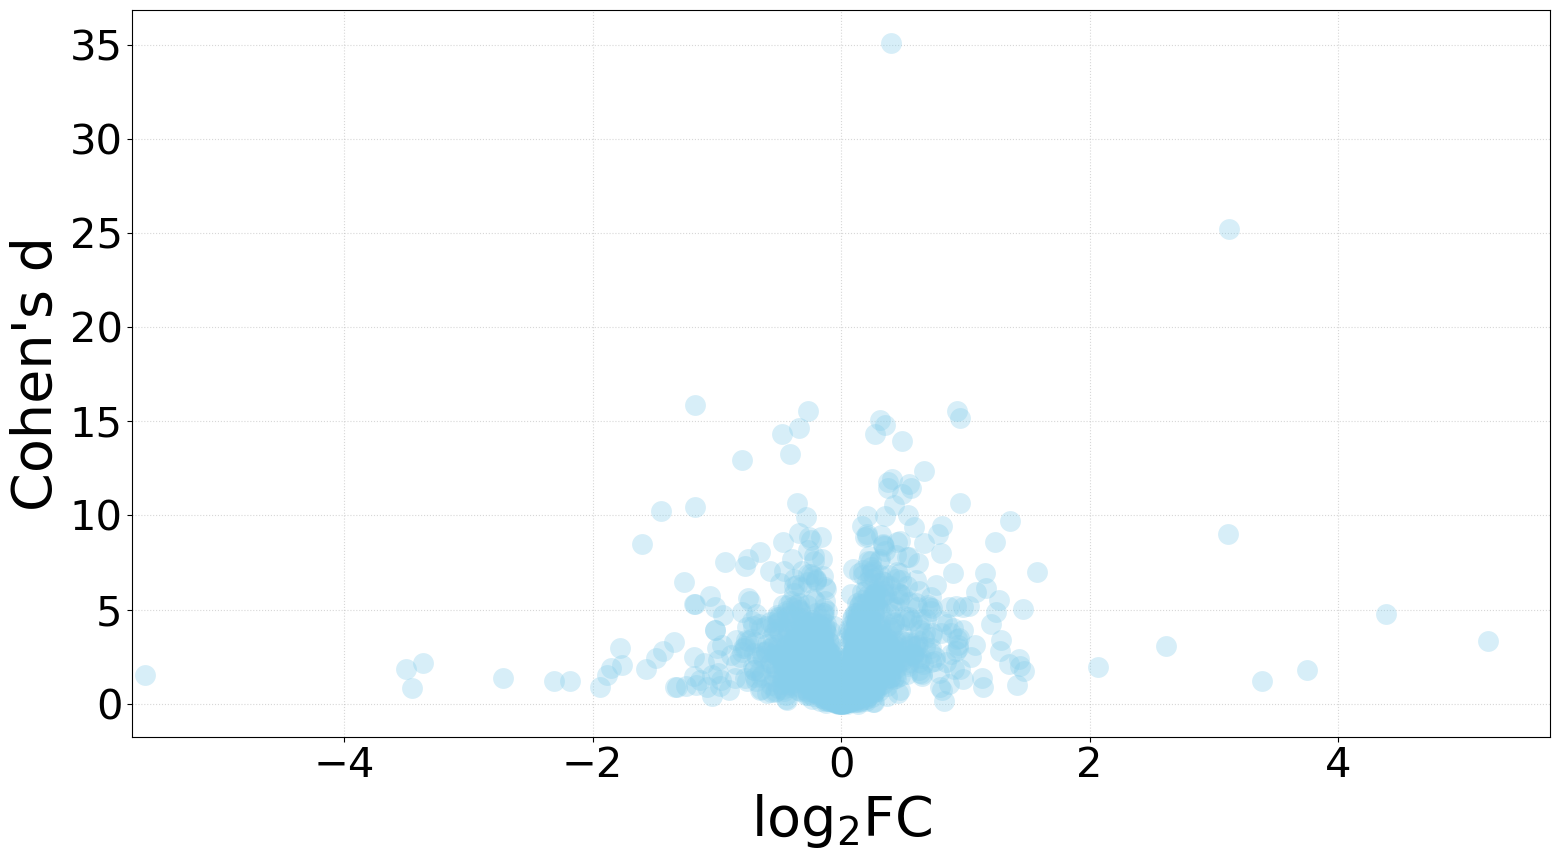

Benjamini-Hochberg correction
epsilon: 5.775428154368396

BIOMAKER
 P05362 ICAM-1 163 4.738456860139816 tab:green 


BIOMAKER
 P05121 PAI-1 14 0.1975948056318192 black 


BIOMAKER
 P13598 ICAM-2 7 0.218919274319021 black 



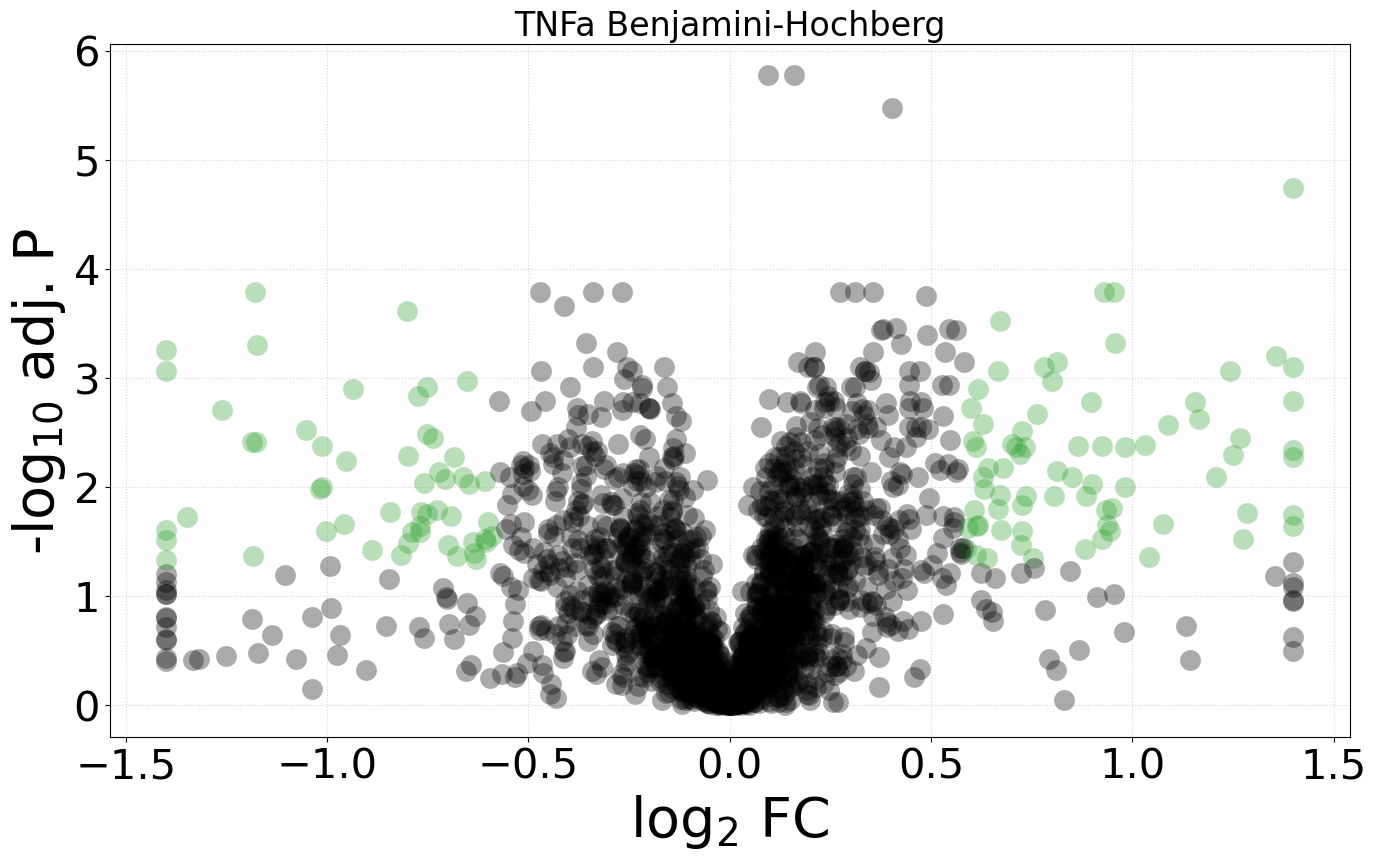

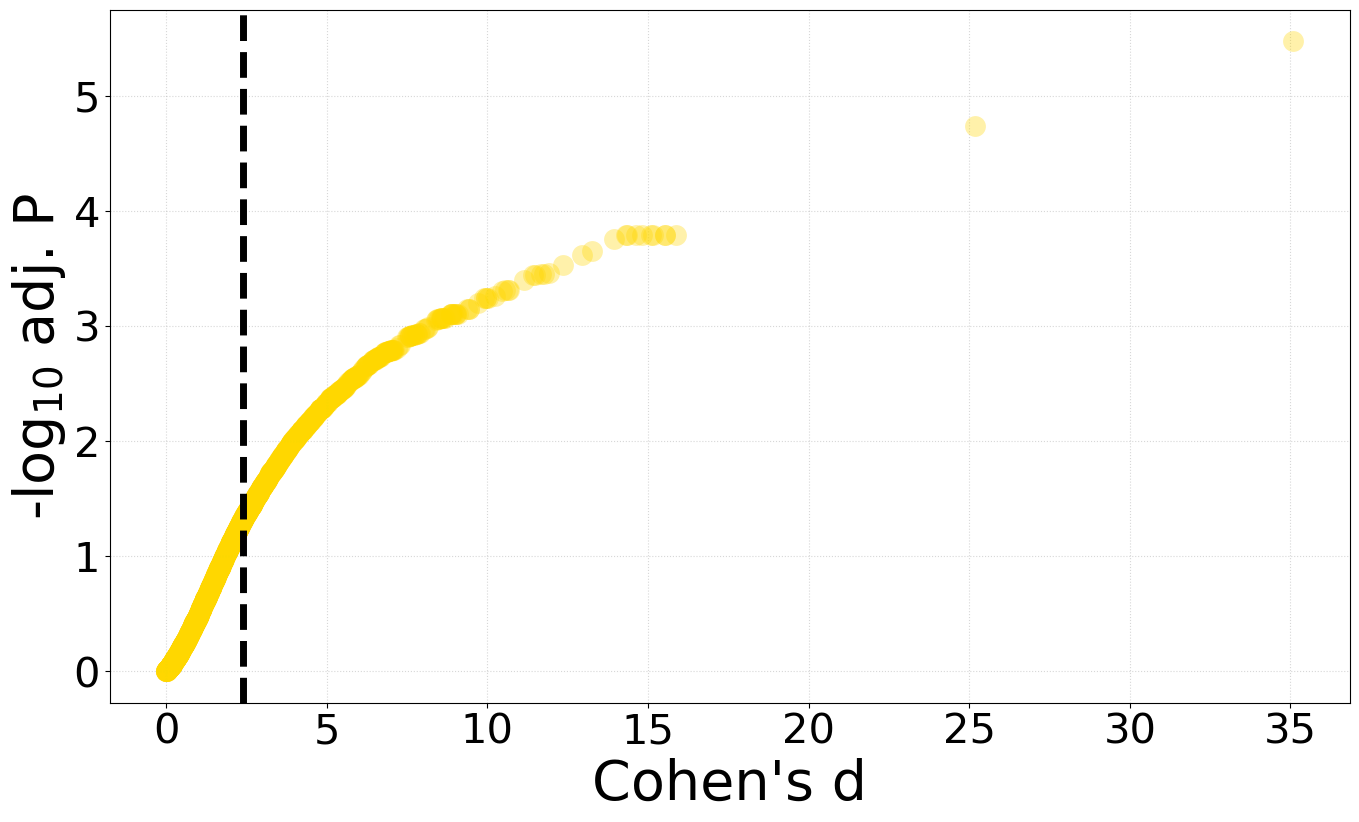

128 proteins respond to treatment


In [55]:
treatment_label = 'TNFa'
treatment_color = 'tab:green'
control_samples = ['20220905_ARNAR_' + element for element in ['037', '038', '067', '068']]
treated_samples = ['20220905_ARNAR_' + element for element in ['017', '018', '015', '016']]
tnfa_response = comparison_function('24h', detected_biomarkers, qndf, treatment_label, treatment_color, control_samples, treated_samples)

### Venn diagram of treatmens

In [56]:
epi_set = set(epi_response)
nor_set = set(nor_response)
epinor_set = set(epinor_response)

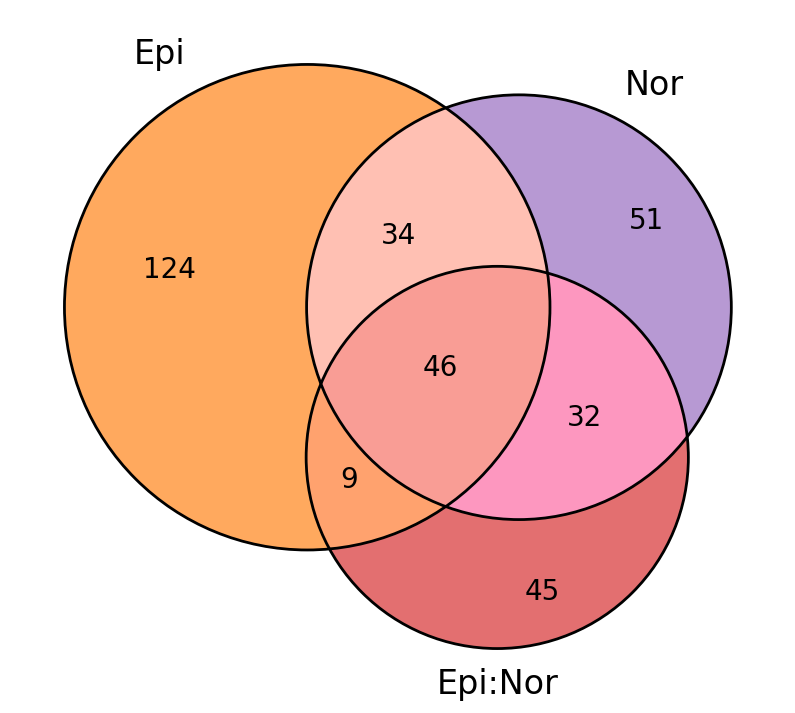

In [57]:
matplotlib_venn.venn3(
    [epi_set, nor_set, epinor_set], 
    set_labels=('Epi', 'Nor', 'Epi:Nor'),
    set_colors=('tab:orange', 'tab:purple', 'tab:red'),
    alpha=2/3
)
matplotlib_venn.venn3_circles(
    [epi_set, nor_set, epinor_set],
    linewidth=2
)
matplotlib.pyplot.show()

In [58]:
epi_only = epi_set - nor_set - epinor_set
nor_only = nor_set - epi_set - epinor_set
epinor_only = epinor_set - epi_set - nor_set

epi_and_nor = epi_set & nor_set - epinor_set
epi_and_epinor = epi_set & epinor_set - nor_set
nor_and_epinor = nor_set & epinor_set - epi_set

intersect = epi_set & nor_set & epinor_set

print(len(epi_only), len(nor_only), len(epinor_only))
print(len(epi_and_nor), len(epi_and_epinor), len(nor_and_epinor))
print(len(intersect))
print()

# build a list and create files
labels = ['epi_only', 'nor_only', 'epinor_only', 'epi_and_nor', 'epi_and_epinor', 'nor_and_epinor', 'intersect']
lists = [epi_only, nor_only, epinor_only, epi_and_nor, epi_and_epinor, nor_and_epinor, intersect]
for i in range(len(labels)):
    f = open(output_dir + labels[i] + '.24h.tsv', 'w')
    f.write('Uniprot\tDescription\n')
    for protein in lists[i]:
        content = f'{protein}\t{rosetta[protein]}\n'
        f.write(content)
    f.close()
    print(f'closing {labels[i]}')

124 51 45
34 9 32
46

closing epi_only
closing nor_only
closing epinor_only
closing epi_and_nor
closing epi_and_epinor
closing nor_and_epinor
closing intersect


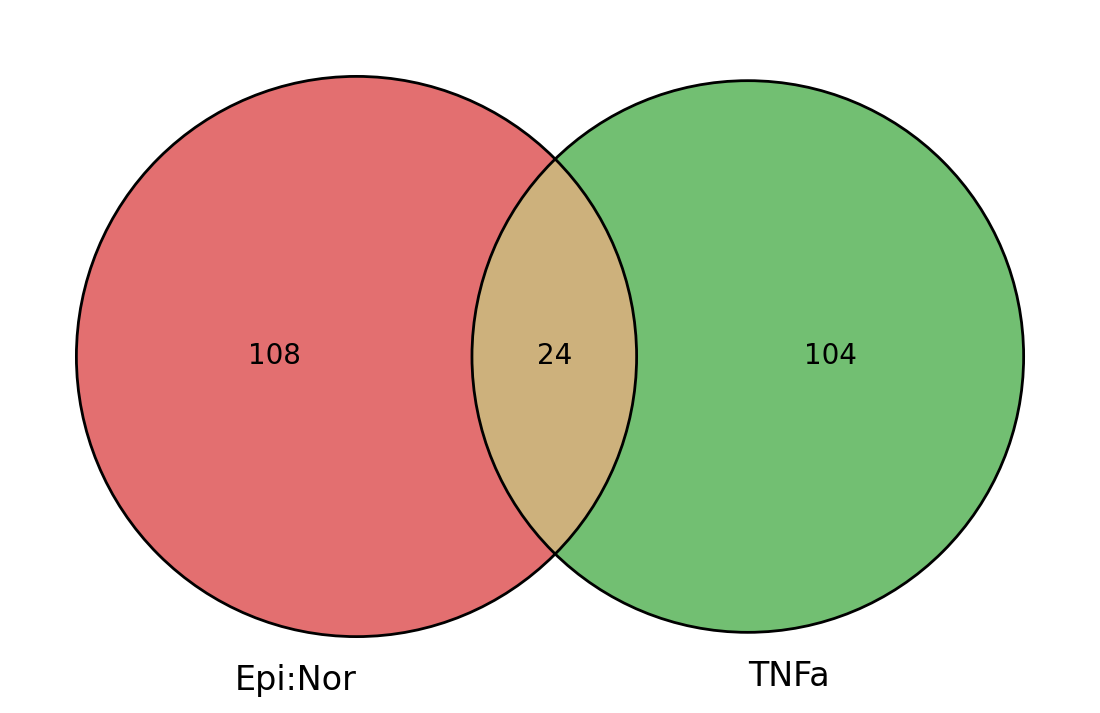

In [59]:
matplotlib_venn.venn2(
    [set(epinor_response), set(tnfa_response)], 
    set_labels=('Epi:Nor', 'TNFa'),
    set_colors=('tab:red', 'tab:green'),
    alpha=2/3
)
matplotlib_venn.venn2_circles(
    [set(epinor_response), set(tnfa_response)],
    linewidth=2
)
matplotlib.pyplot.show()